In [2]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix

import joblib
import numpy as np
from pathlib import Path

# pour enlever les warnings
import warnings
warnings.filterwarnings('ignore')

# Import data

In [1]:
# load dataset containing sex and participant id
df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")
df

NameError: name 'pd' is not defined

In [3]:
print("hommes = ", df["Gender"].value_counts()[0])
print("femmes = ", df["Gender"].value_counts()[1])

hommes =  263
femmes =  301


In [4]:
average_age_men = round(df[df["Gender"]== 0]["Age_in_Yrs"].mean(),1)
average_age_men


27.5

In [5]:
average_age_women = round(df[df["Gender"]== 1]["Age_in_Yrs"].mean(),1)
average_age_women


29.1

In [21]:
# get the faster seed
file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_voxelcorrelations/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__voxelcorrelations.csv"
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
data = {}

for seed in SEEDS:
    # TODO le path des atlas a changer, à confirmer
    file = file_path.format(seed_name=seed)
    loaded = pd.read_csv(file_path.format(seed_name=seed))
    for subject in df["subject_label"]:
        string = "sub-"+str(subject)
        new  = loaded.loc[loaded["Unnamed: 0"] == string]
        data[(subject, seed)] = new.loc[:, new.columns!='Unnamed: 0'].to_numpy()[0]

In [22]:
df_boot = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")
x_correl = []
for sub in tqdm(df_boot["subject_label"]):
    line_temp = []
    for seed in SEEDS:
        line_temp.append(data[(sub, seed)])
    x_correl.append(np.concatenate(line_temp))
x_correl = np.array(x_correl)


100%|██████████████████████████████████████| 564/564 [00:00<00:00, 46810.87it/s]


# Define function

In [5]:
def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    # X_std = x_correl.std()
    # weighted_coef = moyenne * X_std
    # label_name = list(label['name']) * len(rois)
    # seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    # weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

In [6]:
def bestRegion(ROIs, data_dict, data_df):
    
    best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
    best_roi = []

    for row in best.iterrows():
        best_roi.append([row[1][1], row[1][2], [], []])

    label_female = []
    label_male = []

    for i in range(0,len(data_df["Gender"])):
        if data_df["Gender"][i] == 0:
            label_male.append(data_df["subject_label"][i])

        elif data_df["Gender"][i] == 1:
            label_female.append(data_df["subject_label"][i])
            

    for i in data_dict.keys():
        if label_male.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][2].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

        elif label_female.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][3].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

    table_best = pd.DataFrame(columns=["Region", "Men", "Women", "P value"])
    for i in range(0, len(best_roi)):
        best_roi[i][2] = np.asarray(best_roi[i][2]) # male
        best_roi[i][3] = np.asarray(best_roi[i][3]) # female
        plt.boxplot([best_roi[i][2], best_roi[i][3]])
        plt.xticks([1,2], ["male", "female"])
        plt.title(best_roi[i][0]+" "+best_roi[i][1])
        plt.show()
        print(stats.ttest_ind(best_roi[i][2], best_roi[i][3]))
        print("male mean : "+ str(np.mean(best_roi[i][2])))
        print("male std : " + str(np.std(best_roi[i][2])))
        print("female mean : "+ str(np.mean(best_roi[i][3])))
        print("female std : " + str(np.std(best_roi[i][3])))
        pd.concat([table_best, pd.DataFrame([{'Region' : best_roi[i][0] + " - " + best_roi[i][1],
                                        'Men' : np.mean(best_roi[i][2]), 
                                        'Women' : np.mean(best_roi[i][3]), 
                                        'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}])], ignore_index=True)
        # table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],
        #                                 'Men' : np.mean(best_roi[i][2]), 
        #                                 'Women' : np.mean(best_roi[i][3]), 
        #                                 'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}, ignore_index=True)
        
    print(table_best)

In [7]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [8]:
def compute_results(results_path):
    results = joblib.load(results_path)

    coefs = []
    for result in results:
        coefs.append(result["model"].coef_[0])

    coefs = np.array(coefs)

    data_results = pd.DataFrame.from_dict(results)
    moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)
    return moyenne, scoresZ, pvalue_bonf, data_results

## Define data path to each model results

In [59]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_2024" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results_2024" / "LinearSVC" / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results_2024" / "LinearSVC" / "seed-aMTG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results_2024" / "LinearSVC" / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results_2024" / "LinearSVC" / "seed-opIFG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results_2024" / "LinearSVC" / "seed-pITG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results_2024" / "LinearSVC" / "seed-pITG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results_2024" / "LinearSVC" / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results_2024" / "LinearSVC" / "seed-planumtemp_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_left = study_dir / "results_2024" / "LinearSVC" / "seed-left_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_right = study_dir / "results_2024" / "LinearSVC" / "seed-right_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"


# Best region with grey matter corrected

In [14]:
# fetching label from destrieux atlas minus two labels not used
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()

## Best regions all seed

      coefficient          seed                       labels
98       0.080936       opIFG_L       R G_pariet_inf-Angular
1079     0.061961        pITG_R                L S_calcarine
55       0.061655       opIFG_L  L S_intrapariet_and_P_trans
53       0.059059       opIFG_L                L S_front_sup
379      0.057851        aMTG_L      R G_cingul-Post-ventral
301      0.055354        aMTG_L         L G_and_S_cingul-Ant
504      0.053628        pITG_L  L S_oc-temp_med_and_Lingual
305      0.053026        aMTG_L      L G_cingul-Post-ventral
189      0.052916  planumtemp_L             L Pole_occipital
1013     0.051722        aMTG_R                R S_front_inf
The mean accuracy : 0.9062513274336282
The standard deviation of the accuracy : 0.02943331307469047
The lower boundry of the confidance interval of the accuracy : 0.8485620338072349
The upper boundry of the confidance interval of the accuracy : 0.9639406210600215


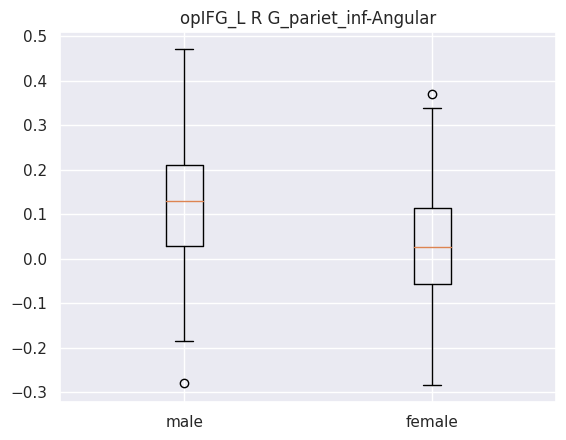

Ttest_indResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14)
male mean : 0.11766997985152092
male std : 0.13076288558639354
female mean : 0.03601953544850498
female std : 0.12000095132461792


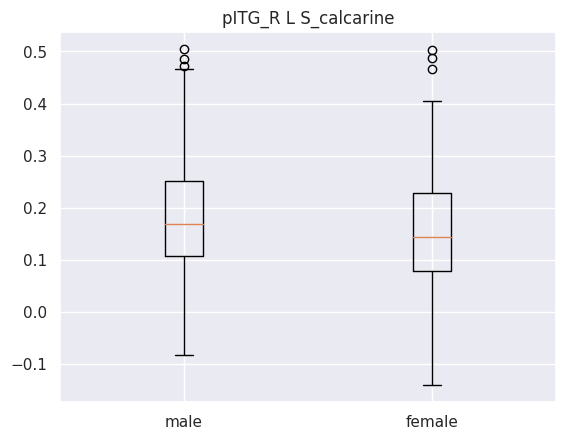

Ttest_indResult(statistic=3.2351347094550422, pvalue=0.0012873143650390924)
male mean : 0.18480961091102663
male std : 0.10817911899491708
female mean : 0.1554359898385382
female std : 0.10667308658653767


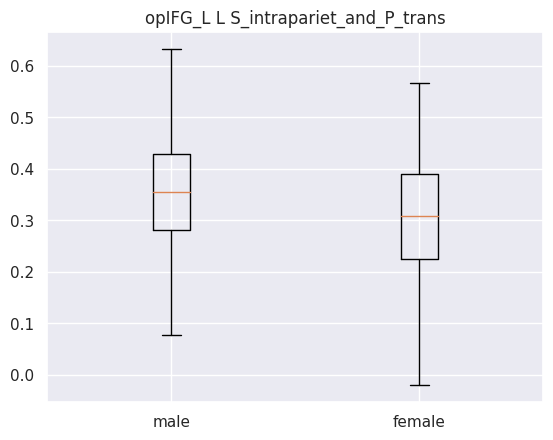

Ttest_indResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07)
male mean : 0.35213074777946773
male std : 0.10658887449917556
female mean : 0.3031099729109635
female std : 0.12130464463020163


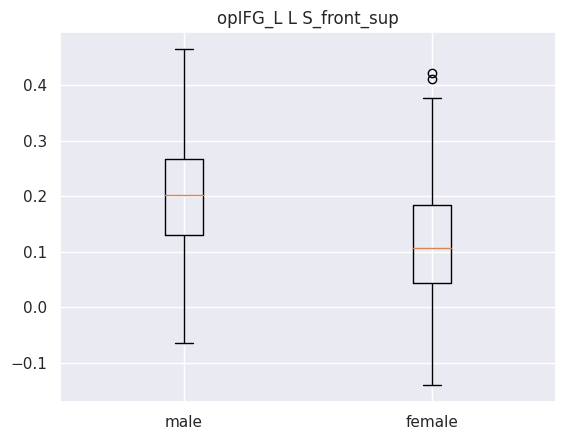

Ttest_indResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22)
male mean : 0.1996858131581749
male std : 0.10098467263884126
female mean : 0.11606861896099667
female std : 0.09690605329034335


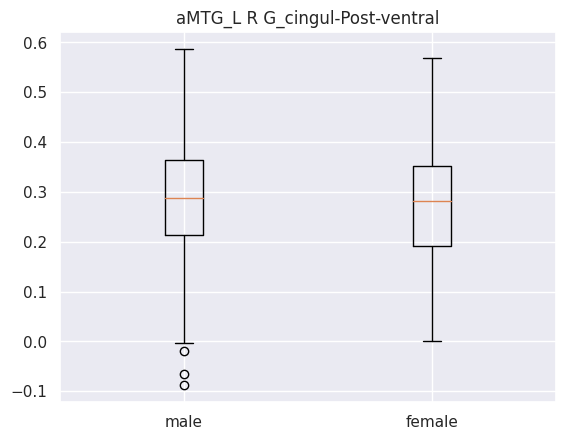

Ttest_indResult(statistic=0.6388341521167346, pvalue=0.5231910904943788)
male mean : 0.2817180546878327
male std : 0.1142358661162035
female mean : 0.27555022588073086
female std : 0.11413329475603474


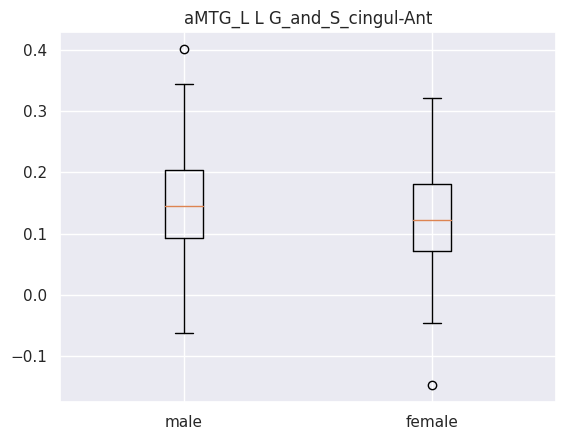

Ttest_indResult(statistic=3.7303929972815153, pvalue=0.0002105917212726882)
male mean : 0.15045088956692015
male std : 0.0832245566464698
female mean : 0.1251106278551495
female std : 0.07772302305402938


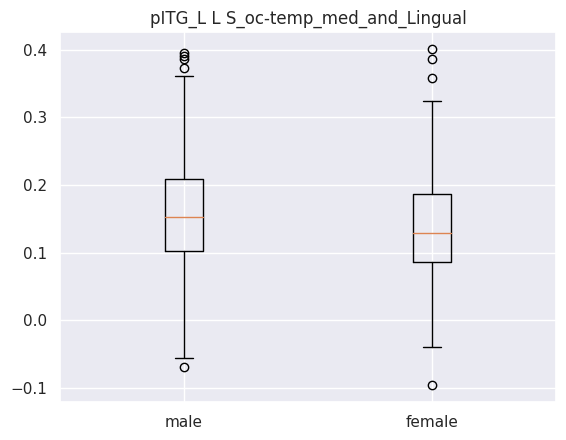

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
male std : 0.08334523805349907
female mean : 0.13959590949933556
female std : 0.07802101521527612


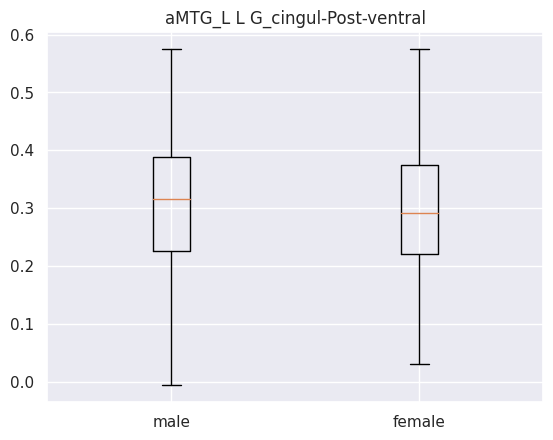

Ttest_indResult(statistic=1.3702197065710244, pvalue=0.17116542321143072)
male mean : 0.3069893446501901
male std : 0.11217529835047435
female mean : 0.29388020735880394
female std : 0.1139849037228173


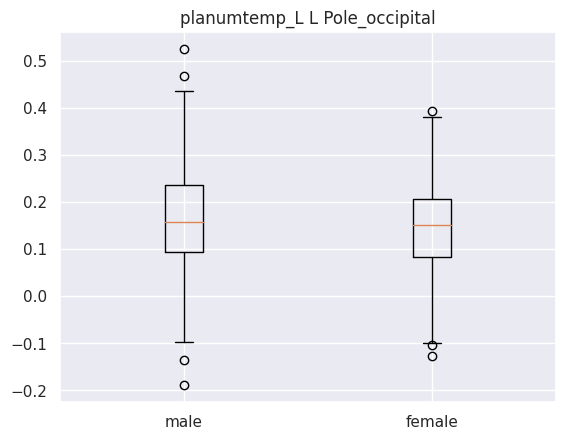

Ttest_indResult(statistic=2.486200541931443, pvalue=0.013200894125973316)
male mean : 0.16626784924790874
male std : 0.11264322709736568
female mean : 0.14439602449857145
female std : 0.09589248593995307


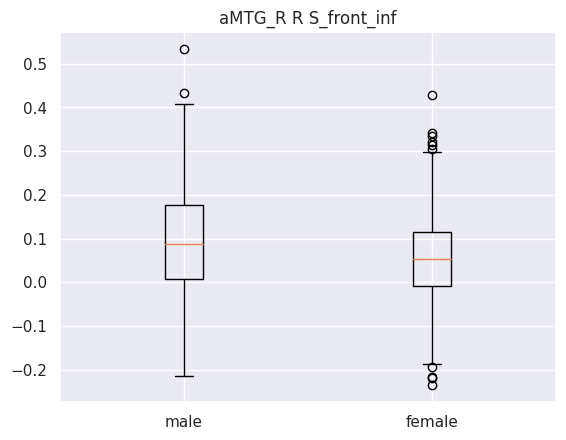

Ttest_indResult(statistic=4.148252422200393, pvalue=3.868639529214971e-05)
male mean : 0.09520096379193917
male std : 0.11824387845447384
female mean : 0.055367278695980064
female std : 0.10930840275035555
                                  Region       Men     Women       P value
0       opIFG_L - R G_pariet_inf-Angular  0.117670  0.036020  5.480752e-14
1                 pITG_R - L S_calcarine  0.184810  0.155436  1.287314e-03
2  opIFG_L - L S_intrapariet_and_P_trans  0.352131  0.303110  5.821782e-07
3                opIFG_L - L S_front_sup  0.199686  0.116069  8.422510e-22
4       aMTG_L - R G_cingul-Post-ventral  0.281718  0.275550  5.231911e-01
5          aMTG_L - L G_and_S_cingul-Ant  0.150451  0.125111  2.105917e-04
6   pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  2.643129e-03
7       aMTG_L - L G_cingul-Post-ventral  0.306989  0.293880  1.711654e-01
8        planumtemp_L - L Pole_occipital  0.166268  0.144396  1.320089e-02
9                 aMTG_R - R S_front_inf  0.

In [60]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions for aMTG_L

     coefficient    seed                       labels
22      0.251448  aMTG_L      L G_oc-temp_med-Parahip
98      0.235516  aMTG_L       R G_pariet_inf-Angular
104     0.216673  aMTG_L                   R G_rectus
64      0.198969  aMTG_L        L S_parieto_occipital
53      0.187694  aMTG_L                L S_front_sup
131     0.179025  aMTG_L   R S_oc_sup_and_transversal
55      0.177971  aMTG_L  L S_intrapariet_and_P_trans
29      0.154544  aMTG_L                L G_precuneus
87      0.154097  aMTG_L       R G_front_inf-Triangul
103     0.137369  aMTG_L                R G_precuneus
The mean accuracy : 0.8101433628318584
The standard deviation of the accuracy : 0.03814689567474887
The lower boundry of the confidance interval of the accuracy : 0.7353754473093506
The upper boundry of the confidance interval of the accuracy : 0.8849112783543662


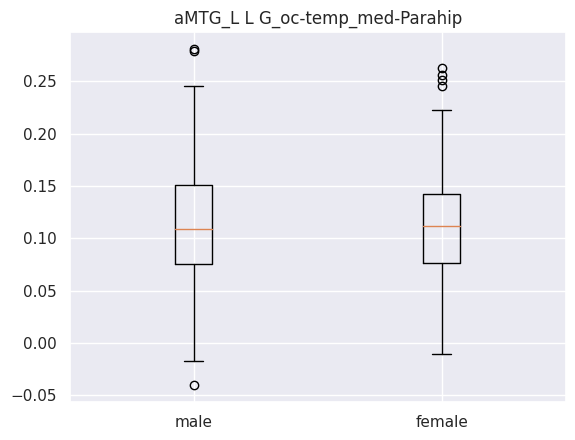

Ttest_indResult(statistic=1.1334696103846564, pvalue=0.25750038435672185)
male mean : 0.11530491022243346
male std : 0.05322901814260232
female mean : 0.11041756162126246
female std : 0.048956437497619715


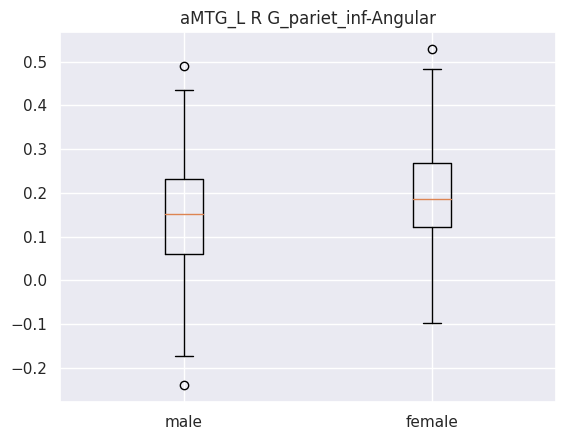

Ttest_indResult(statistic=-4.609075888150725, pvalue=5.010077069107832e-06)
male mean : 0.1466265599053232
male std : 0.12723212732120814
female mean : 0.1927383331056479
female std : 0.109937688897089


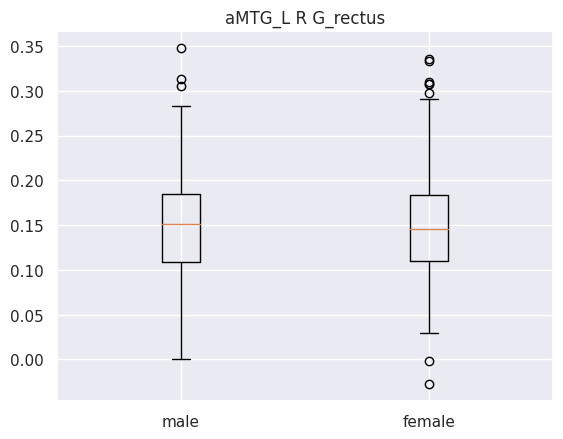

Ttest_indResult(statistic=-0.050680278730783346, pvalue=0.9595982987735558)
male mean : 0.14921290738174903
male std : 0.05910948627590685
female mean : 0.14947103351827243
female std : 0.061200009471971246


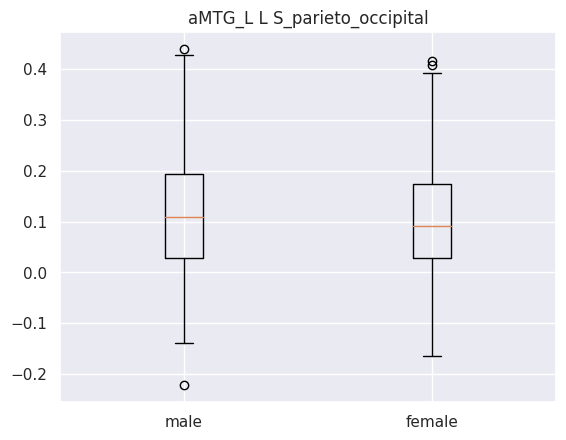

Ttest_indResult(statistic=0.8844937044320892, pvalue=0.3768080010830589)
male mean : 0.11133875940456274
male std : 0.11414917252822208
female mean : 0.10330131695813953
female std : 0.1012672300745512


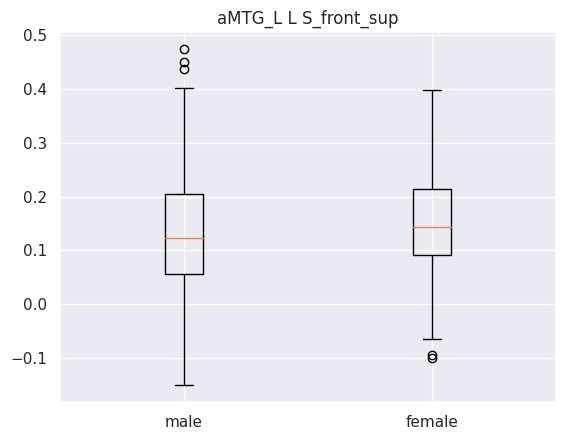

Ttest_indResult(statistic=-1.4354160996967782, pvalue=0.15172486392697015)
male mean : 0.13497622929505704
male std : 0.11129746737694128
female mean : 0.14753736321687708
female std : 0.0961519746523398


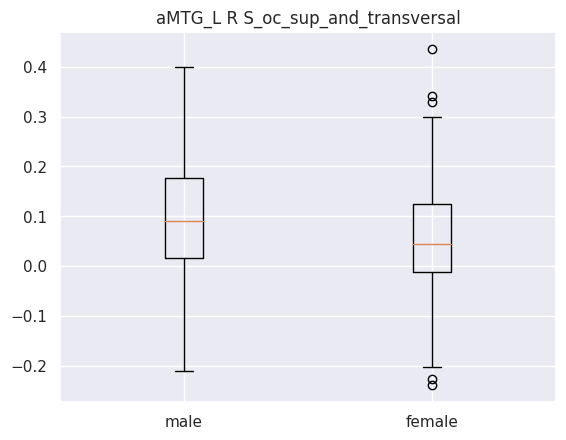

Ttest_indResult(statistic=4.340453076267227, pvalue=1.686421726368641e-05)
male mean : 0.09461966041634981
male std : 0.1152752884396305
female mean : 0.054491475181651164
female std : 0.10386960568631878


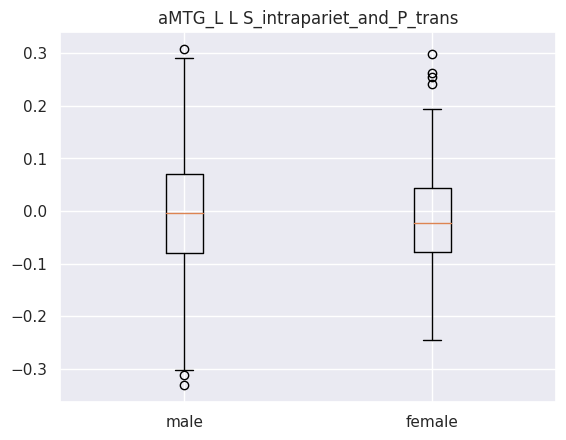

Ttest_indResult(statistic=0.9647641183387371, pvalue=0.3350779189775276)
male mean : -0.004121455086692014
male std : 0.11166920373773248
female mean : -0.012516677279534883
female std : 0.09459673974350062


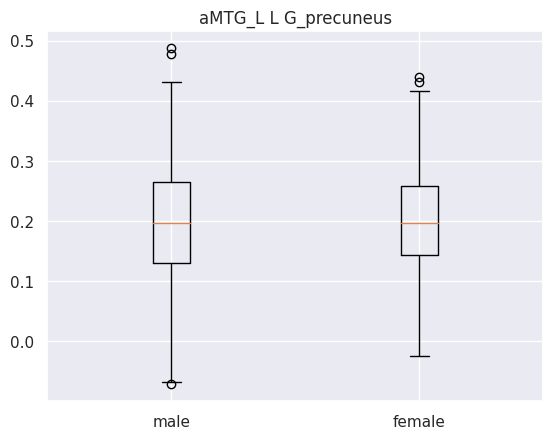

Ttest_indResult(statistic=0.34352085134667926, pvalue=0.7313351295320519)
male mean : 0.2003016257026616
male std : 0.10076302077787475
female mean : 0.1975837047968771
female std : 0.08679728049955084


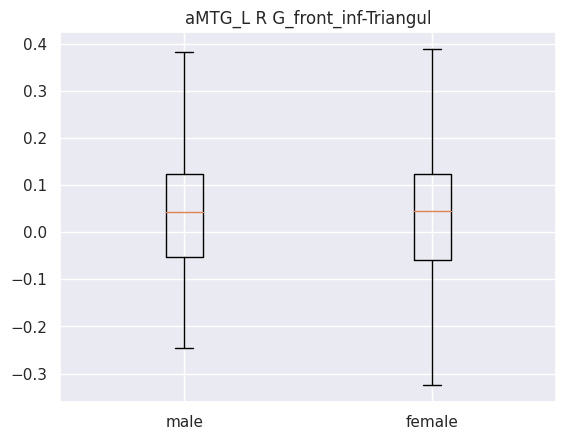

Ttest_indResult(statistic=0.12631199818411354, pvalue=0.8995301343742685)
male mean : 0.04378524430243346
male std : 0.13158479648887714
female mean : 0.042384303678737544
female std : 0.1308012611400562


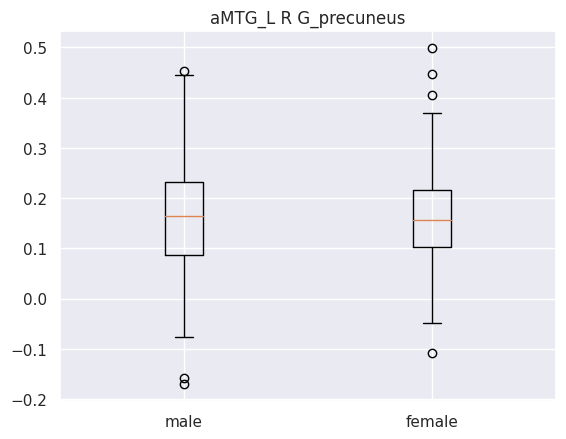

Ttest_indResult(statistic=-0.3353892597148926, pvalue=0.7374566259309934)
male mean : 0.15796897781863115
male std : 0.10510874270635935
female mean : 0.16072608648106312
female std : 0.08976109747415041
                                 Region       Men     Women   P value
0      aMTG_L - L G_oc-temp_med-Parahip  0.115305  0.110418  0.257500
1       aMTG_L - R G_pariet_inf-Angular  0.146627  0.192738  0.000005
2                   aMTG_L - R G_rectus  0.149213  0.149471  0.959598
3        aMTG_L - L S_parieto_occipital  0.111339  0.103301  0.376808
4                aMTG_L - L S_front_sup  0.134976  0.147537  0.151725
5   aMTG_L - R S_oc_sup_and_transversal  0.094620  0.054491  0.000017
6  aMTG_L - L S_intrapariet_and_P_trans -0.004121 -0.012517  0.335078
7                aMTG_L - L G_precuneus  0.200302  0.197584  0.731335
8       aMTG_L - R G_front_inf-Triangul  0.043785  0.042384  0.899530
9                aMTG_L - R G_precuneus  0.157969  0.160726  0.737457


In [61]:
rois = ["aMTG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions aMTG_R

     coefficient    seed                       labels
22      0.244687  aMTG_R      L G_oc-temp_med-Parahip
90      0.223095  aMTG_R    R G_Ins_lg_and_S_cent_ins
98      0.192974  aMTG_R       R G_pariet_inf-Angular
104     0.180849  aMTG_R                   R G_rectus
66      0.164490  aMTG_R              L S_postcentral
75      0.163681  aMTG_R      R G_and_S_occipital_inf
55      0.163259  aMTG_R  L S_intrapariet_and_P_trans
108     0.152673  aMTG_R      R G_temp_sup-Plan_polar
4       0.142937  aMTG_R   L G_and_S_transv_frontopol
135     0.142490  aMTG_R          R S_orbital_lateral
The mean accuracy : 0.8038442477876107
The standard deviation of the accuracy : 0.039244147490102514
The lower boundry of the confidance interval of the accuracy : 0.7269257187070097
The upper boundry of the confidance interval of the accuracy : 0.8807627768682116


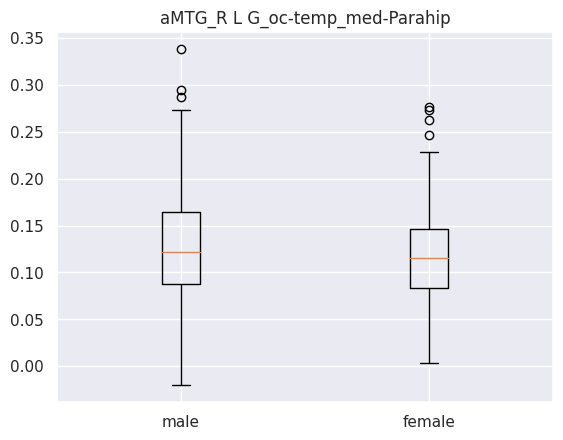

Ttest_indResult(statistic=2.0619605458315986, pvalue=0.039670656140978776)
male mean : 0.1272253816121673
male std : 0.05639247240973288
female mean : 0.11806232951096346
female std : 0.04895538358491254


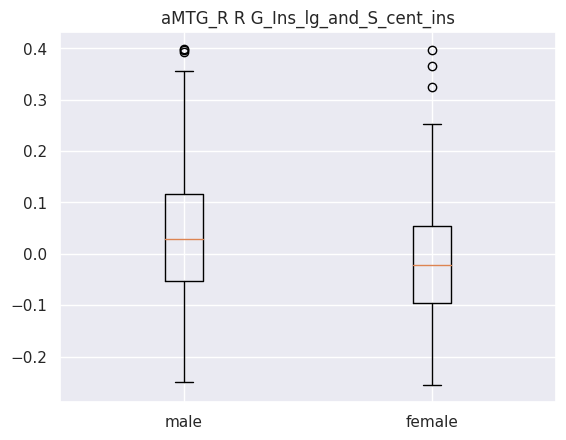

Ttest_indResult(statistic=4.892230628154193, pvalue=1.3038463843832238e-06)
male mean : 0.03623579969863118
male std : 0.1252291741990028
female mean : -0.012065202055481731
female std : 0.1088246644922351


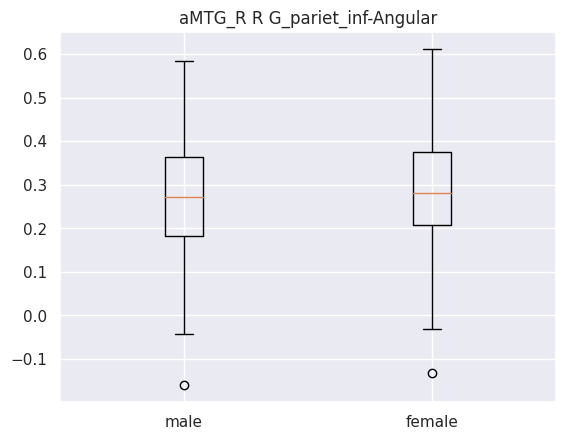

Ttest_indResult(statistic=-1.3474458962609632, pvalue=0.17837963763879625)
male mean : 0.2745868511307985
male std : 0.12784455793647628
female mean : 0.2885656095314618
female std : 0.1180010594320334


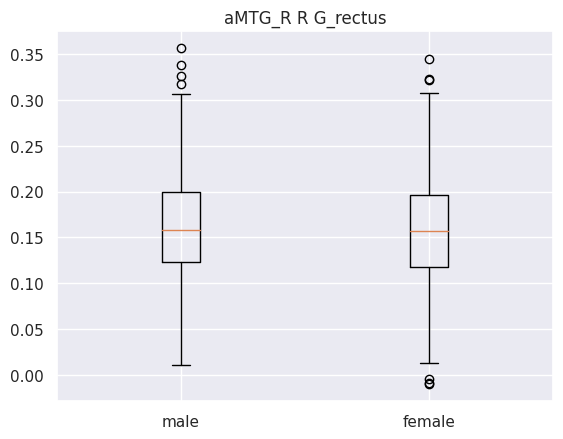

Ttest_indResult(statistic=0.25672681729231484, pvalue=0.7974836233347031)
male mean : 0.1602442236539924
male std : 0.062175408547676864
female mean : 0.1588885866717608
female std : 0.06268623105683578


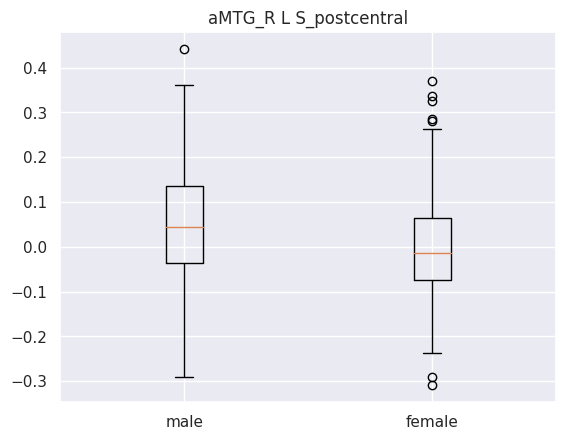

Ttest_indResult(statistic=4.256925055374874, pvalue=2.4287280099892244e-05)
male mean : 0.04534421238403042
male std : 0.1320116871677358
female mean : 0.000728705031428572
female std : 0.11644638587728438


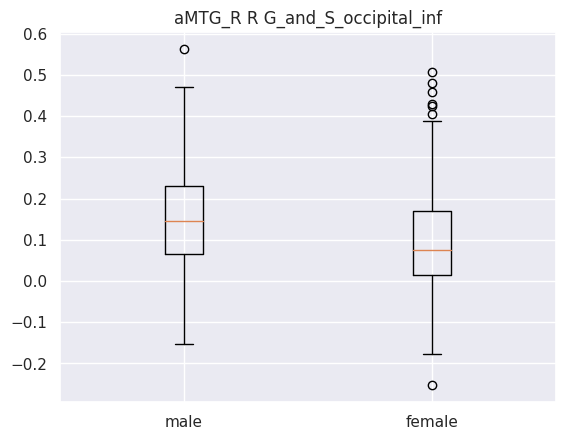

Ttest_indResult(statistic=5.746838754084861, pvalue=1.4919371944492937e-08)
male mean : 0.1548778395163498
male std : 0.12383961806520402
female mean : 0.09606502119933555
female std : 0.11852064008245364


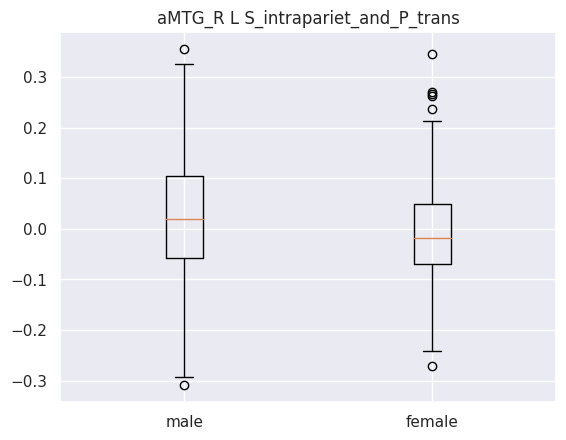

Ttest_indResult(statistic=3.0510209113028184, pvalue=0.0023882691927384963)
male mean : 0.018445383925361214
male std : 0.11377089527880688
female mean : -0.008577846181096346
female std : 0.09617201070855781


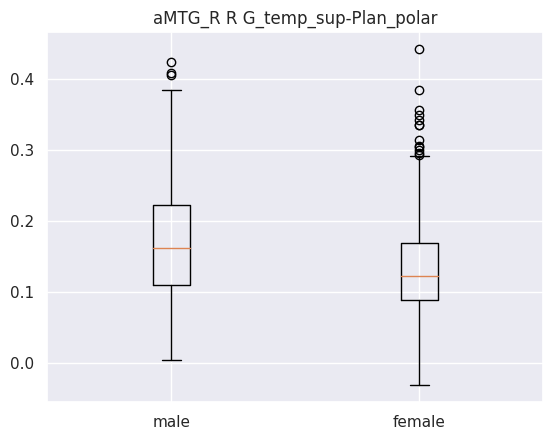

Ttest_indResult(statistic=5.308541697972609, pvalue=1.593449987883036e-07)
male mean : 0.17148337507528516
male std : 0.08089641360793041
female mean : 0.136273162079402
female std : 0.07623102186843383


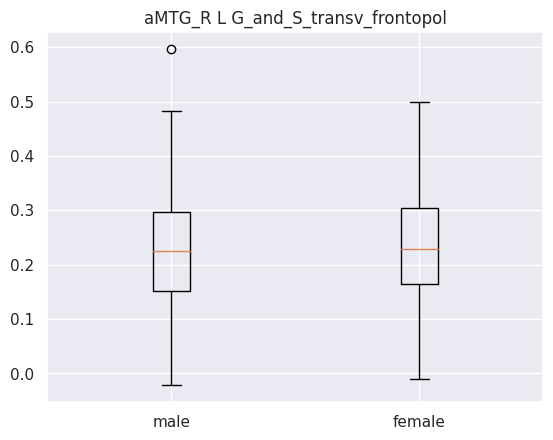

Ttest_indResult(statistic=-0.2621748360542157, pvalue=0.793282720636715)
male mean : 0.22834782620342206
male std : 0.10640876530077442
female mean : 0.23062295921428572
female std : 0.09920670714718044


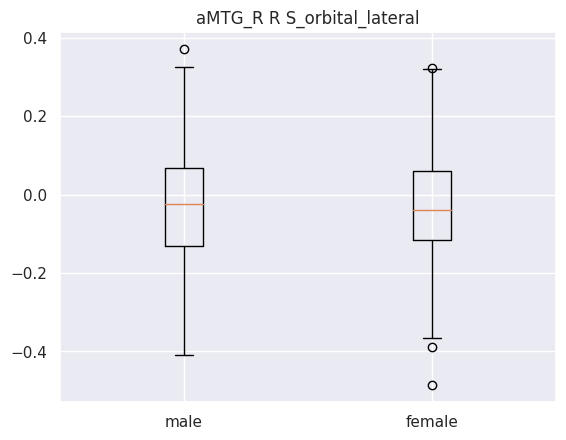

Ttest_indResult(statistic=0.3799477655046024, pvalue=0.7041277300292638)
male mean : -0.02739585445323194
male std : 0.13897809835212688
female mean : -0.0318923487744186
female std : 0.1408101730772882
                                 Region       Men     Women       P value
0      aMTG_R - L G_oc-temp_med-Parahip  0.127225  0.118062  3.967066e-02
1    aMTG_R - R G_Ins_lg_and_S_cent_ins  0.036236 -0.012065  1.303846e-06
2       aMTG_R - R G_pariet_inf-Angular  0.274587  0.288566  1.783796e-01
3                   aMTG_R - R G_rectus  0.160244  0.158889  7.974836e-01
4              aMTG_R - L S_postcentral  0.045344  0.000729  2.428728e-05
5      aMTG_R - R G_and_S_occipital_inf  0.154878  0.096065  1.491937e-08
6  aMTG_R - L S_intrapariet_and_P_trans  0.018445 -0.008578  2.388269e-03
7      aMTG_R - R G_temp_sup-Plan_polar  0.171483  0.136273  1.593450e-07
8   aMTG_R - L G_and_S_transv_frontopol  0.228348  0.230623  7.932827e-01
9          aMTG_R - R S_orbital_lateral -0.027396 -0.0318

In [62]:
rois = ["aMTG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_L

     coefficient     seed                       labels
20      0.189302  opIFG_L      L G_oc-temp_lat-fusifor
47      0.182472  opIFG_L      L S_circular_insula_inf
72      0.177692  opIFG_L             L S_temporal_sup
60      0.171919  opIFG_L  L S_oc-temp_med_and_Lingual
91      0.170919  opIFG_L            R G_insular_short
144     0.170130  opIFG_L              R S_subparietal
40      0.164383  opIFG_L               L Lat_Fis-post
1       0.151775  opIFG_L      L G_and_S_occipital_inf
89      0.148907  opIFG_L                R G_front_sup
64      0.134829  opIFG_L        L S_parieto_occipital
The mean accuracy : 0.8340097345132743
The standard deviation of the accuracy : 0.036209078636102635
The lower boundry of the confidance interval of the accuracy : 0.7630399403865131
The upper boundry of the confidance interval of the accuracy : 0.9049795286400355


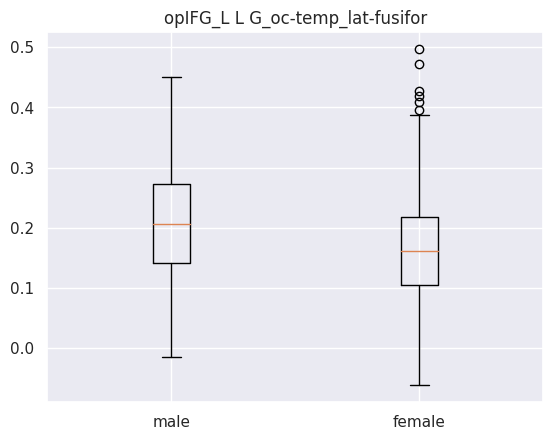

Ttest_indResult(statistic=5.698927511987025, pvalue=1.9476660856975242e-08)
male mean : 0.21165041260456274
male std : 0.09558055806544623
female mean : 0.1668287685760797
female std : 0.09071059585266414


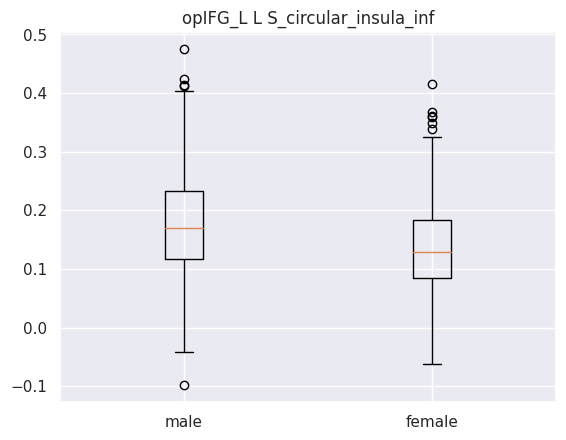

Ttest_indResult(statistic=5.793990901906812, pvalue=1.1455922176287184e-08)
male mean : 0.17968730860456272
male std : 0.08982294121388894
female mean : 0.13831419359568106
female std : 0.07945500381706048


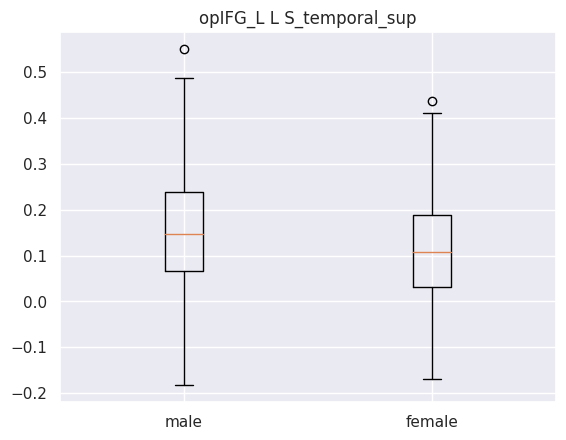

Ttest_indResult(statistic=4.104919666823164, pvalue=4.644482275203613e-05)
male mean : 0.15756035950874525
male std : 0.12779665808907587
female mean : 0.11516167434405318
female std : 0.116995762417676


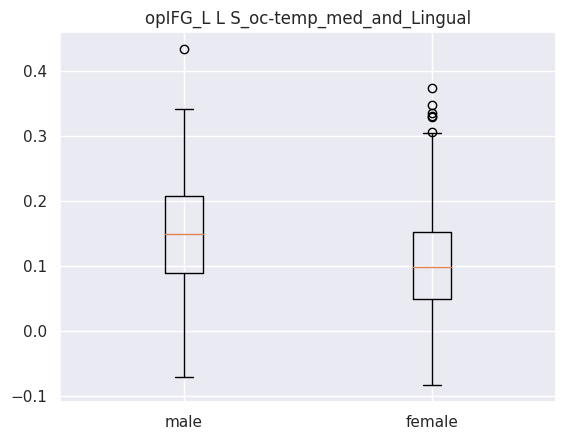

Ttest_indResult(statistic=5.979839353972038, pvalue=3.974325533230207e-09)
male mean : 0.1488611000961977
male std : 0.08275130578679875
female mean : 0.10701805680602991
female std : 0.0827545429881859


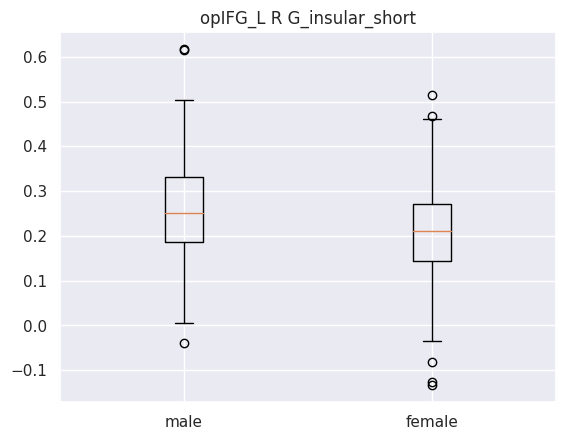

Ttest_indResult(statistic=5.4808703280162065, pvalue=6.398857490240382e-08)
male mean : 0.25729847525475286
male std : 0.10255773714008104
female mean : 0.20946871466478406
female std : 0.10376640995486473


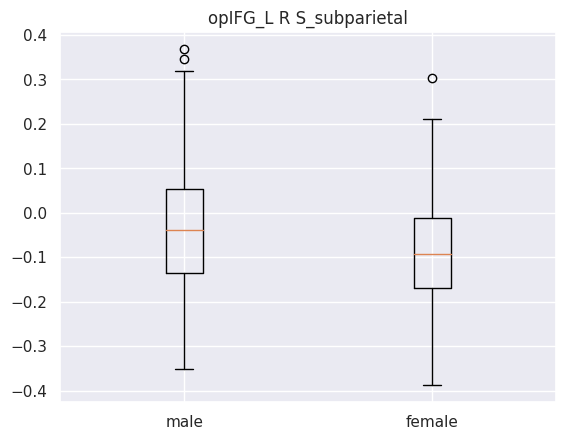

Ttest_indResult(statistic=4.627538320714266, pvalue=4.59863706792552e-06)
male mean : -0.0332647789439924
male std : 0.13808114412316164
female mean : -0.08209271020398672
female std : 0.11188499200043661


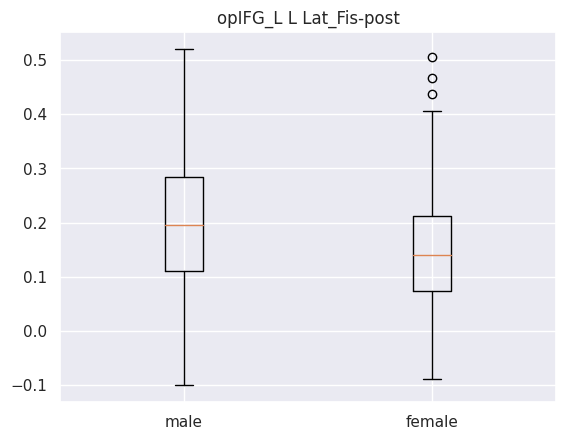

Ttest_indResult(statistic=5.935387024296681, pvalue=5.1325420089517246e-09)
male mean : 0.2050836814703422
male std : 0.11767179108479932
female mean : 0.15007587232843853
female std : 0.10203339475287607


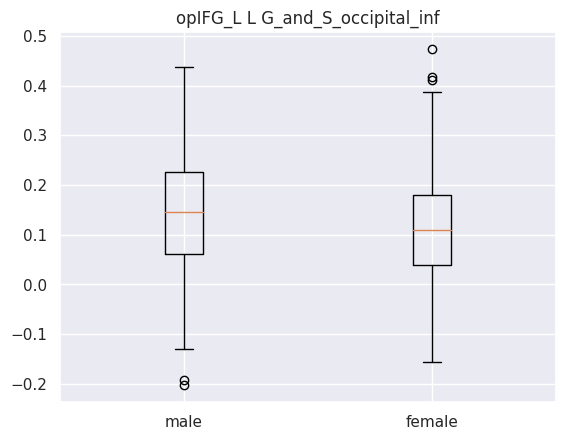

Ttest_indResult(statistic=3.3566638640413826, pvalue=0.000842207438429869)
male mean : 0.14831989778022814
male std : 0.12463081174073931
female mean : 0.11545700281893687
female std : 0.10745927496138906


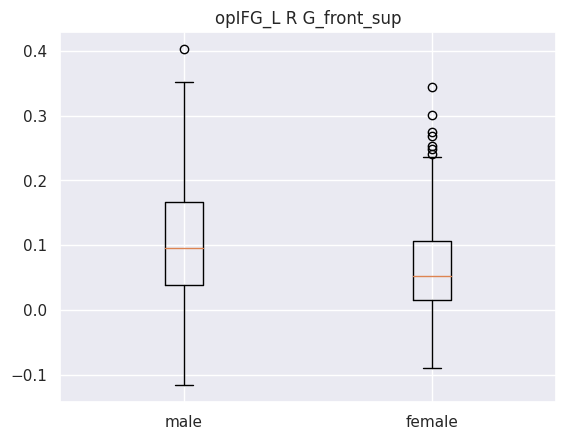

Ttest_indResult(statistic=5.683026273047372, pvalue=2.126943803812892e-08)
male mean : 0.1052475728106464
male std : 0.08960183901383532
female mean : 0.06627460454425249
female std : 0.07286902176856629


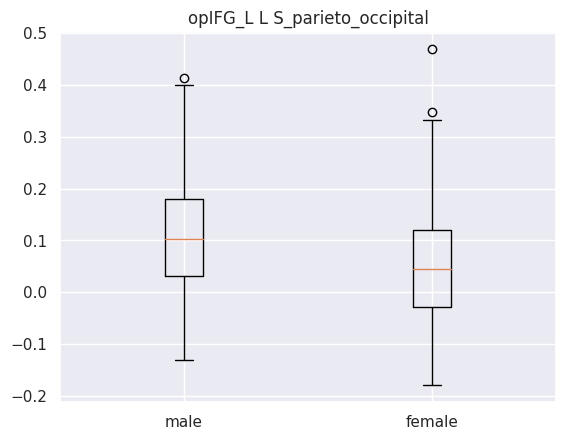

Ttest_indResult(statistic=6.503523668812626, pvalue=1.7355351061785972e-10)
male mean : 0.10978782784771862
male std : 0.10910224511601631
female mean : 0.05152286066817276
female std : 0.10312061557532284
                                  Region       Men     Women       P value
0      opIFG_L - L G_oc-temp_lat-fusifor  0.211650  0.166829  1.947666e-08
1      opIFG_L - L S_circular_insula_inf  0.179687  0.138314  1.145592e-08
2             opIFG_L - L S_temporal_sup  0.157560  0.115162  4.644482e-05
3  opIFG_L - L S_oc-temp_med_and_Lingual  0.148861  0.107018  3.974326e-09
4            opIFG_L - R G_insular_short  0.257298  0.209469  6.398857e-08
5              opIFG_L - R S_subparietal -0.033265 -0.082093  4.598637e-06
6               opIFG_L - L Lat_Fis-post  0.205084  0.150076  5.132542e-09
7      opIFG_L - L G_and_S_occipital_inf  0.148320  0.115457  8.422074e-04
8                opIFG_L - R G_front_sup  0.105248  0.066275  2.126944e-08
9        opIFG_L - L S_parieto_occipital  0.

In [63]:
rois = ["opIFG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_R

     coefficient     seed                       labels
47      0.257032  opIFG_R      L S_circular_insula_inf
60      0.207552  opIFG_R  L S_oc-temp_med_and_Lingual
121     0.205102  opIFG_R      R S_circular_insula_inf
91      0.191789  opIFG_R            R G_insular_short
89      0.177847  opIFG_R                R G_front_sup
15      0.173893  opIFG_R                L G_front_sup
80      0.169734  opIFG_R     R G_and_S_cingul-Mid-Ant
125     0.165114  opIFG_R                R S_front_inf
108     0.164153  opIFG_R      R G_temp_sup-Plan_polar
41      0.157768  opIFG_R             L Pole_occipital
The mean accuracy : 0.8159159292035398
The standard deviation of the accuracy : 0.03799449876918694
The lower boundry of the confidance interval of the accuracy : 0.7414467116159335
The upper boundry of the confidance interval of the accuracy : 0.8903851467911462


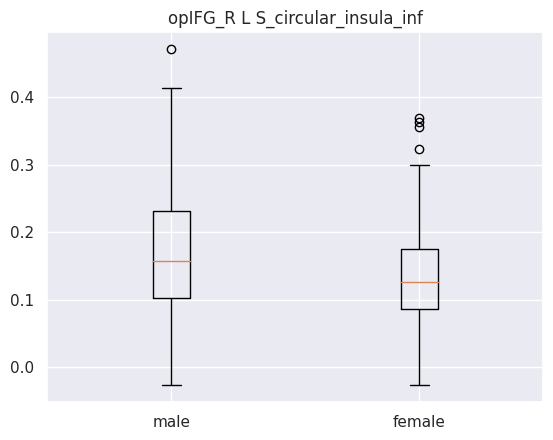

Ttest_indResult(statistic=4.729506412940881, pvalue=2.84980032551188e-06)
male mean : 0.16831194070988592
male std : 0.08857256780970121
female mean : 0.13581089123421927
female std : 0.07430472106915549


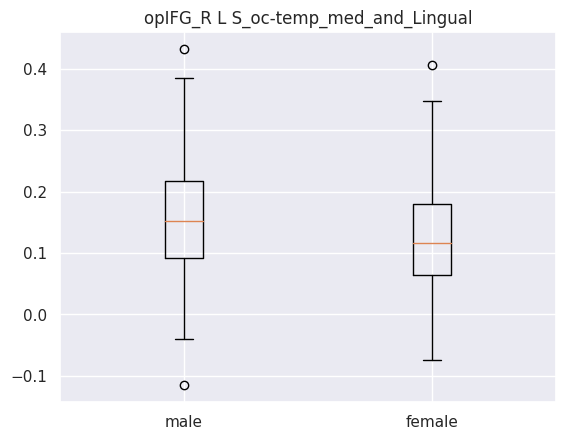

Ttest_indResult(statistic=4.683575774370304, pvalue=3.539150807108733e-06)
male mean : 0.15626952140722436
male std : 0.09076863914735202
female mean : 0.12206103295259137
female std : 0.08235156931391527


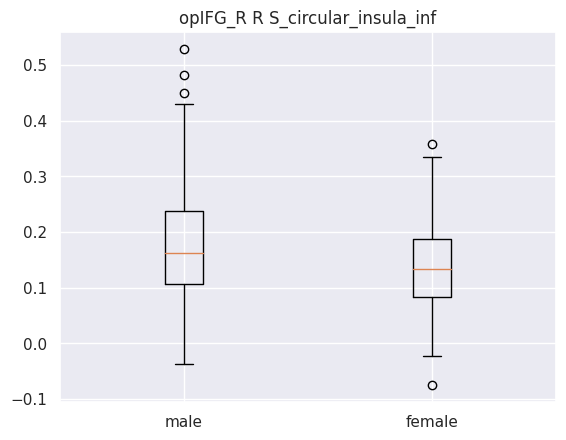

Ttest_indResult(statistic=4.942755677875544, pvalue=1.0181350777303932e-06)
male mean : 0.17446574005114068
male std : 0.09230872687485497
female mean : 0.1389954879870432
female std : 0.07778669492425484


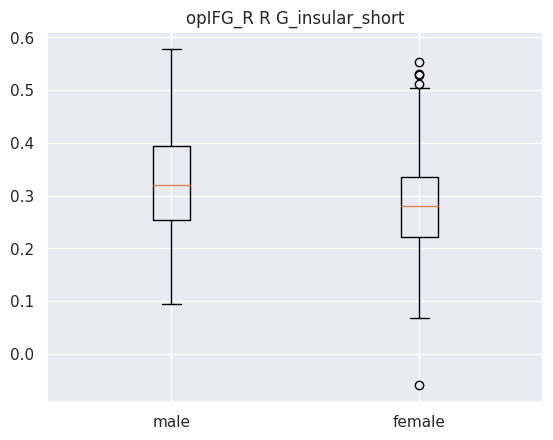

Ttest_indResult(statistic=4.755239251404364, pvalue=2.5221004207170377e-06)
male mean : 0.3230140808745247
male std : 0.09676265794418758
female mean : 0.28459807252159475
female std : 0.09446074604336126


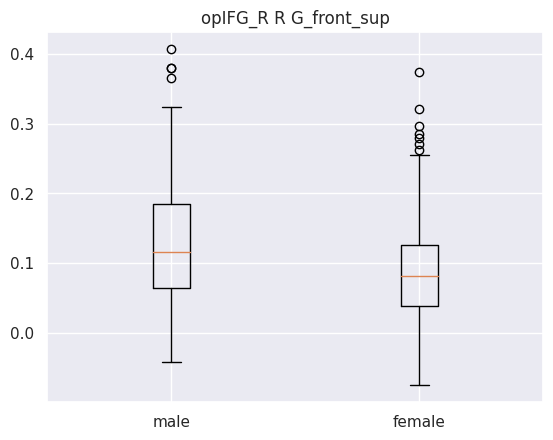

Ttest_indResult(statistic=5.745692358467039, pvalue=1.501515937789587e-08)
male mean : 0.1265730028612167
male std : 0.08260435605801614
female mean : 0.08889572881594685
female std : 0.07284917853618297


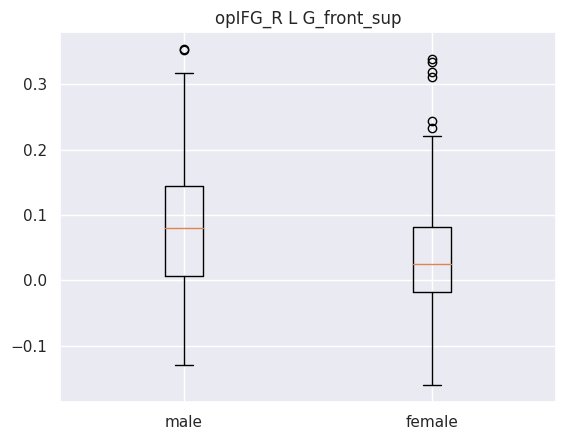

Ttest_indResult(statistic=5.840874265006819, pvalue=8.794027366847957e-09)
male mean : 0.07910377020205323
male std : 0.091464100075273
female mean : 0.03652195184581396
female std : 0.08135719231531187


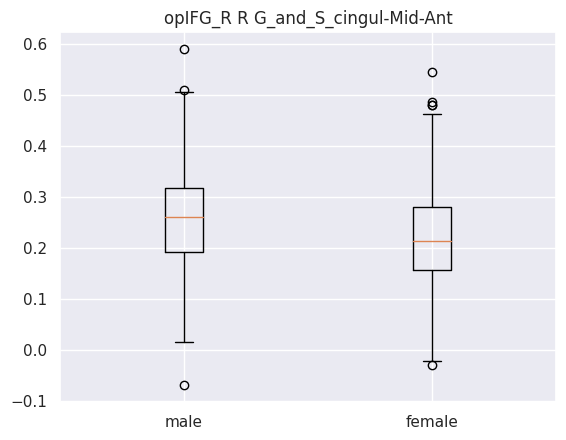

Ttest_indResult(statistic=4.315955845337449, pvalue=1.878004856996765e-05)
male mean : 0.2591957626121673
male std : 0.10347717348701288
female mean : 0.22244813224916943
female std : 0.09819716159475382


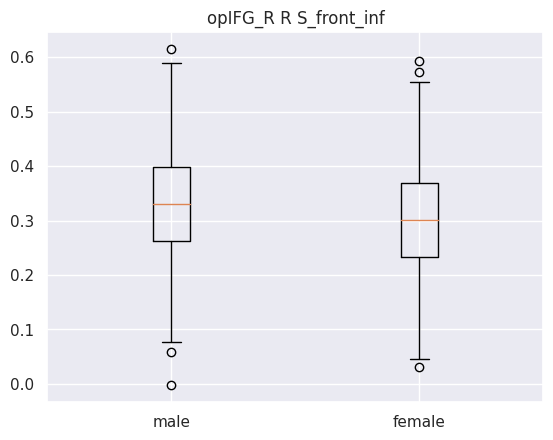

Ttest_indResult(statistic=3.5795531005665557, pvalue=0.0003739476663251471)
male mean : 0.33087263080000007
male std : 0.09831999322618676
female mean : 0.29969864851495015
female std : 0.10691152795323068


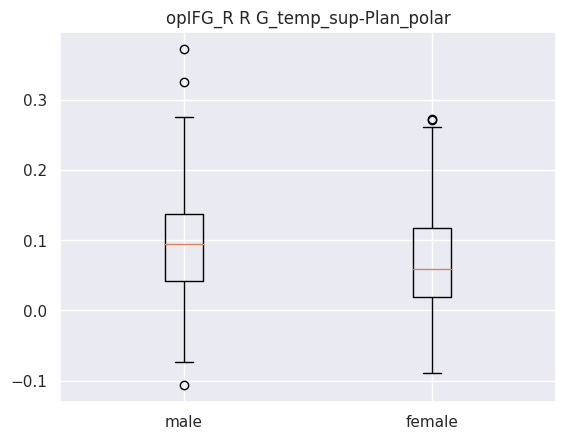

Ttest_indResult(statistic=3.998178487567644, pvalue=7.235199191609884e-05)
male mean : 0.09452694148326996
male std : 0.07617182305141224
female mean : 0.07004874881162791
female std : 0.06894506297581188


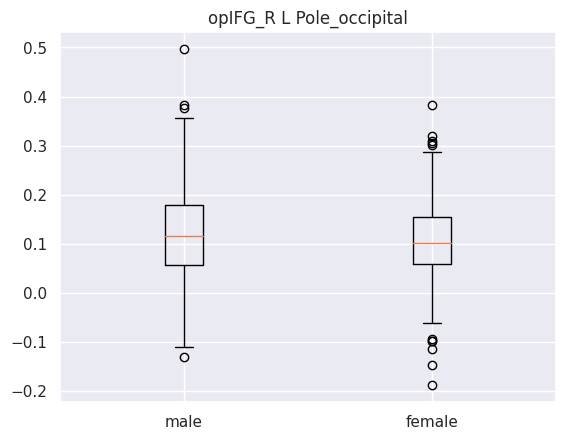

Ttest_indResult(statistic=2.2602421008901716, pvalue=0.0241880831961621)
male mean : 0.12250584151026614
male std : 0.0975005774677038
female mean : 0.10541738842285715
female std : 0.08169249239746618
                                  Region       Men     Women       P value
0      opIFG_R - L S_circular_insula_inf  0.168312  0.135811  2.849800e-06
1  opIFG_R - L S_oc-temp_med_and_Lingual  0.156270  0.122061  3.539151e-06
2      opIFG_R - R S_circular_insula_inf  0.174466  0.138995  1.018135e-06
3            opIFG_R - R G_insular_short  0.323014  0.284598  2.522100e-06
4                opIFG_R - R G_front_sup  0.126573  0.088896  1.501516e-08
5                opIFG_R - L G_front_sup  0.079104  0.036522  8.794027e-09
6     opIFG_R - R G_and_S_cingul-Mid-Ant  0.259196  0.222448  1.878005e-05
7                opIFG_R - R S_front_inf  0.330873  0.299699  3.739477e-04
8      opIFG_R - R G_temp_sup-Plan_polar  0.094527  0.070049  7.235199e-05
9             opIFG_R - L Pole_occipital  0.1225

In [64]:
rois = ["opIFG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions pITG_L

     coefficient    seed                       labels
47      0.240166  pITG_L      L S_circular_insula_inf
26      0.238076  pITG_L             L G_parietal_sup
9       0.203500  pITG_L      L G_cingul-Post-ventral
20      0.200224  pITG_L      L G_oc-temp_lat-fusifor
55      0.181368  pITG_L  L S_intrapariet_and_P_trans
83      0.172106  pITG_L      R G_cingul-Post-ventral
75      0.167198  pITG_L      R G_and_S_occipital_inf
125     0.164939  pITG_L                R S_front_inf
60      0.154554  pITG_L  L S_oc-temp_med_and_Lingual
86      0.153020  pITG_L        R G_front_inf-Orbital
The mean accuracy : 0.8111796460176992
The standard deviation of the accuracy : 0.03836824951793555
The lower boundry of the confidance interval of the accuracy : 0.7359778769625456
The upper boundry of the confidance interval of the accuracy : 0.8863814150728528


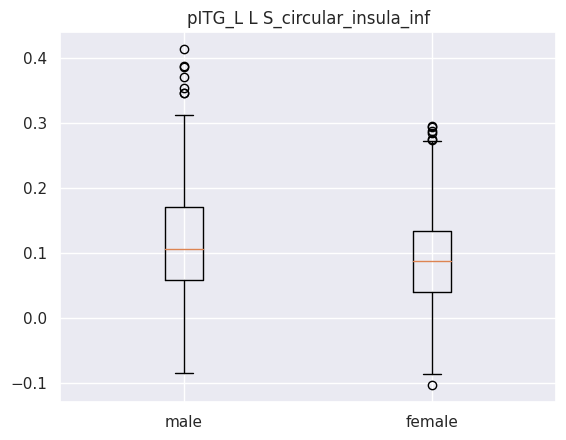

Ttest_indResult(statistic=3.7195183926587134, pvalue=0.00021963865781551026)
male mean : 0.1174053472373384
male std : 0.08606189513888665
female mean : 0.09239644204584717
female std : 0.07332099633027676


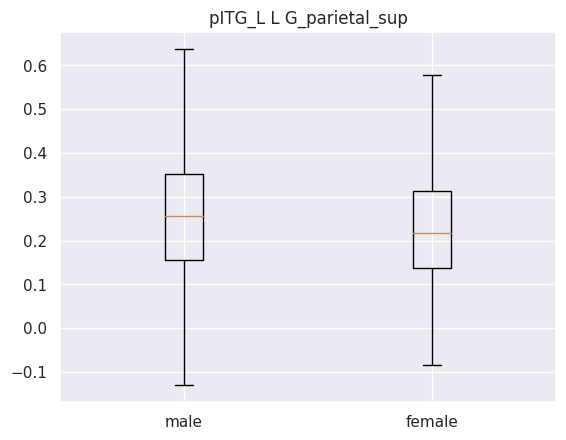

Ttest_indResult(statistic=2.0348237485458296, pvalue=0.04233743219572547)
male mean : 0.25056911626197714
male std : 0.14008685738222976
female mean : 0.22777261343820598
female std : 0.1254813999066985


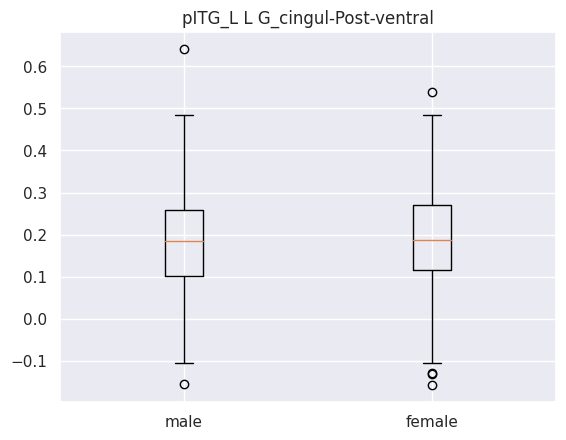

Ttest_indResult(statistic=-0.6639053665916427, pvalue=0.5070231460745944)
male mean : 0.18444210613802278
male std : 0.11264807940923946
female mean : 0.19087066787209303
female std : 0.11611943916831628


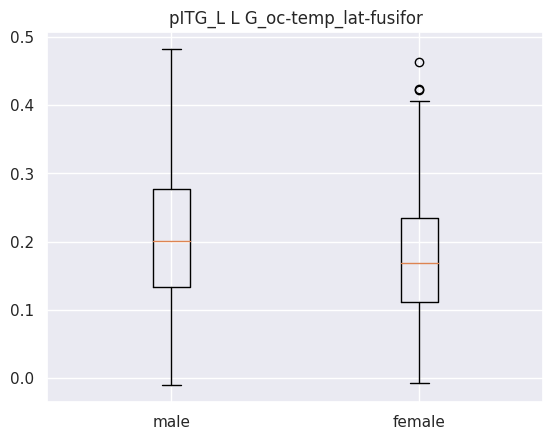

Ttest_indResult(statistic=3.2436073154022718, pvalue=0.001250320411852697)
male mean : 0.2056987803380228
male std : 0.0949520263388171
female mean : 0.18023744266279068
female std : 0.09094138289806177


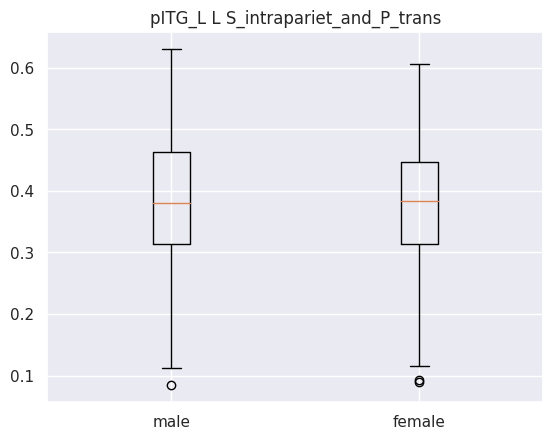

Ttest_indResult(statistic=0.27040597084376106, pvalue=0.7869472193855935)
male mean : 0.38125740577946765
male std : 0.107535777846271
female mean : 0.37889768367441856
female std : 0.0992636491621393


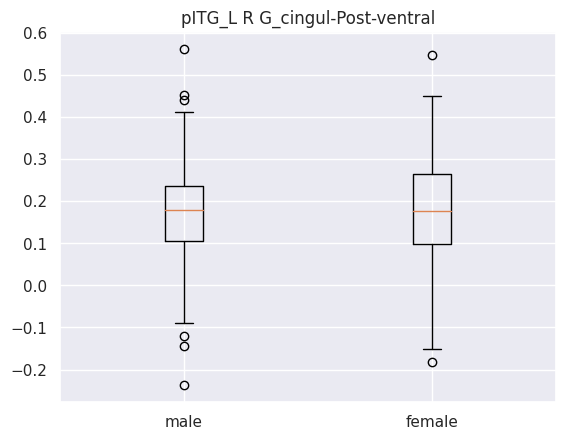

Ttest_indResult(statistic=-0.7087886870276421, pvalue=0.47874952082168243)
male mean : 0.17141985658456652
male std : 0.11182081650600385
female mean : 0.17828767616757477
female std : 0.11695861702316826


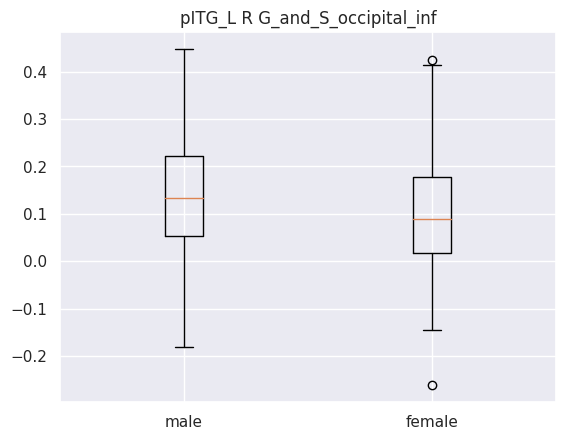

Ttest_indResult(statistic=3.1426765548050595, pvalue=0.0017623399666327859)
male mean : 0.13541462136387833
male std : 0.12025345869257073
female mean : 0.10348527198348836
female std : 0.12006823679231758


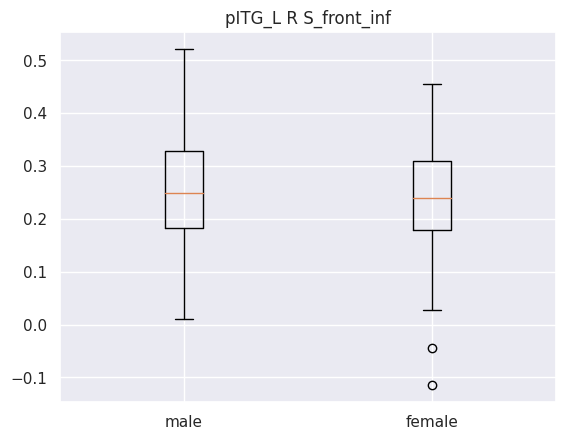

Ttest_indResult(statistic=2.0737617244228934, pvalue=0.0385563187021098)
male mean : 0.25845339727756655
male std : 0.09789218472922548
female mean : 0.24180414809966774
female std : 0.09229872422717747


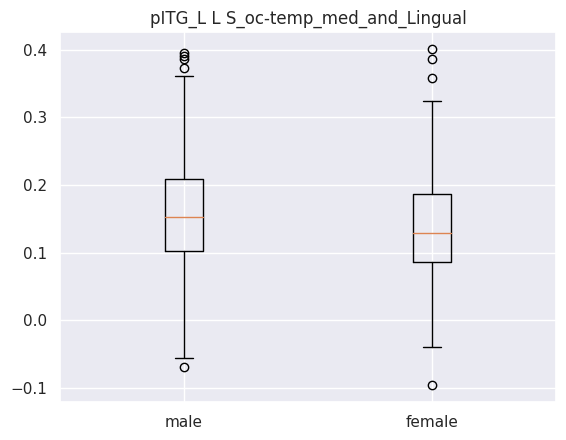

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
male std : 0.08334523805349907
female mean : 0.13959590949933556
female std : 0.07802101521527612


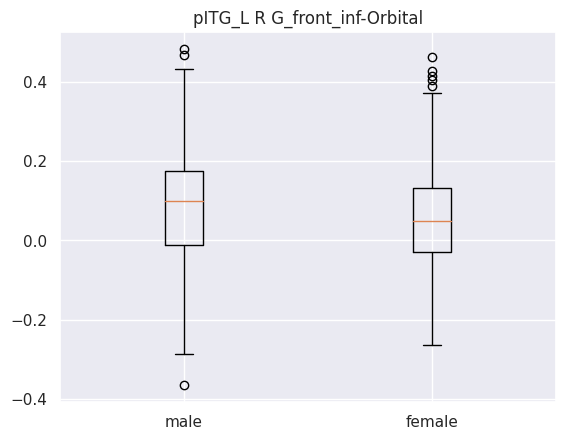

Ttest_indResult(statistic=2.4606260312415023, pvalue=0.014169135796902566)
male mean : 0.08827093163688214
male std : 0.14230262222275855
female mean : 0.05931472846877077
female std : 0.13637430223397143
                                 Region       Men     Women   P value
0      pITG_L - L S_circular_insula_inf  0.117405  0.092396  0.000220
1             pITG_L - L G_parietal_sup  0.250569  0.227773  0.042337
2      pITG_L - L G_cingul-Post-ventral  0.184442  0.190871  0.507023
3      pITG_L - L G_oc-temp_lat-fusifor  0.205699  0.180237  0.001250
4  pITG_L - L S_intrapariet_and_P_trans  0.381257  0.378898  0.786947
5      pITG_L - R G_cingul-Post-ventral  0.171420  0.178288  0.478750
6      pITG_L - R G_and_S_occipital_inf  0.135415  0.103485  0.001762
7                pITG_L - R S_front_inf  0.258453  0.241804  0.038556
8  pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  0.002643
9        pITG_L - R G_front_inf-Orbital  0.088271  0.059315  0.014169


In [65]:
rois = ["pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions pITG_R

     coefficient    seed                   labels
20      0.268079  pITG_R  L G_oc-temp_lat-fusifor
72      0.258256  pITG_R         L S_temporal_sup
83      0.229686  pITG_R  R G_cingul-Post-ventral
47      0.206474  pITG_R  L S_circular_insula_inf
84      0.189709  pITG_R               R G_cuneus
108     0.172699  pITG_R  R G_temp_sup-Plan_polar
125     0.172169  pITG_R            R S_front_inf
106     0.160596  pITG_R  R G_temp_sup-G_T_transv
91      0.157899  pITG_R        R G_insular_short
144     0.157739  pITG_R          R S_subparietal
The mean accuracy : 0.8024017699115045
The standard deviation of the accuracy : 0.038776032628394415
The lower boundry of the confidance interval of the accuracy : 0.7264007459598514
The upper boundry of the confidance interval of the accuracy : 0.8784027938631576


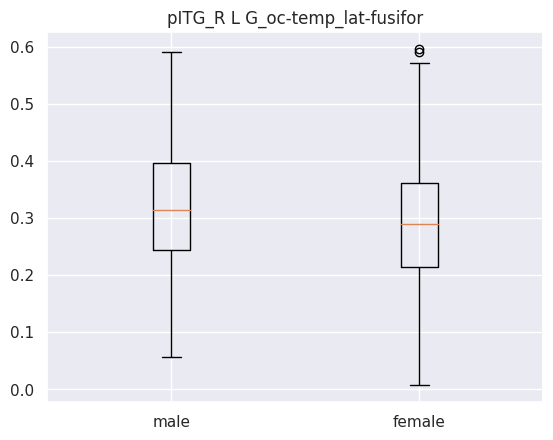

Ttest_indResult(statistic=2.810268986820924, pvalue=0.0051225200608808474)
male mean : 0.31478116888212926
male std : 0.11000102327816882
female mean : 0.2893303569966777
female std : 0.10450615876501394


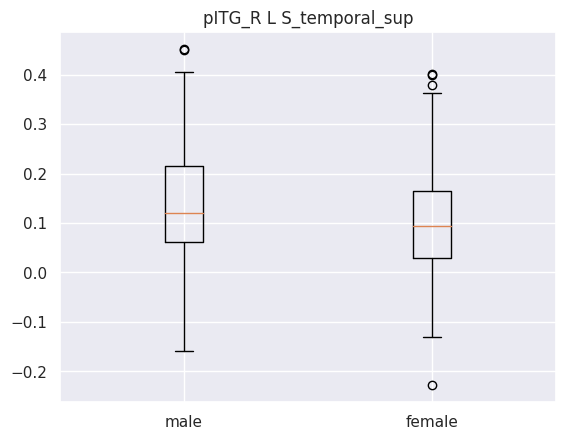

Ttest_indResult(statistic=4.196741356631083, pvalue=3.1469933747888905e-05)
male mean : 0.13739067075551334
male std : 0.11150382462376025
female mean : 0.09954083086165548
female std : 0.10224021375654369


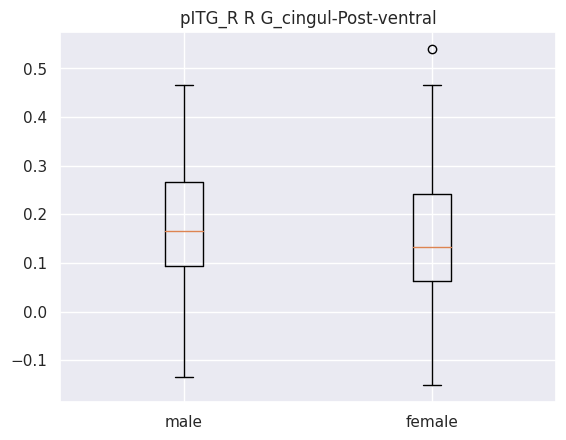

Ttest_indResult(statistic=2.256297345157703, pvalue=0.024435481782569664)
male mean : 0.1744766429752852
male std : 0.12132968449125979
female mean : 0.15124980597607973
female std : 0.12210294696125819


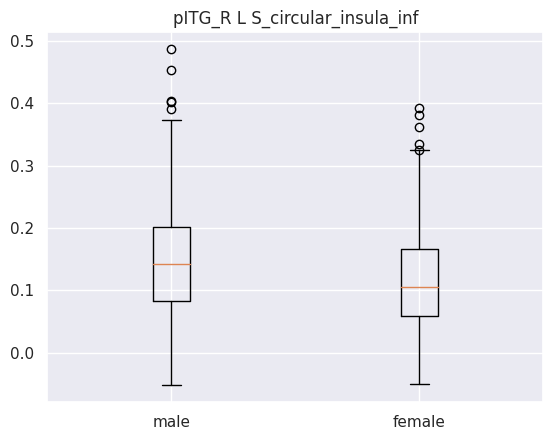

Ttest_indResult(statistic=4.781913144179267, pvalue=2.220814202786064e-06)
male mean : 0.15037180967528518
male std : 0.09196590825401321
female mean : 0.1155669789617608
female std : 0.08058036286207322


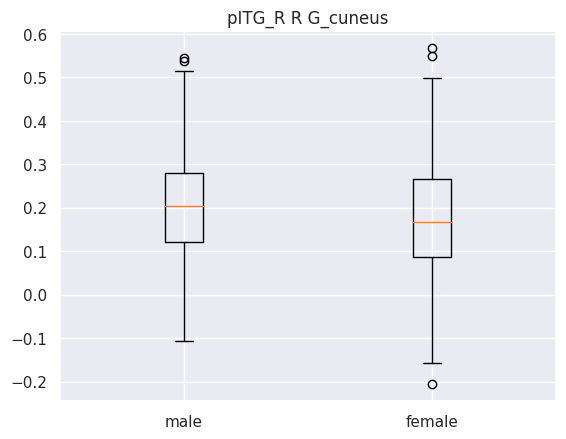

Ttest_indResult(statistic=2.741944633725931, pvalue=0.006302259674511262)
male mean : 0.20491106910646387
male std : 0.1253061895987554
female mean : 0.17536686928538206
female std : 0.12925281281347495


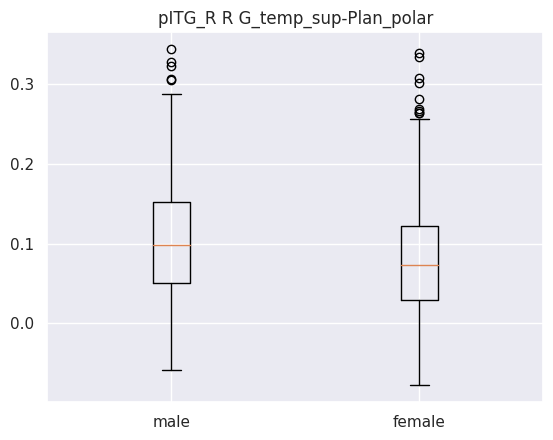

Ttest_indResult(statistic=3.829041740563084, pvalue=0.00014311201699602173)
male mean : 0.10721168719125476
male std : 0.07701199955956235
female mean : 0.08294021107918272
female std : 0.07312878001906238


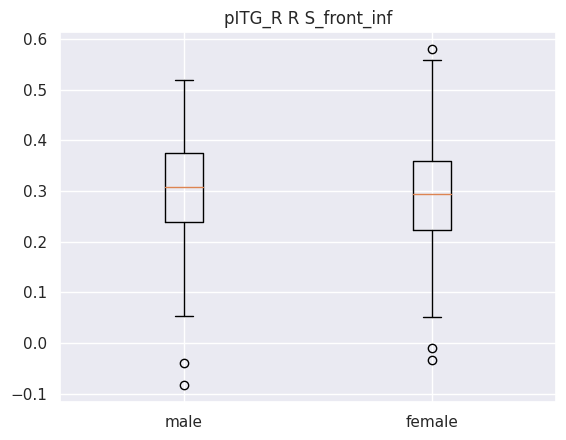

Ttest_indResult(statistic=1.6379189328233394, pvalue=0.10199833222671245)
male mean : 0.3043051077718631
male std : 0.0983610871491745
female mean : 0.29073446122923585
female std : 0.09765466159601431


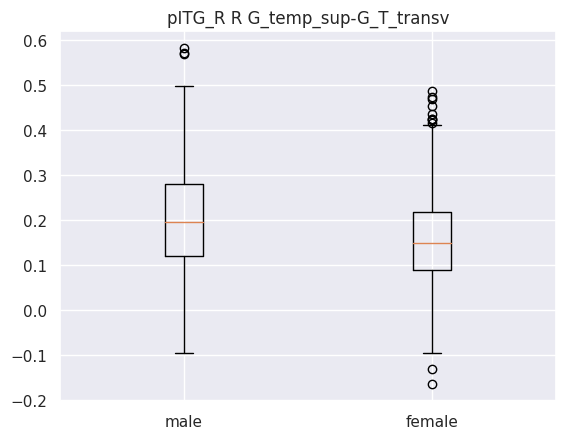

Ttest_indResult(statistic=4.858246945744738, pvalue=1.5379842834630926e-06)
male mean : 0.20724551101216732
male std : 0.12132483078283902
female mean : 0.16001330873255815
female std : 0.10912756866493428


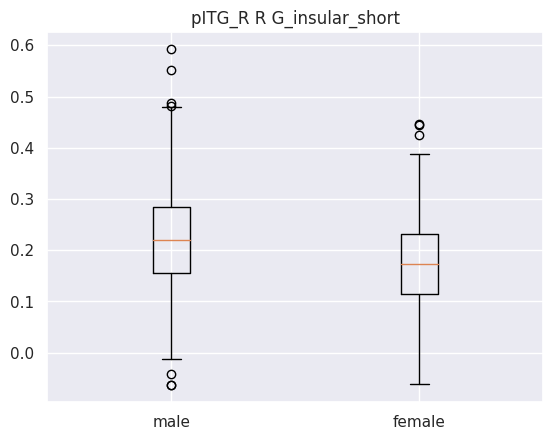

Ttest_indResult(statistic=5.697103263903745, pvalue=1.9674615344309902e-08)
male mean : 0.2223536750768061
male std : 0.10572708474473759
female mean : 0.1753717551358804
female std : 0.08975183305485177


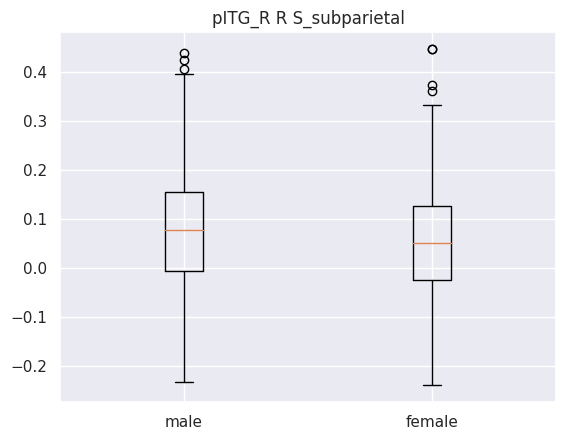

Ttest_indResult(statistic=2.373555580211466, pvalue=0.01795294789038577)
male mean : 0.08108263206159695
male std : 0.1272016237473174
female mean : 0.05675384893664452
female std : 0.11573903683180534
                             Region       Men     Women       P value
0  pITG_R - L G_oc-temp_lat-fusifor  0.314781  0.289330  5.122520e-03
1         pITG_R - L S_temporal_sup  0.137391  0.099541  3.146993e-05
2  pITG_R - R G_cingul-Post-ventral  0.174477  0.151250  2.443548e-02
3  pITG_R - L S_circular_insula_inf  0.150372  0.115567  2.220814e-06
4               pITG_R - R G_cuneus  0.204911  0.175367  6.302260e-03
5  pITG_R - R G_temp_sup-Plan_polar  0.107212  0.082940  1.431120e-04
6            pITG_R - R S_front_inf  0.304305  0.290734  1.019983e-01
7  pITG_R - R G_temp_sup-G_T_transv  0.207246  0.160013  1.537984e-06
8        pITG_R - R G_insular_short  0.222354  0.175372  1.967462e-08
9          pITG_R - R S_subparietal  0.081083  0.056754  1.795295e-02


In [34]:
rois = ["pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_L

     coefficient          seed                       labels
60      0.318987  planumtemp_L  L S_oc-temp_med_and_Lingual
20      0.221324  planumtemp_L      L G_oc-temp_lat-fusifor
108     0.205293  planumtemp_L      R G_temp_sup-Plan_polar
15      0.204476  planumtemp_L                L G_front_sup
94      0.177732  planumtemp_L      R G_oc-temp_lat-fusifor
43      0.171312  planumtemp_L                L S_calcarine
99      0.168395  planumtemp_L      R G_pariet_inf-Supramar
89      0.163267  planumtemp_L                R G_front_sup
88      0.162727  planumtemp_L             R G_front_middle
30      0.156225  planumtemp_L                   L G_rectus
The mean accuracy : 0.8016619469026549
The standard deviation of the accuracy : 0.03884471028280589
The lower boundry of the confidance interval of the accuracy : 0.7255263147483554
The upper boundry of the confidance interval of the accuracy : 0.8777975790569544


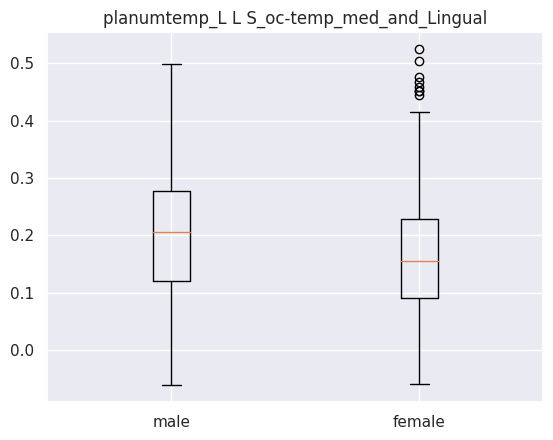

Ttest_indResult(statistic=3.5535200840172108, pvalue=0.0004120710964530877)
male mean : 0.20138468446653993
male std : 0.10697193315909369
female mean : 0.1691071645282392
female std : 0.10781293661679399


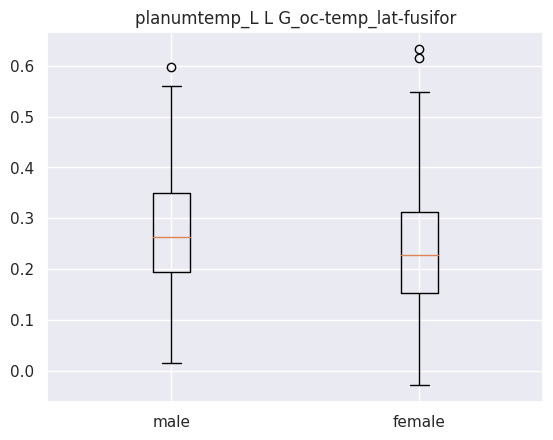

Ttest_indResult(statistic=3.8640363181268467, pvalue=0.00012453051309743143)
male mean : 0.273934721608365
male std : 0.11618899538515358
female mean : 0.23664216192325582
female std : 0.11231573519663951


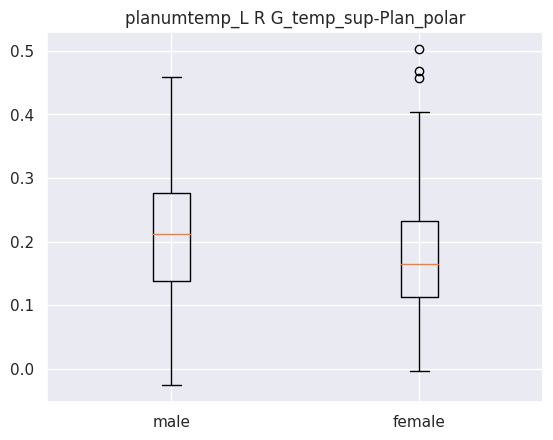

Ttest_indResult(statistic=4.754095906522838, pvalue=2.535856882720888e-06)
male mean : 0.2124789285969582
male std : 0.09186190010679225
female mean : 0.1759663873843854
female std : 0.08991669369361606


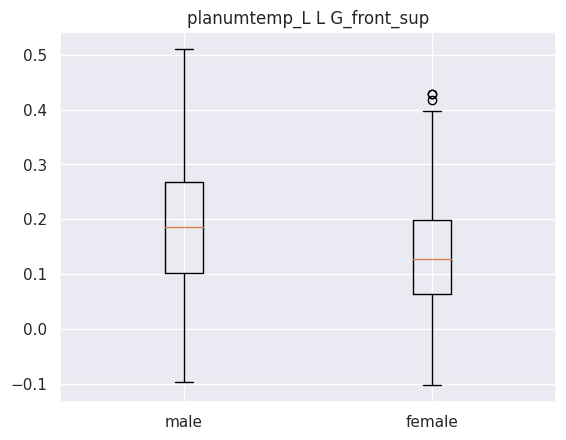

Ttest_indResult(statistic=5.407175582759948, pvalue=9.480994088922564e-08)
male mean : 0.1847222246946768
male std : 0.10853704509636099
female mean : 0.1378197862071096
female std : 0.0970820399251973


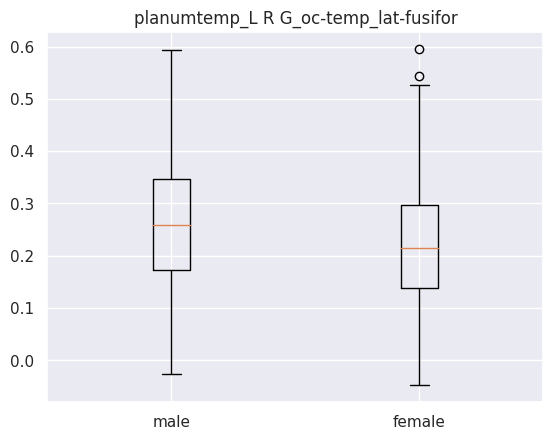

Ttest_indResult(statistic=3.691296784762628, pvalue=0.00024485362854647204)
male mean : 0.26207624817110264
male std : 0.11851119925720778
female mean : 0.22636467401827245
female std : 0.1107105284122811


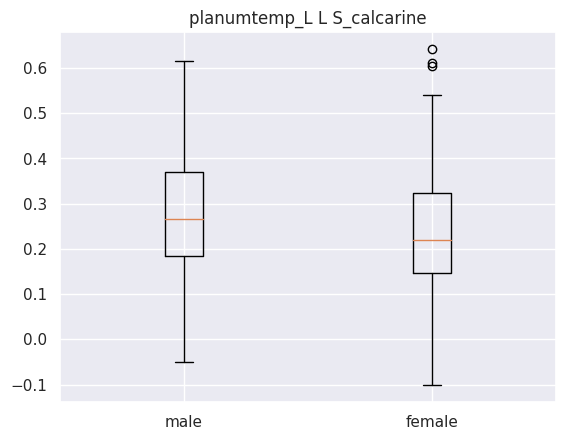

Ttest_indResult(statistic=3.141316233107298, pvalue=0.001770403211946406)
male mean : 0.274296150904943
male std : 0.1280515167012644
female mean : 0.2400809567398671
female std : 0.12947348397677685


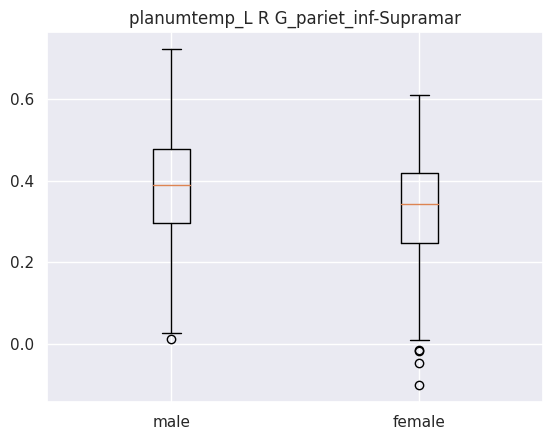

Ttest_indResult(statistic=4.712576838267088, pvalue=3.0873356981406085e-06)
male mean : 0.38310964460076047
male std : 0.13313561747450714
female mean : 0.3312813015614618
female std : 0.12732063243807878


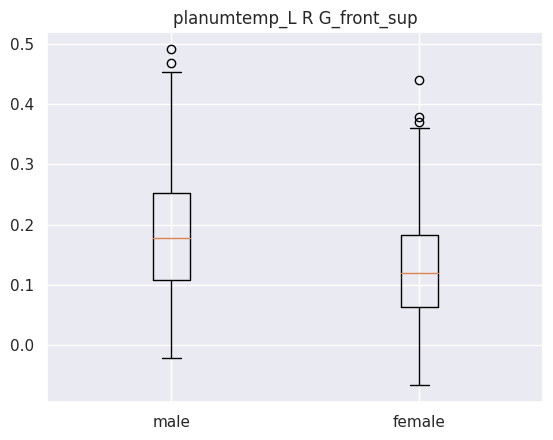

Ttest_indResult(statistic=7.005723286524496, pvalue=7.053092520728604e-12)
male mean : 0.1842207737676046
male std : 0.09752786905164766
female mean : 0.12974268123255814
female std : 0.08681164436850244


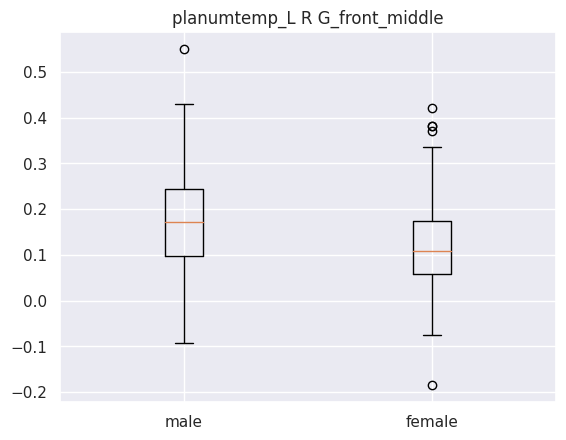

Ttest_indResult(statistic=7.083051952003173, pvalue=4.234418336006045e-12)
male mean : 0.17561467015703422
male std : 0.10099648809567767
female mean : 0.11818345196269103
female std : 0.09119635254658147


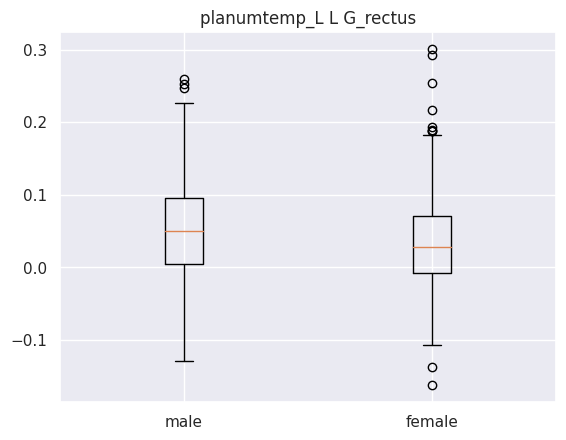

Ttest_indResult(statistic=2.7512545363189393, pvalue=0.006128244861950536)
male mean : 0.05109769466604562
male std : 0.07154061416307267
female mean : 0.035068776211362125
female std : 0.06650833816517755
                                       Region       Men     Women  \
0  planumtemp_L - L S_oc-temp_med_and_Lingual  0.201385  0.169107   
1      planumtemp_L - L G_oc-temp_lat-fusifor  0.273935  0.236642   
2      planumtemp_L - R G_temp_sup-Plan_polar  0.212479  0.175966   
3                planumtemp_L - L G_front_sup  0.184722  0.137820   
4      planumtemp_L - R G_oc-temp_lat-fusifor  0.262076  0.226365   
5                planumtemp_L - L S_calcarine  0.274296  0.240081   
6      planumtemp_L - R G_pariet_inf-Supramar  0.383110  0.331281   
7                planumtemp_L - R G_front_sup  0.184221  0.129743   
8             planumtemp_L - R G_front_middle  0.175615  0.118183   
9                   planumtemp_L - L G_rectus  0.051098  0.035069   

        P value  
0  4.120711e-04 

In [35]:
rois = ["planumtemp_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_R

     coefficient          seed                       labels
47      0.258000  planumtemp_R      L S_circular_insula_inf
108     0.250284  planumtemp_R      R G_temp_sup-Plan_polar
60      0.236093  planumtemp_R  L S_oc-temp_med_and_Lingual
43      0.220355  planumtemp_R                L S_calcarine
15      0.206736  planumtemp_R                L G_front_sup
72      0.192519  planumtemp_R             L S_temporal_sup
121     0.173699  planumtemp_R      R S_circular_insula_inf
139     0.170760  planumtemp_R             R S_pericallosal
58      0.151122  planumtemp_R            L S_occipital_ant
20      0.148373  planumtemp_R      L G_oc-temp_lat-fusifor
The mean accuracy : 0.7947115044247788
The standard deviation of the accuracy : 0.03976175647254694
The lower boundry of the confidance interval of the accuracy : 0.7167784617385868
The upper boundry of the confidance interval of the accuracy : 0.8726445471109707


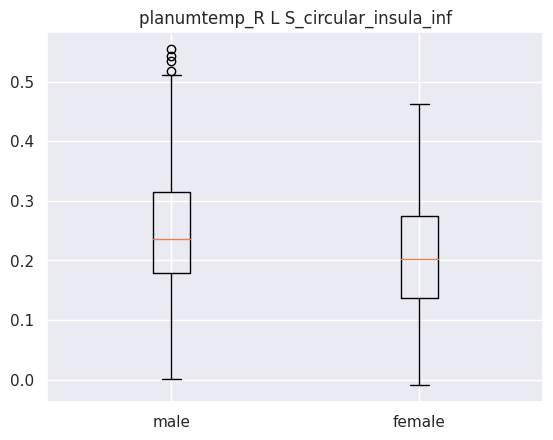

Ttest_indResult(statistic=4.754592848867569, pvalue=2.5298689374709147e-06)
male mean : 0.24664524678136882
male std : 0.09996404948497183
female mean : 0.20796517266445183
female std : 0.09280734872241128


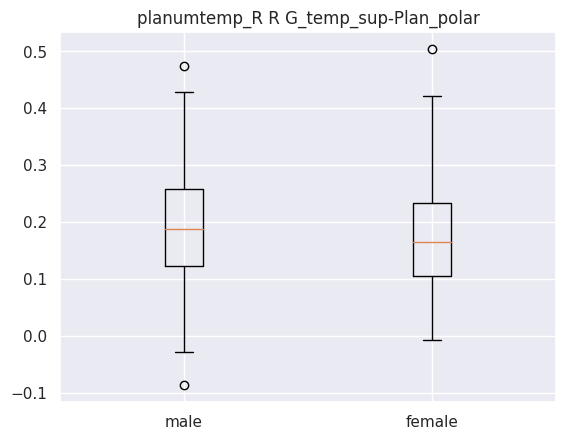

Ttest_indResult(statistic=2.321906417293724, pvalue=0.02059447944633167)
male mean : 0.19231692340304182
male std : 0.09008408764482337
female mean : 0.17497604091495014
female std : 0.08675608750582152


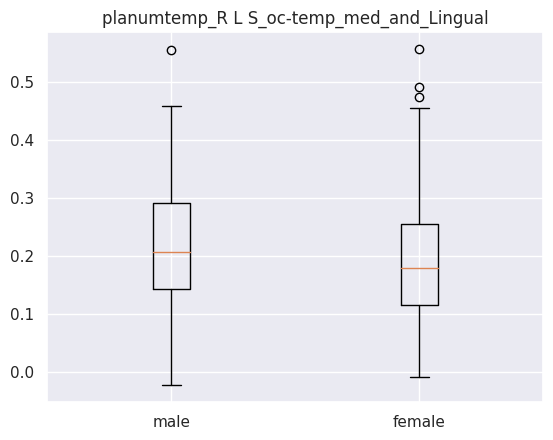

Ttest_indResult(statistic=2.8830998134021852, pvalue=0.004088548964724054)
male mean : 0.21623359568707226
male std : 0.10598136025556922
female mean : 0.1909124683142857
female std : 0.10198184189373703


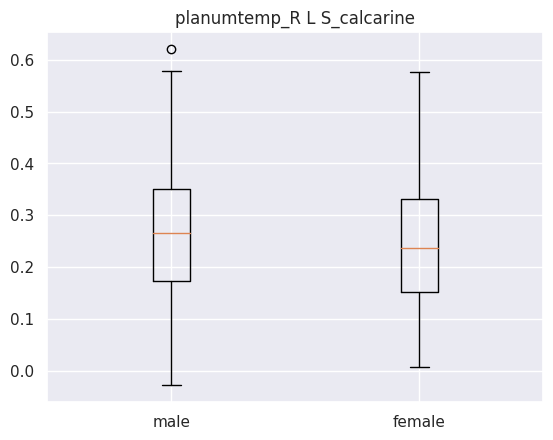

Ttest_indResult(statistic=2.002991768199032, pvalue=0.045657919237324006)
male mean : 0.26823541858505706
male std : 0.12784499132396293
female mean : 0.24731367291561462
female std : 0.11963048968200794


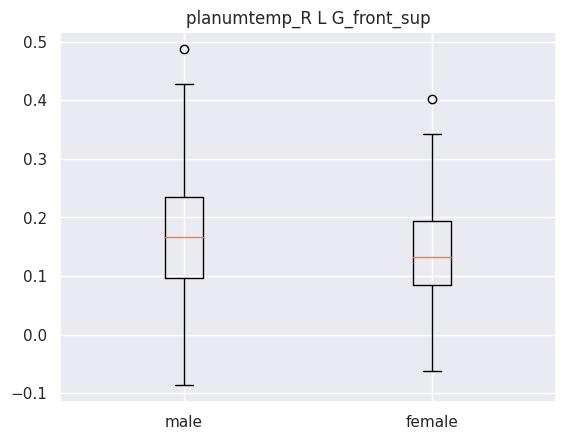

Ttest_indResult(statistic=3.245882136071958, pvalue=0.0012405568276112682)
male mean : 0.16498520389163499
male std : 0.09957579450944844
female mean : 0.1399915779053156
female std : 0.08291453993537845


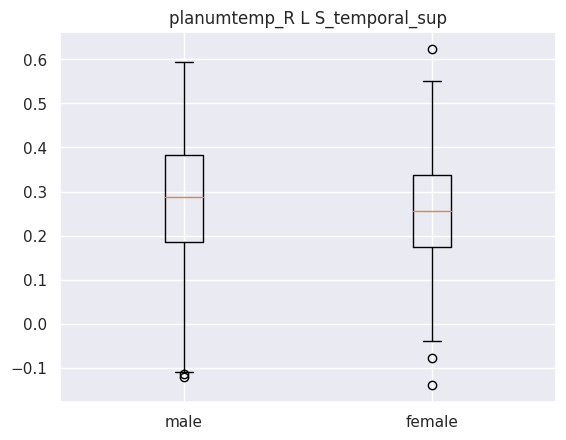

Ttest_indResult(statistic=1.9939713075469714, pvalue=0.04663794806816013)
male mean : 0.27949129047262355
male std : 0.13856078867444266
female mean : 0.2574814225966777
female std : 0.1231077975974857


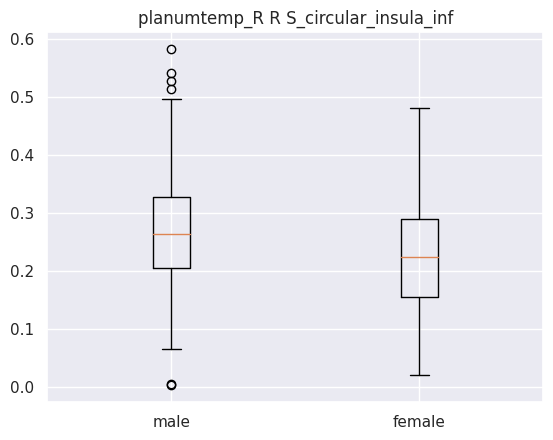

Ttest_indResult(statistic=4.926397277096471, pvalue=1.103284155465702e-06)
male mean : 0.2661869187410647
male std : 0.09527302507599171
female mean : 0.22700655812956813
female std : 0.09298067524697533


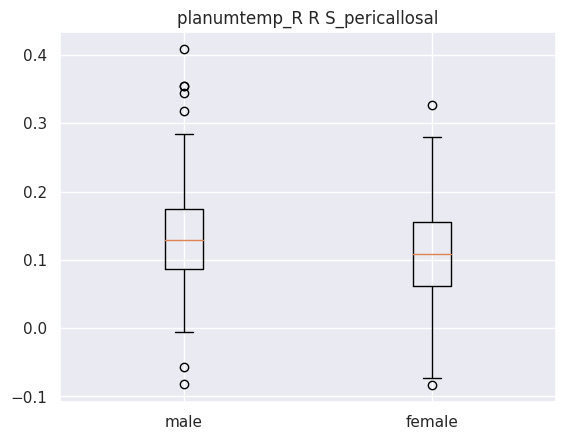

Ttest_indResult(statistic=4.21027853272709, pvalue=2.969654392292594e-05)
male mean : 0.13301439208163496
male std : 0.07336478835843015
female mean : 0.1079359846166113
female std : 0.06778752300317713


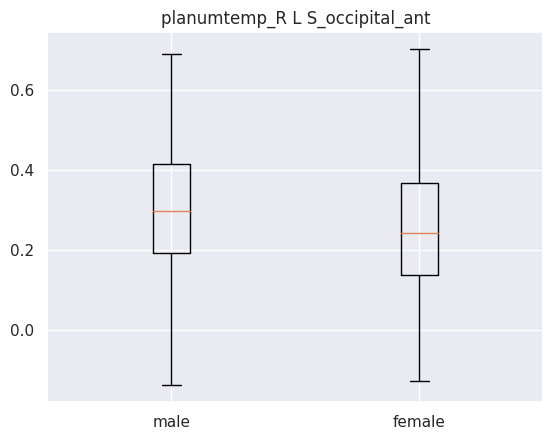

Ttest_indResult(statistic=3.428455086580389, pvalue=0.000651502448703635)
male mean : 0.2995649025620913
male std : 0.16165035751789086
female mean : 0.25357602423322256
female std : 0.1559564399420219


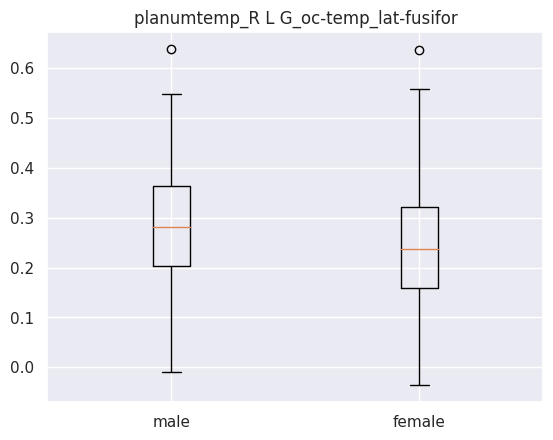

Ttest_indResult(statistic=4.153958282783595, pvalue=3.77618536555217e-05)
male mean : 0.28594790805589354
male std : 0.11929345196444417
female mean : 0.24477274405647842
female std : 0.11538894637809151
                                       Region       Men     Women   P value
0      planumtemp_R - L S_circular_insula_inf  0.246645  0.207965  0.000003
1      planumtemp_R - R G_temp_sup-Plan_polar  0.192317  0.174976  0.020594
2  planumtemp_R - L S_oc-temp_med_and_Lingual  0.216234  0.190912  0.004089
3                planumtemp_R - L S_calcarine  0.268235  0.247314  0.045658
4                planumtemp_R - L G_front_sup  0.164985  0.139992  0.001241
5             planumtemp_R - L S_temporal_sup  0.279491  0.257481  0.046638
6      planumtemp_R - R S_circular_insula_inf  0.266187  0.227007  0.000001
7             planumtemp_R - R S_pericallosal  0.133014  0.107936  0.000030
8            planumtemp_R - L S_occipital_ant  0.299565  0.253576  0.000652
9      planumtemp_R - L G_oc-temp_la

In [36]:
rois = ["planumtemp_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions for all left seeds

     coefficient     seed                       labels
98      0.129544  opIFG_L       R G_pariet_inf-Angular
55      0.113597  opIFG_L  L S_intrapariet_and_P_trans
322     0.113110   aMTG_L             L G_parietal_sup
53      0.111013  opIFG_L                L S_front_sup
504     0.102529   pITG_L  L S_oc-temp_med_and_Lingual
66      0.092603  opIFG_L              L S_postcentral
460     0.092465   pITG_L    L G_Ins_lg_and_S_cent_ins
135     0.091490  opIFG_L          R S_orbital_lateral
421     0.082751   aMTG_L                R S_front_inf
351     0.082314   aMTG_L  L S_intrapariet_and_P_trans
The mean accuracy : 0.9100008849557522
The standard deviation of the accuracy : 0.02859329420494401
The lower boundry of the confidance interval of the accuracy : 0.8539580283140619
The upper boundry of the confidance interval of the accuracy : 0.9660437415974424


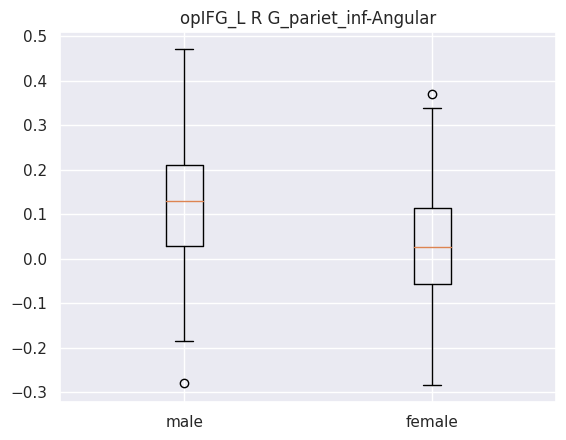

Ttest_indResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14)
male mean : 0.11766997985152092
female mean : 0.03601953544850498


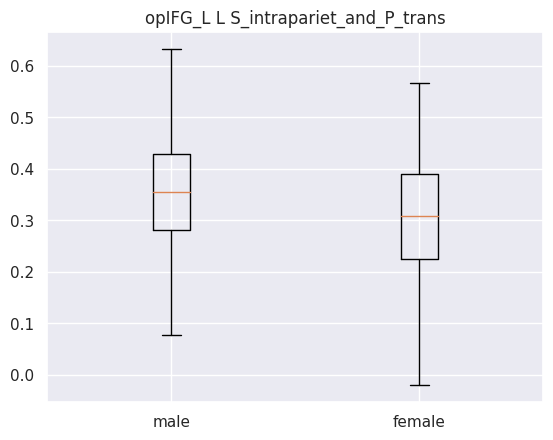

Ttest_indResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07)
male mean : 0.35213074777946773
female mean : 0.3031099729109635


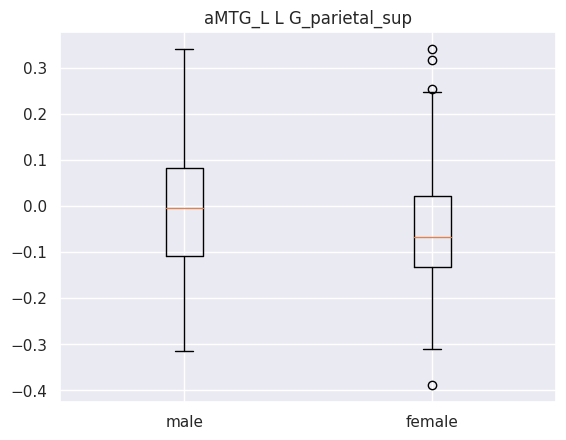

Ttest_indResult(statistic=4.059890719730225, pvalue=5.606265792321045e-05)
male mean : -0.006850357185019011
female mean : -0.05038483464086378


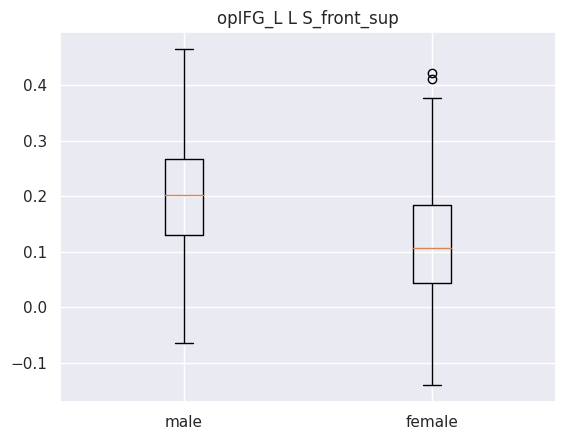

Ttest_indResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22)
male mean : 0.1996858131581749
female mean : 0.11606861896099667


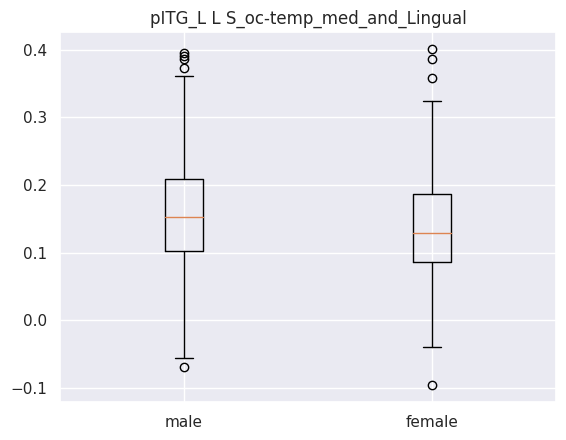

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
female mean : 0.13959590949933556


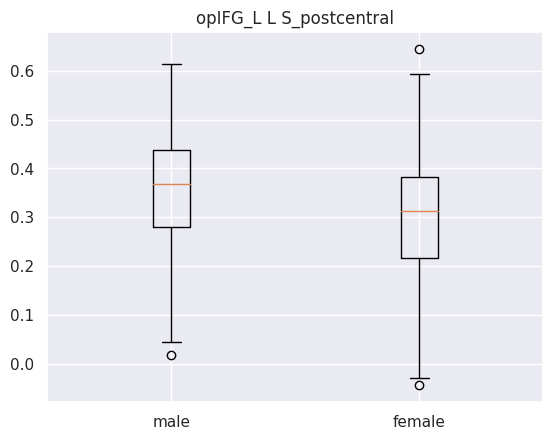

Ttest_indResult(statistic=6.164168782870945, pvalue=1.3532257302585482e-09)
male mean : 0.36117898896577944
female mean : 0.29792533494119594


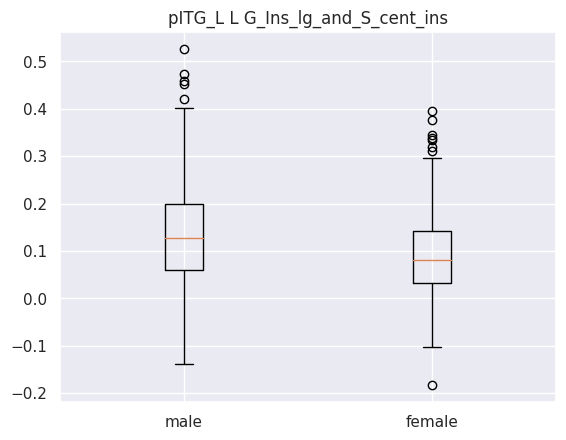

Ttest_indResult(statistic=5.375595899137657, pvalue=1.1205421040305568e-07)
male mean : 0.13588157877680607
female mean : 0.09083962553239203


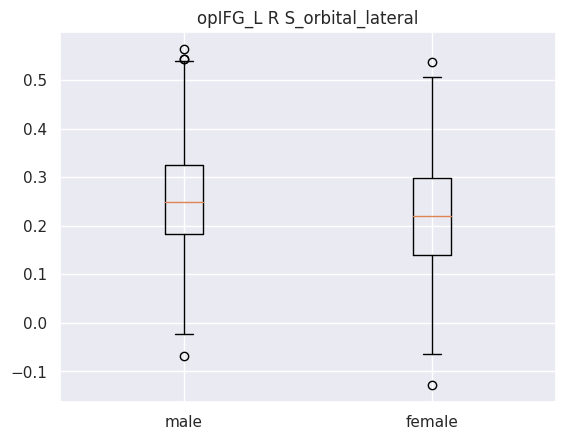

Ttest_indResult(statistic=3.4854763518784595, pvalue=0.0005296037092508647)
male mean : 0.2535425955125475
female mean : 0.2189224686335548


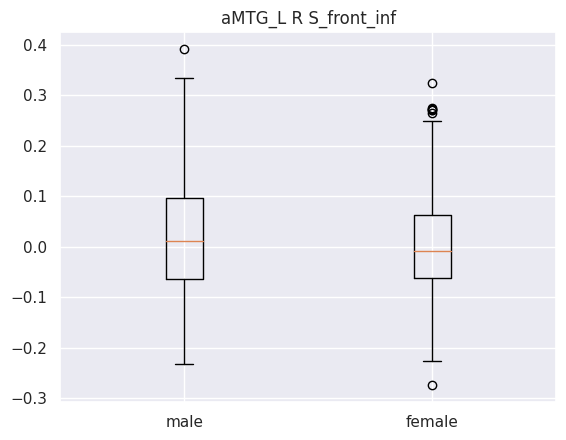

Ttest_indResult(statistic=1.520196297164563, pvalue=0.12902402830858953)
male mean : 0.01492980324942966
female mean : 0.0012906573921926926


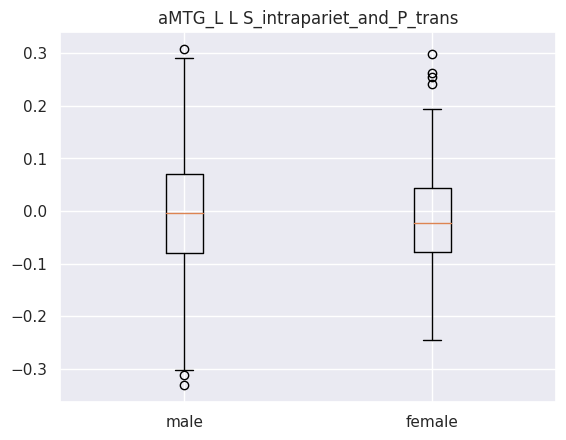

Ttest_indResult(statistic=0.9647641183387371, pvalue=0.3350779189775276)
male mean : -0.004121455086692014
female mean : -0.012516677279534883
                                  Region       Men     Women       P value
0       opIFG_L - R G_pariet_inf-Angular  0.117670  0.036020  5.480752e-14
1  opIFG_L - L S_intrapariet_and_P_trans  0.352131  0.303110  5.821782e-07
2              aMTG_L - L G_parietal_sup -0.006850 -0.050385  5.606266e-05
3                opIFG_L - L S_front_sup  0.199686  0.116069  8.422510e-22
4   pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  2.643129e-03
5              opIFG_L - L S_postcentral  0.361179  0.297925  1.353226e-09
6     pITG_L - L G_Ins_lg_and_S_cent_ins  0.135882  0.090840  1.120542e-07
7          opIFG_L - R S_orbital_lateral  0.253543  0.218922  5.296037e-04
8                 aMTG_L - R S_front_inf  0.014930  0.001291  1.290240e-01
9   aMTG_L - L S_intrapariet_and_P_trans -0.004121 -0.012517  3.350779e-01


In [154]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_left)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions of all right seeds

     coefficient          seed                       labels
487     0.118662        pITG_R                L S_calcarine
504     0.105718        pITG_R  L S_oc-temp_med_and_Lingual
90      0.102234       opIFG_R    R G_Ins_lg_and_S_cent_ins
66      0.101487       opIFG_R              L S_postcentral
22      0.101259       opIFG_R      L G_oc-temp_med-Parahip
421     0.101095        aMTG_R                R S_front_inf
231     0.100313  planumtemp_R      R G_cingul-Post-ventral
459     0.100124        pITG_R                L G_front_sup
440     0.099942        aMTG_R              R S_subparietal
343     0.098722        aMTG_R      L S_circular_insula_inf
The mean accuracy : 0.8987194690265485
The standard deviation of the accuracy : 0.030543593531264734
The lower boundry of the confidance interval of the accuracy : 0.8388540257052697
The upper boundry of the confidance interval of the accuracy : 0.9585849123478274


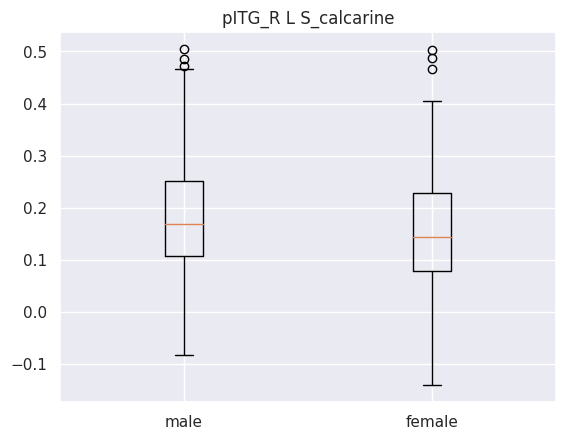

Ttest_indResult(statistic=3.2351347094550422, pvalue=0.0012873143650390924)
male mean : 0.18480961091102663
female mean : 0.1554359898385382


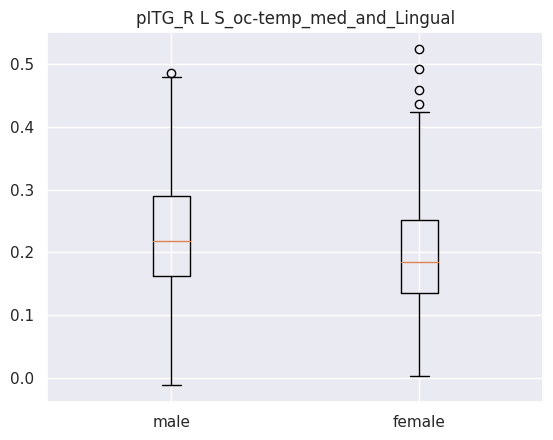

Ttest_indResult(statistic=3.658497216134596, pvalue=0.00027757468582203013)
male mean : 0.2244769810418251
female mean : 0.19555248922657806


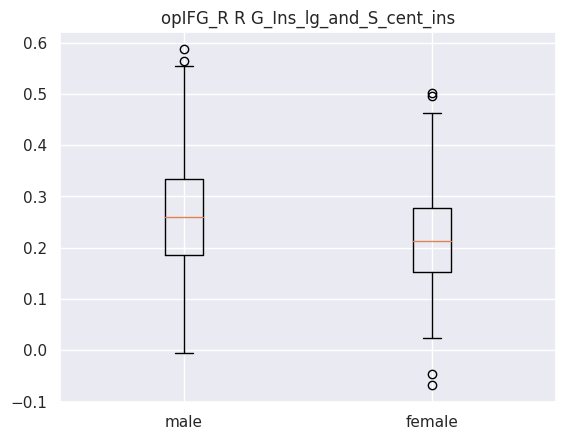

Ttest_indResult(statistic=5.071136490485997, pvalue=5.378396910376465e-07)
male mean : 0.26213691595703426
female mean : 0.21789970354485053


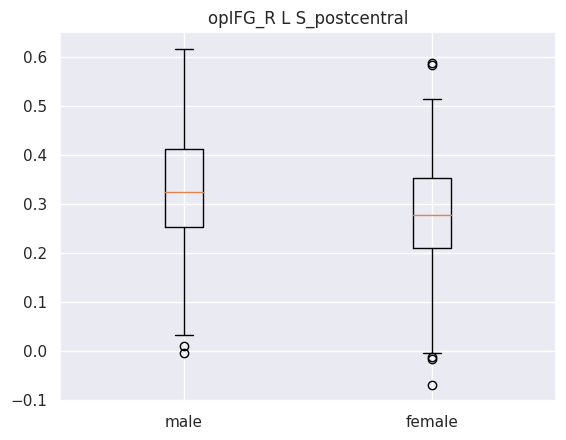

Ttest_indResult(statistic=5.271054566169988, pvalue=1.9369475536514105e-07)
male mean : 0.32780815557186316
female mean : 0.27874649102691035


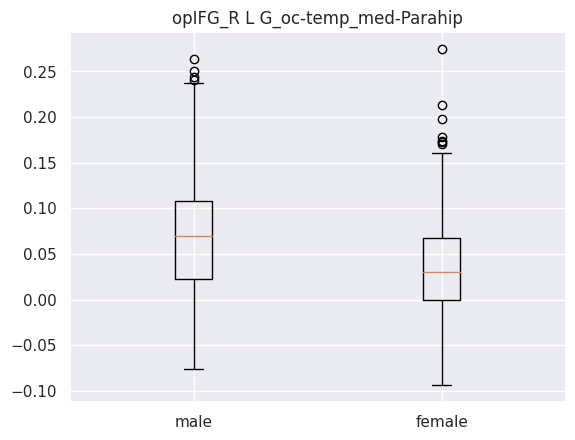

Ttest_indResult(statistic=6.251330329526955, pvalue=8.05447977290333e-10)
male mean : 0.06960421543711026
female mean : 0.0386048876523588


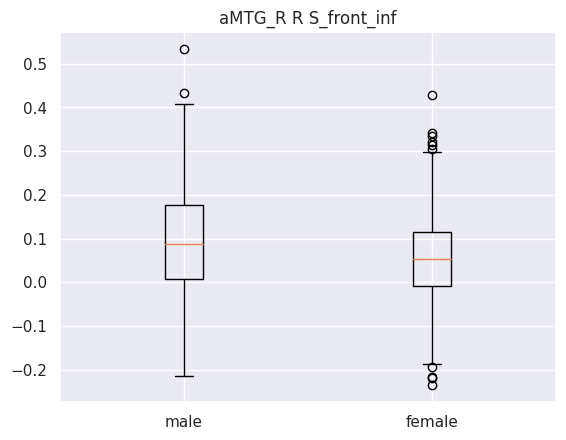

Ttest_indResult(statistic=4.148252422200393, pvalue=3.868639529214971e-05)
male mean : 0.09520096379193917
female mean : 0.055367278695980064


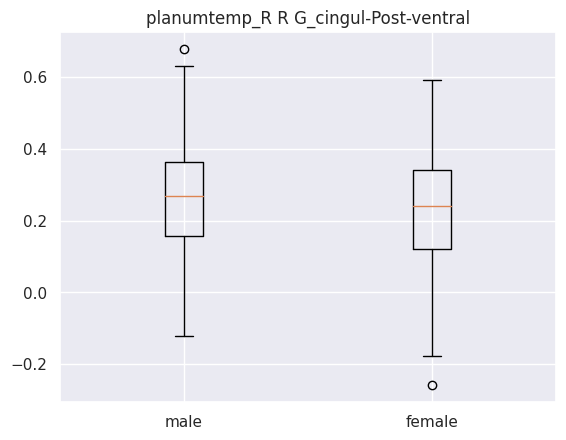

Ttest_indResult(statistic=2.475346691636639, pvalue=0.013604413951231341)
male mean : 0.26356463188897344
female mean : 0.23156667134385378


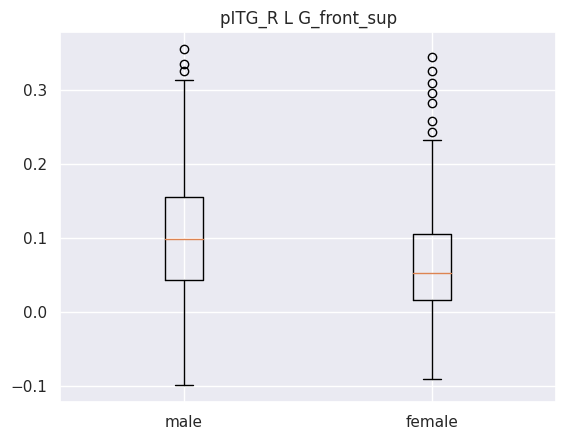

Ttest_indResult(statistic=5.343650897512694, pvalue=1.3257979942942627e-07)
male mean : 0.10204701447452472
female mean : 0.06652489050332226


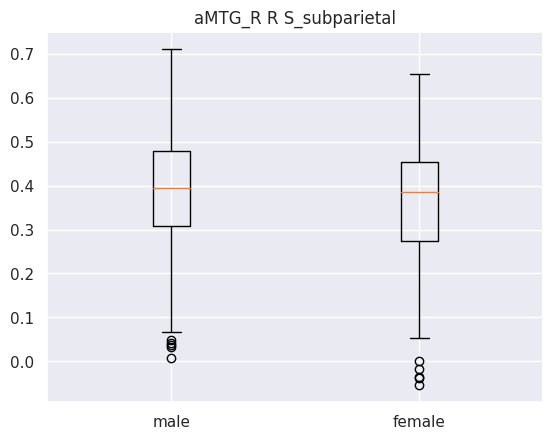

Ttest_indResult(statistic=1.8896304959307062, pvalue=0.059321818335763714)
male mean : 0.3831714017832699
female mean : 0.36253010012717607


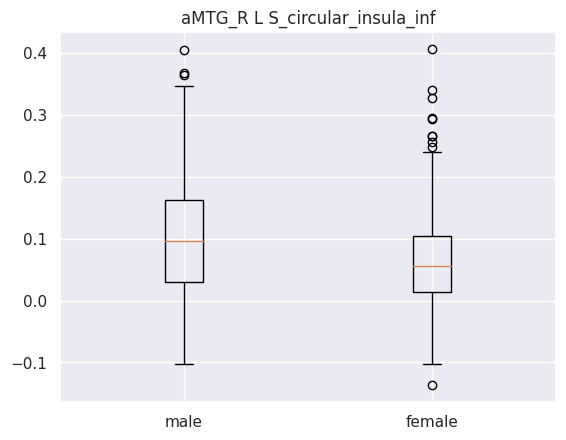

Ttest_indResult(statistic=5.519848416328338, pvalue=5.188050187200102e-08)
male mean : 0.10639979831471483
female mean : 0.06546545337565116
                                   Region       Men     Women       P value
0                  pITG_R - L S_calcarine  0.184810  0.155436  1.287314e-03
1    pITG_R - L S_oc-temp_med_and_Lingual  0.224477  0.195552  2.775747e-04
2     opIFG_R - R G_Ins_lg_and_S_cent_ins  0.262137  0.217900  5.378397e-07
3               opIFG_R - L S_postcentral  0.327808  0.278746  1.936948e-07
4       opIFG_R - L G_oc-temp_med-Parahip  0.069604  0.038605  8.054480e-10
5                  aMTG_R - R S_front_inf  0.095201  0.055367  3.868640e-05
6  planumtemp_R - R G_cingul-Post-ventral  0.263565  0.231567  1.360441e-02
7                  pITG_R - L G_front_sup  0.102047  0.066525  1.325798e-07
8                aMTG_R - R S_subparietal  0.383171  0.362530  5.932182e-02
9        aMTG_R - L S_circular_insula_inf  0.106400  0.065465  5.188050e-08


In [155]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_right)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

# Noise testing

In [40]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

In [41]:
model_test = data_results["model"][random.randint(0, 10000)]
gender_test = np.asarray(df_boot["Gender"])
score, perm_score, p_val = permutation_test_score(model_test, x_correl, gender_test)

In [42]:
acc_iter = []
model_test = data_results["model"][random.randint(0, 10000)]
for i in range(0, 10000):
    gender_test = np.asarray(df_boot["Gender"])
    np.random.shuffle(gender_test)
    acc_rand = model_test.score(x_correl, gender_test)
    acc_iter.append(acc_rand)
    
acc_iter = np.asarray(acc_iter)

In [43]:
gender_test = np.asarray(df_boot["Gender"])
x_correl.size

667776

(0.4, 1.0)

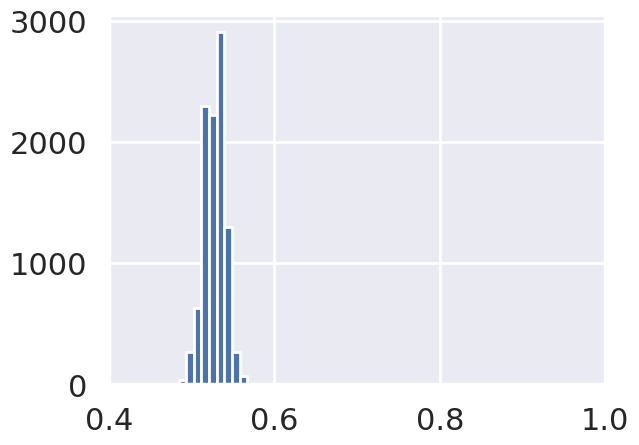

In [44]:
plt.hist(acc_iter)
plt.xlim([0.4, 1])

In [45]:
# accuracy should be around 0.50 (50%) if not it's a problem
acc_iter.mean()

0.5269499999999999

# Violin plot

0.13497622929505704


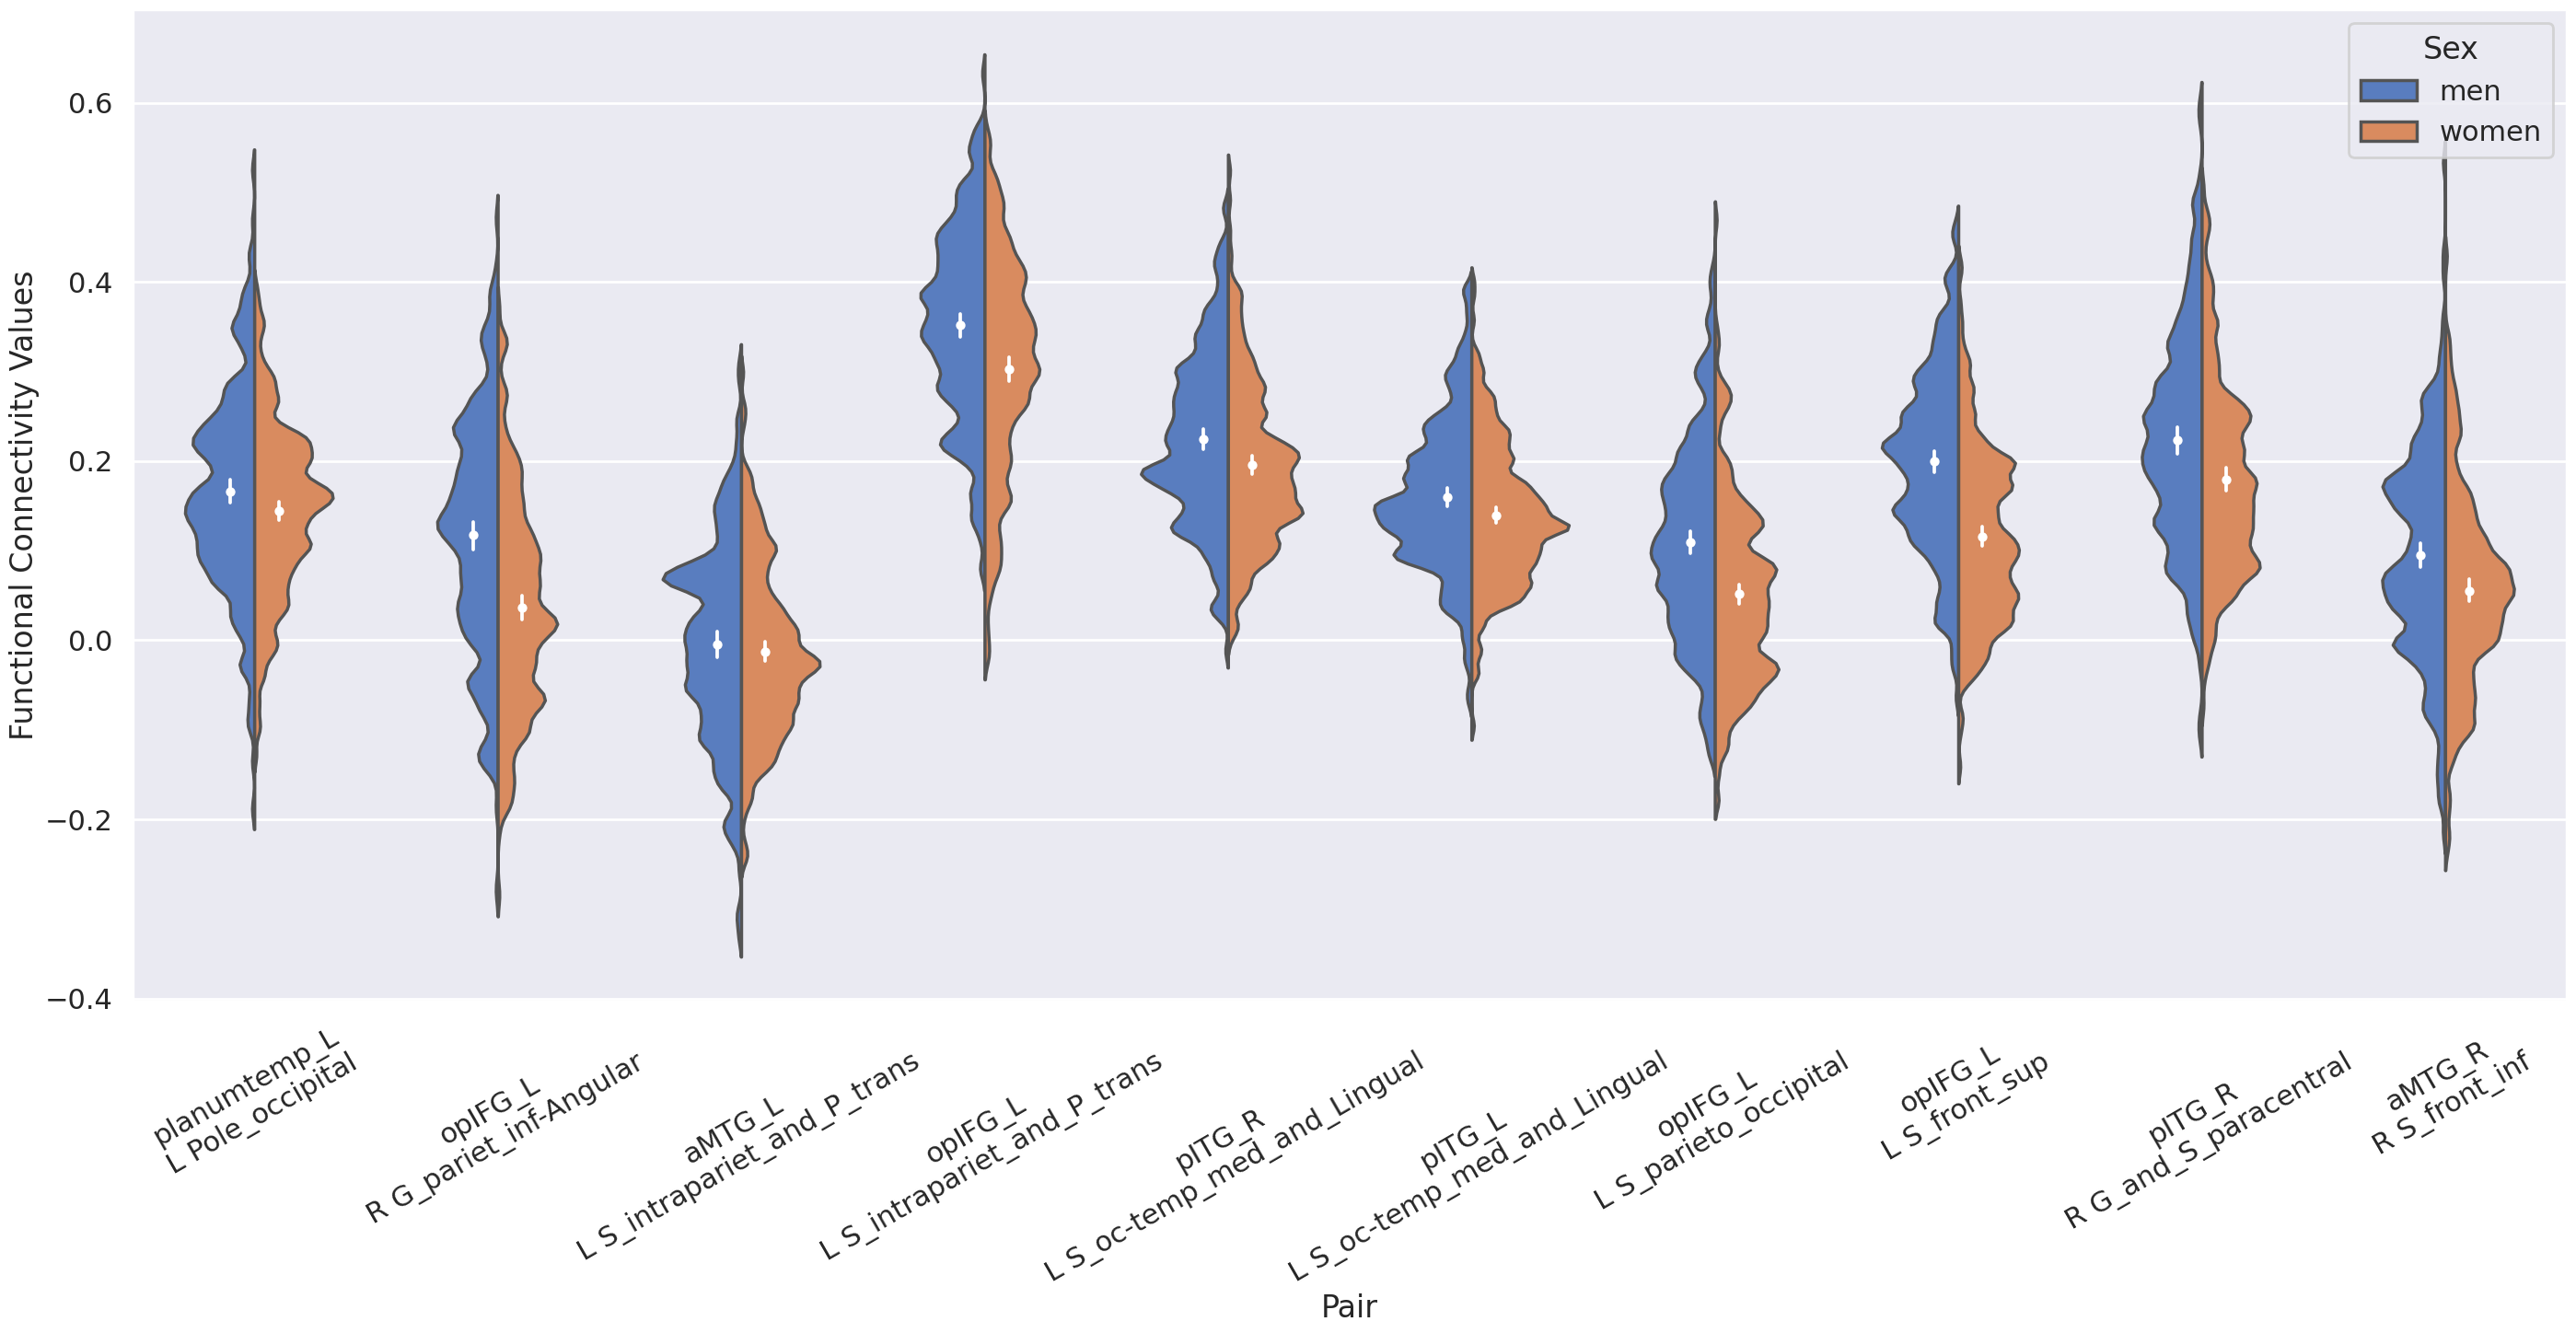

In [38]:
#1. make dataframe for the violin plot 
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")
df = pd.DataFrame.from_dict(data, orient="index", columns=label["name"]).reset_index()
df["participant_id"] = df["index"].apply(lambda x: x[0])
df["seed"] = df["index"].apply(lambda x: x[1])
df["Gender"] = list(Final_df["Gender"]) * 8
df["Gender"] = df["Gender"].replace({0:"men", 1:"women"})

df_connectivity = df.melt(id_vars=["participant_id", "seed", "Gender"], value_vars=label["name"])
df_connectivity["pair"] = df_connectivity["seed"] + " with " + df_connectivity["name"]

df_temp_men = df_connectivity.loc[
    (df_connectivity["Gender"] == "men") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]  
df_temp_women = df_connectivity.loc[
    (df_connectivity["Gender"] == "women") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]
stats.ttest_ind(df_temp_men["value"], df_temp_women["value"])
print(df_temp_men["value"].mean())


# A changer selon les dix meilleures seeds
# list to make sure top 10 regions are in order 
top10 = ["planumtemp_L with L Pole_occipital",
         "opIFG_L with R G_pariet_inf-Angular",
         "aMTG_L with L S_intrapariet_and_P_trans",
         "opIFG_L with L S_intrapariet_and_P_trans",
         "pITG_R with L S_oc-temp_med_and_Lingual", 
         "pITG_L with L S_oc-temp_med_and_Lingual",
         "opIFG_L with L S_parieto_occipital",
         "opIFG_L with L S_front_sup",
         "pITG_R with R G_and_S_paracentral", 
         "aMTG_R with R S_front_inf"]
         

df_temp = df_connectivity.loc[
    # (df_connectivity["seed"] == "opIFG_L") &
    (df_connectivity["pair"].isin(top10))
]  
df_temp["Sex"] = df_temp["Gender"]
df_temp["Functional Connectivity Values"] = df_temp["value"]
df_temp["Pair"] = df_temp["pair"]

# plt.figure(figsize=(20, 11.25))

sns.set_theme(context="poster")

v_plot = sns.violinplot(x="Pair", y="Functional Connectivity Values", hue="Sex", data=df_temp, split= True, bw=0.10,inner = None, palette="muted", order=top10)
# v_plot.set_xticks([0,1])
# v_plot.set_xticklabels(["aMTG_L\nL S_front_sup", "2"])
# v_plot

v_plot = sns.pointplot(x="Pair", y="Functional Connectivity Values", hue="Sex",
                    data=df_temp, dodge=0.2, join=False, palette=['white'], ax=v_plot, scale=0.5, order=top10, legend=False)

# changer les xticklabels selon les labels obtenues
v_plot.set_xticks([0,1,2,3,4,5,6,7,8,9])
v_plot.set_xticklabels(["planumtemp_L\nL Pole_occipital",
         "opIFG_L\nR G_pariet_inf-Angular",
         "aMTG_L\nL S_intrapariet_and_P_trans",
         "opIFG_L\nL S_intrapariet_and_P_trans",
         "pITG_R\nL S_oc-temp_med_and_Lingual", 
         "pITG_L\nL S_oc-temp_med_and_Lingual",
         "opIFG_L\nL S_parieto_occipital",
         "opIFG_L\nL S_front_sup",
         "pITG_R\nR G_and_S_paracentral", 
         "aMTG_R\nR S_front_inf"], rotation=30)


fig = v_plot.get_figure()
fig.set_size_inches(28.5, 15)
plt.tight_layout()
fig.savefig("violin_plot.png", dpi=300)

# Classification based on best feature

In [36]:
def machine_learning(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score.append(cross_val_score(model, X_train, y_train, cv=20, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

## Testing the machine learning classification feature by feature

In [167]:
# the best feature (seed and their region)
seeds = ["opIFG_L", "pITG_R", "opIFG_L", "opIFG_L", "aMTG_L", "aMTG_L", "pITG_L", "aMTG_L", "planumtemp_L", "aMTG_L"]
regions = ["R_G_pariet_inf-Angular", 
          "L_S_calcarine", 
          "L_S_intrapariet_and_P_trans", 
          "L_S_front_sup", 
          "R_G_cingul-Post-ventral", 
          "L_G_and_S_cingul-Ant",
           "L_S_oc-temp_med_and_Lingual",
         "L_G_cingul-Post-ventral",
         "L_Pole_occipital",
         "R_S_front_inf"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__voxelcorrelations.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")

x = []
y = []
for i in range(0, len(seeds)):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    signal = loaded[seeds[i]+"__"+regions[i]]
    for subject in Final_df["subject_label"]:
        sub_sex = Final_df.loc[Final_df["subject_label"] == subject]["Gender"].values[0]
        value = loaded.loc[loaded["Unnamed: 0"] == "sub-"+str(subject)][seeds[i]+"__"+regions[i]].values[0]
        x.append(value)
        y.append(sub_sex)
    x = np.asarray(x)
    x = x.reshape(-1,1)
    print("Testing : "+seeds[i]+" "+regions[i])
    machine_learning(x,y)
    print("\n")
    x = []
    y = []
        

Testing : opIFG_L R_G_pariet_inf-Angular
train: 451 test: 113
[array([0.86956522, 0.60869565, 0.73913043, 0.60869565, 0.65217391,
       0.43478261, 0.60869565, 0.7826087 , 0.7826087 , 0.65217391,
       0.56521739, 0.86363636, 0.68181818, 0.54545455, 0.68181818,
       0.63636364, 0.77272727, 0.59090909, 0.5       , 0.63636364])]
predicted class  Femme  Homme
actual class                 
Femme               42     18
Homme               21     32
accuracy test (r2) = 0.6548672566371682
accuracy train (r2) = 0.6585365853658537


Testing : pITG_R L_S_calcarine
train: 451 test: 113
[array([0.65217391, 0.56521739, 0.65217391, 0.56521739, 0.65217391,
       0.56521739, 0.56521739, 0.47826087, 0.34782609, 0.56521739,
       0.47826087, 0.59090909, 0.63636364, 0.45454545, 0.63636364,
       0.5       , 0.5       , 0.59090909, 0.18181818, 0.59090909])]
predicted class  Femme  Homme
actual class                 
Femme               51      9
Homme               40     13
accuracy test (r2) = 

# Independent validation testing (60/20/20) with z-transformed applied on r-pearson score

In [9]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-aMTG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-opIFG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-pITG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-pITG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-planumtemp_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_left = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-left_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_right = study_dir / "results_test_validation_2024-06-20" / "LinearSVC" / "seed-right_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

# FYI do not interpret the regions just look at the mean accuraccy which is the mean accuracy of the model on the validation sample

In [10]:
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

In [11]:
# mean confusion matrix
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion.mean()

predicted class    Femme    Homme
actual class                     
Femme            45.2862   4.1140
Homme             4.5443  37.0555

In [14]:
# mean confusion matrix of the validation set
pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion.mean()

predicted class    Femme    Homme
actual class                     
Femme            43.0007  12.9993
Homme            11.5130  44.4870

## Best regions all seed validation accuraccy

Validation accuracy
The mean accuracy : 0.7811401785714285
The standard deviation of the accuracy : 0.027661066915925275
The lower boundry of the confidance interval of the accuracy : 0.726924487416215
The upper boundry of the confidance interval of the accuracy : 0.835355869726642

Testing accuracy
      coefficient          seed                       labels
189      0.059589  planumtemp_L             L Pole_occipital
98       0.055317       opIFG_L       R G_pariet_inf-Angular
351      0.049720        aMTG_L  L S_intrapariet_and_P_trans
55       0.048553       opIFG_L  L S_intrapariet_and_P_trans
1096     0.047908        pITG_R  L S_oc-temp_med_and_Lingual
504      0.047085        pITG_L  L S_oc-temp_med_and_Lingual
64       0.045608       opIFG_L        L S_parieto_occipital
53       0.043577       opIFG_L                L S_front_sup
1112     0.042649        pITG_R        R G_and_S_paracentral
1013     0.042049        aMTG_R                R S_front_inf
The mean accuracy : 0.904853

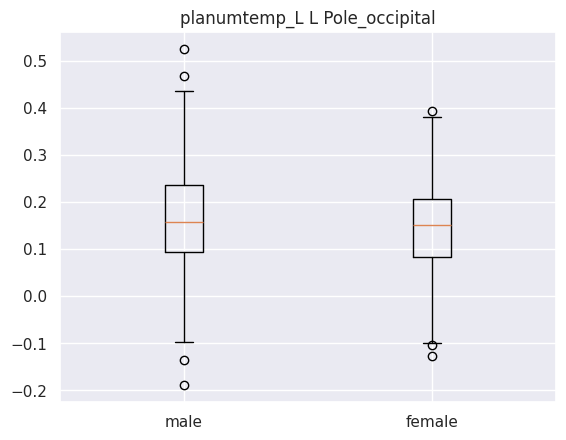

TtestResult(statistic=2.486200541931443, pvalue=0.013200894125973316, df=562.0)
male mean : 0.16626784924790874
male std : 0.11264322709736568
female mean : 0.14439602449857145
female std : 0.09589248593995307


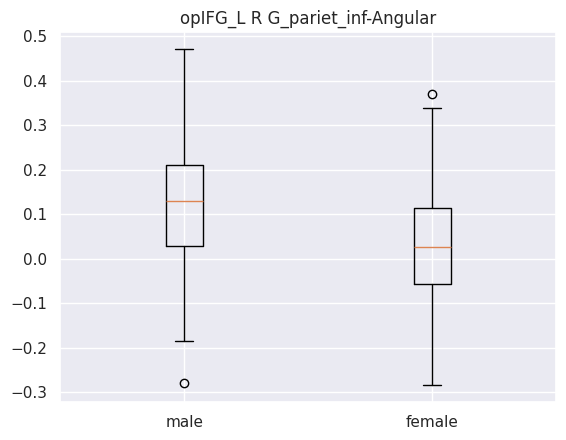

TtestResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14, df=562.0)
male mean : 0.11766997985152092
male std : 0.13076288558639354
female mean : 0.03601953544850498
female std : 0.12000095132461792


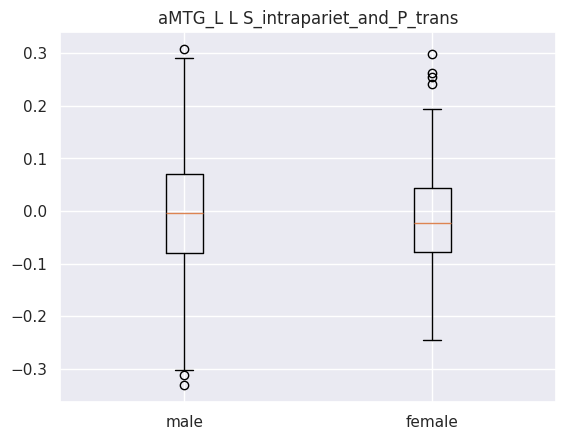

TtestResult(statistic=0.9647641183387371, pvalue=0.3350779189775276, df=562.0)
male mean : -0.004121455086692014
male std : 0.11166920373773248
female mean : -0.012516677279534883
female std : 0.09459673974350062


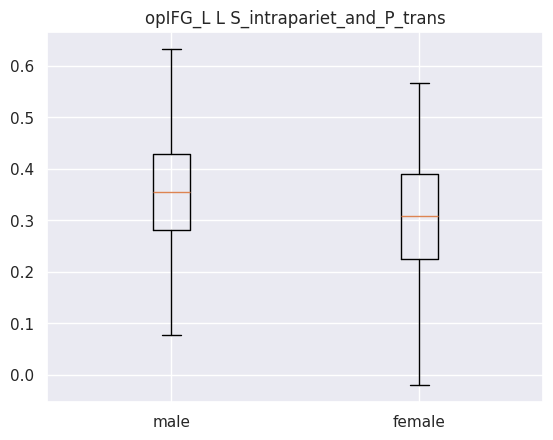

TtestResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07, df=562.0)
male mean : 0.35213074777946773
male std : 0.10658887449917556
female mean : 0.3031099729109635
female std : 0.12130464463020163


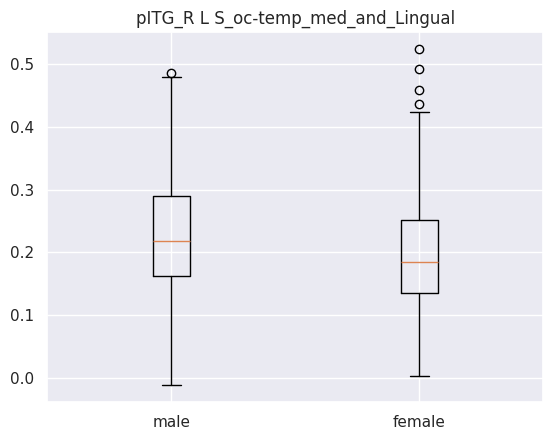

TtestResult(statistic=3.658497216134596, pvalue=0.00027757468582203013, df=562.0)
male mean : 0.2244769810418251
male std : 0.09519528685578532
female mean : 0.19555248922657806
female std : 0.09199381053279175


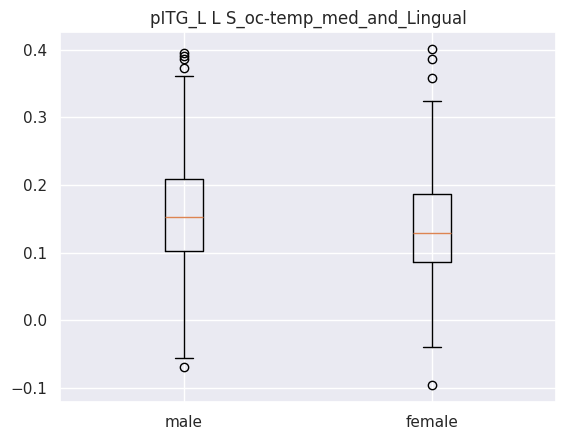

TtestResult(statistic=3.01993636806222, pvalue=0.002643129220462383, df=562.0)
male mean : 0.1601642877536882
male std : 0.08334523805349907
female mean : 0.13959590949933556
female std : 0.07802101521527612


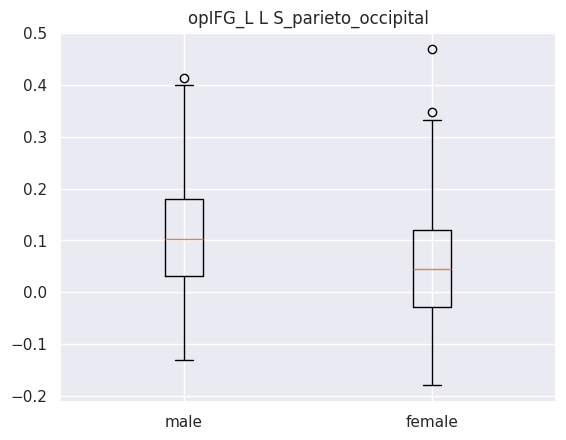

TtestResult(statistic=6.503523668812626, pvalue=1.7355351061785972e-10, df=562.0)
male mean : 0.10978782784771862
male std : 0.10910224511601631
female mean : 0.05152286066817276
female std : 0.10312061557532284


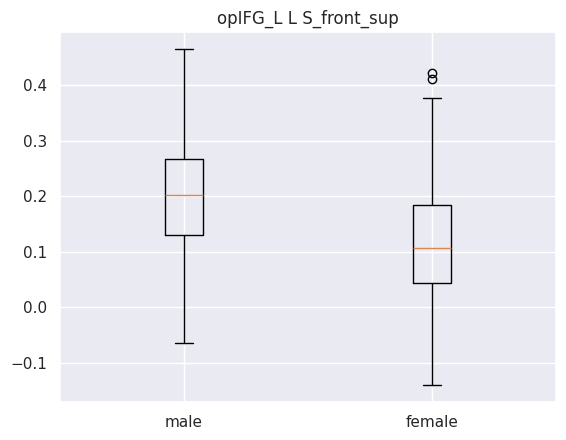

TtestResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22, df=562.0)
male mean : 0.1996858131581749
male std : 0.10098467263884126
female mean : 0.11606861896099667
female std : 0.09690605329034335


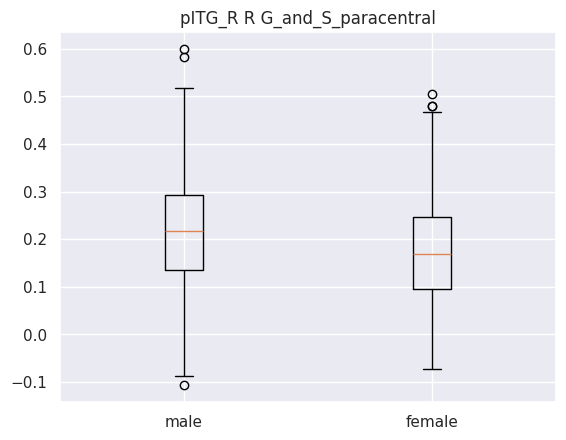

TtestResult(statistic=4.569125068043735, pvalue=6.02478242147785e-06, df=562.0)
male mean : 0.2237594718095057
male std : 0.11892193001714262
female mean : 0.17962112252890367
female std : 0.10999380702841893


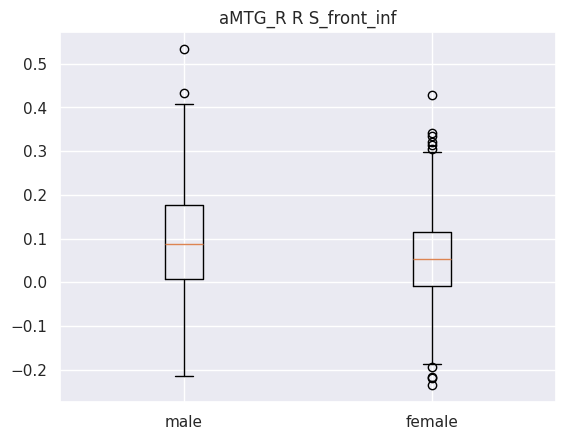

TtestResult(statistic=4.148252422200393, pvalue=3.868639529214971e-05, df=562.0)
male mean : 0.09520096379193917
male std : 0.11824387845447384
female mean : 0.055367278695980064
female std : 0.10930840275035555
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [23]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## aMTG_L validation accuracy

Validation accuracy
The mean accuracy : 0.7152473214285714
The standard deviation of the accuracy : 0.028997796238728314
The lower boundry of the confidance interval of the accuracy : 0.6584116408006639
The upper boundry of the confidance interval of the accuracy : 0.7720830020564788

Testing accuracy
     coefficient    seed                       labels
64      0.234068  aMTG_L        L S_parieto_occipital
98      0.214389  aMTG_L       R G_pariet_inf-Angular
22      0.195173  aMTG_L      L G_oc-temp_med-Parahip
104     0.188964  aMTG_L                   R G_rectus
55      0.172416  aMTG_L  L S_intrapariet_and_P_trans
131     0.163485  aMTG_L   R S_oc_sup_and_transversal
112     0.135791  aMTG_L       R Lat_Fis-ant-Horizont
90      0.133809  aMTG_L    R G_Ins_lg_and_S_cent_ins
53      0.124143  aMTG_L                L S_front_sup
87      0.123860  aMTG_L       R G_front_inf-Triangul
The mean accuracy : 0.8152373626373628
The standard deviation of the accuracy : 0.04218718450440424
The

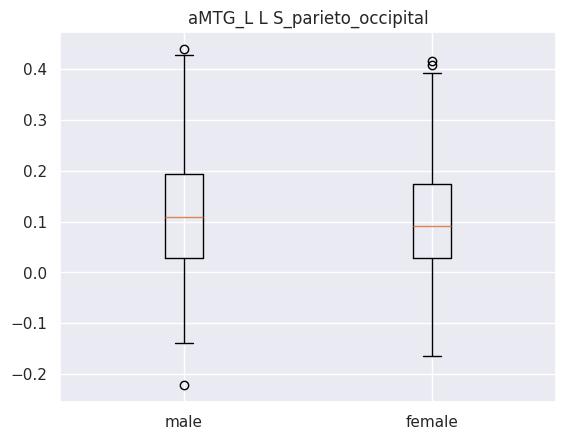

TtestResult(statistic=0.8844937044320892, pvalue=0.3768080010830589, df=562.0)
male mean : 0.11133875940456274
male std : 0.11414917252822208
female mean : 0.10330131695813953
female std : 0.1012672300745512


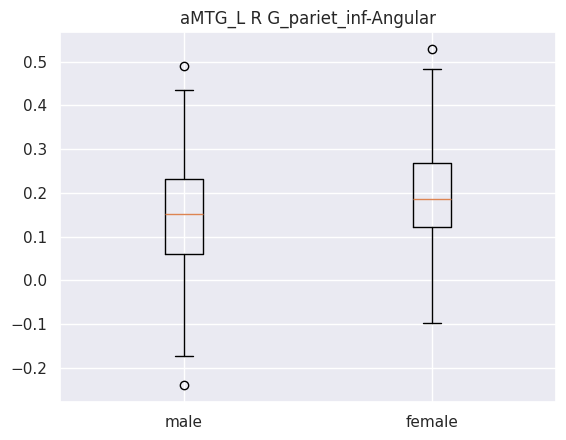

TtestResult(statistic=-4.609075888150725, pvalue=5.010077069107832e-06, df=562.0)
male mean : 0.1466265599053232
male std : 0.12723212732120814
female mean : 0.1927383331056479
female std : 0.109937688897089


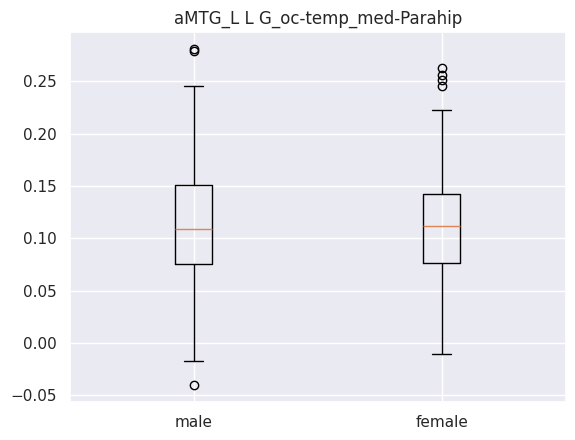

TtestResult(statistic=1.1334696103846564, pvalue=0.25750038435672185, df=562.0)
male mean : 0.11530491022243346
male std : 0.05322901814260232
female mean : 0.11041756162126246
female std : 0.048956437497619715


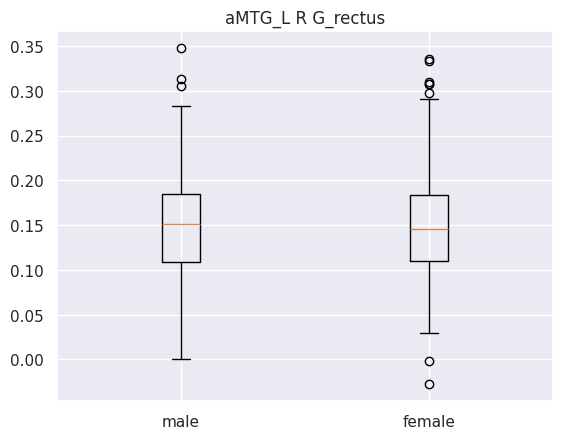

TtestResult(statistic=-0.050680278730783346, pvalue=0.9595982987735558, df=562.0)
male mean : 0.14921290738174903
male std : 0.05910948627590685
female mean : 0.14947103351827243
female std : 0.061200009471971246


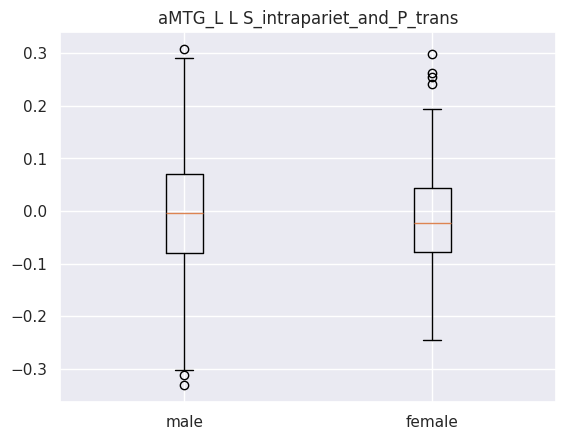

TtestResult(statistic=0.9647641183387371, pvalue=0.3350779189775276, df=562.0)
male mean : -0.004121455086692014
male std : 0.11166920373773248
female mean : -0.012516677279534883
female std : 0.09459673974350062


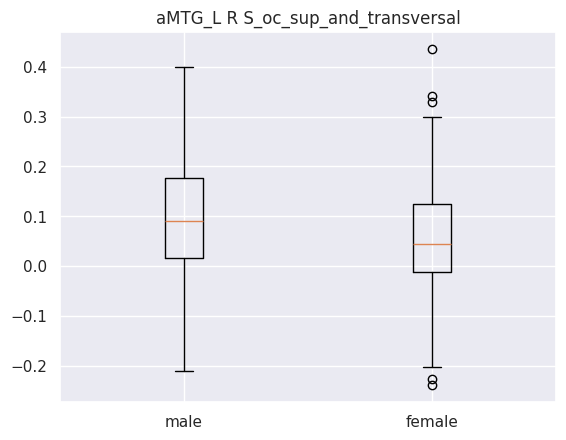

TtestResult(statistic=4.340453076267227, pvalue=1.686421726368641e-05, df=562.0)
male mean : 0.09461966041634981
male std : 0.1152752884396305
female mean : 0.054491475181651164
female std : 0.10386960568631878


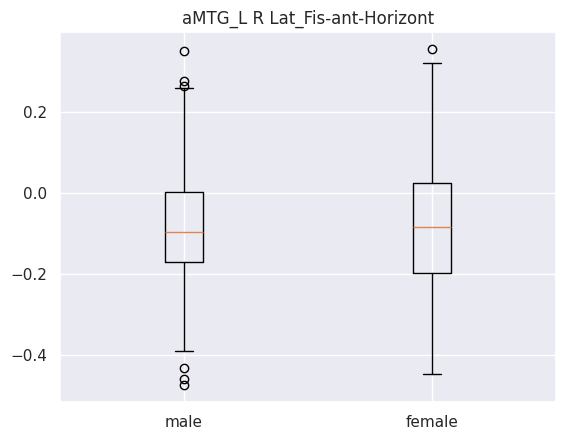

TtestResult(statistic=-0.45605548932418016, pvalue=0.6485262516617757, df=562.0)
male mean : -0.08113484296726237
male std : 0.14676591352252533
female mean : -0.07525894114513622
female std : 0.15710785096797464


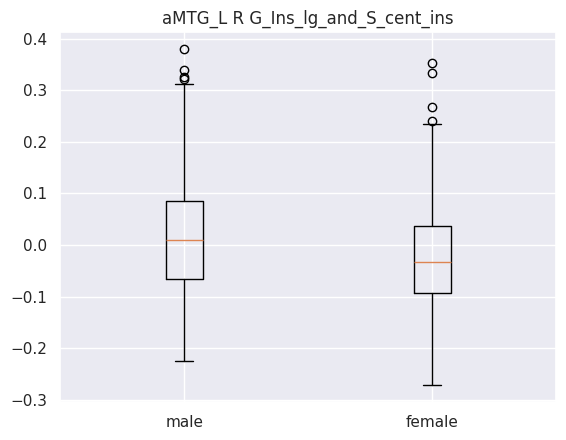

TtestResult(statistic=3.776689697345467, pvalue=0.00017586030683131387, df=562.0)
male mean : 0.012922727051558938
male std : 0.11306640552563055
female mean : -0.02182893120227242
female std : 0.10497192397026917


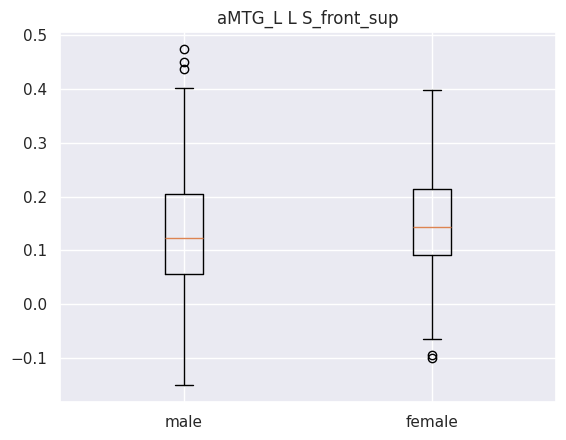

TtestResult(statistic=-1.4354160996967782, pvalue=0.15172486392697015, df=562.0)
male mean : 0.13497622929505704
male std : 0.11129746737694128
female mean : 0.14753736321687708
female std : 0.0961519746523398


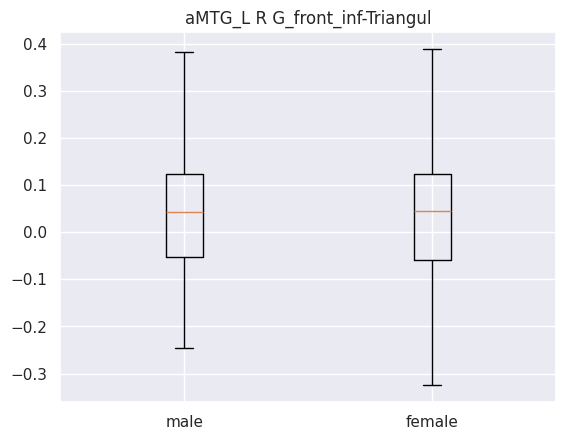

TtestResult(statistic=0.12631199818411354, pvalue=0.8995301343742685, df=562.0)
male mean : 0.04378524430243346
male std : 0.13158479648887714
female mean : 0.042384303678737544
female std : 0.1308012611400562
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [24]:
rois = ["aMTG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_L)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## aMRG_R validation accuracy

Validation accuracy
The mean accuracy : 0.6798491071428572
The standard deviation of the accuracy : 0.02863778899263139
The lower boundry of the confidance interval of the accuracy : 0.6237190407172997
The upper boundry of the confidance interval of the accuracy : 0.7359791735684147

Testing accuracy
     coefficient    seed                       labels
98      0.219058  aMTG_R       R G_pariet_inf-Angular
22      0.200820  aMTG_R      L G_oc-temp_med-Parahip
90      0.194872  aMTG_R    R G_Ins_lg_and_S_cent_ins
55      0.188319  aMTG_R  L S_intrapariet_and_P_trans
104     0.156633  aMTG_R                   R G_rectus
96      0.154862  aMTG_R      R G_oc-temp_med-Parahip
64      0.150786  aMTG_R        L S_parieto_occipital
75      0.148329  aMTG_R      R G_and_S_occipital_inf
112     0.140458  aMTG_R       R Lat_Fis-ant-Horizont
85      0.131296  aMTG_R      R G_front_inf-Opercular
The mean accuracy : 0.820779120879121
The standard deviation of the accuracy : 0.04207967266493374
The l

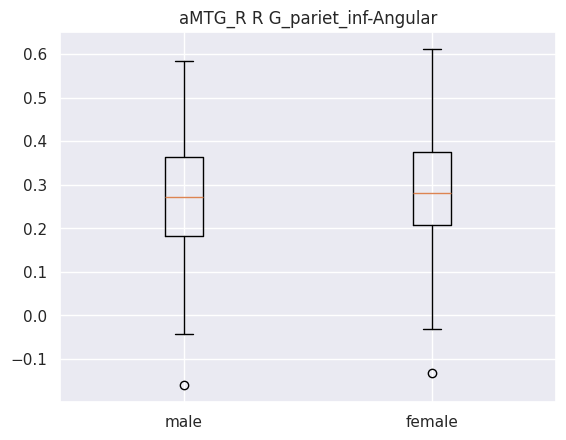

TtestResult(statistic=-1.3474458962609632, pvalue=0.17837963763879625, df=562.0)
male mean : 0.2745868511307985
male std : 0.12784455793647628
female mean : 0.2885656095314618
female std : 0.1180010594320334


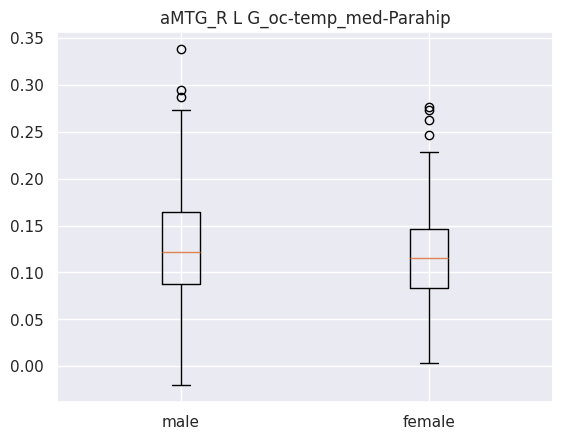

TtestResult(statistic=2.0619605458315986, pvalue=0.039670656140978776, df=562.0)
male mean : 0.1272253816121673
male std : 0.05639247240973288
female mean : 0.11806232951096346
female std : 0.04895538358491254


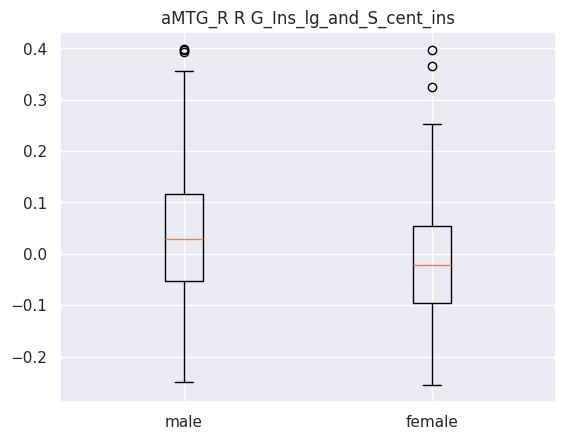

TtestResult(statistic=4.892230628154193, pvalue=1.3038463843832238e-06, df=562.0)
male mean : 0.03623579969863118
male std : 0.1252291741990028
female mean : -0.012065202055481731
female std : 0.1088246644922351


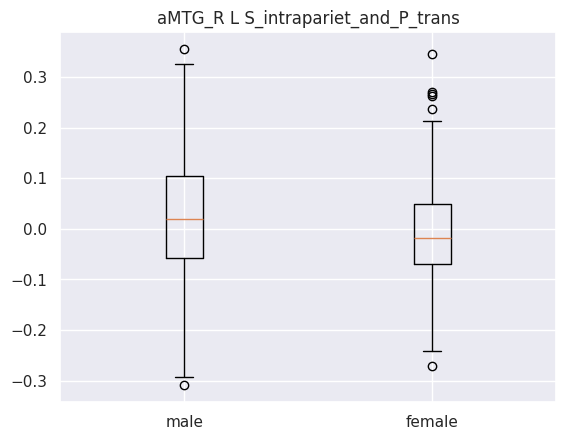

TtestResult(statistic=3.0510209113028184, pvalue=0.0023882691927384963, df=562.0)
male mean : 0.018445383925361214
male std : 0.11377089527880688
female mean : -0.008577846181096346
female std : 0.09617201070855781


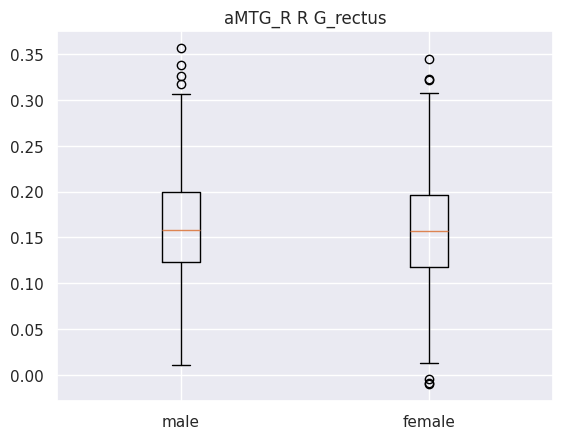

TtestResult(statistic=0.25672681729231484, pvalue=0.7974836233347031, df=562.0)
male mean : 0.1602442236539924
male std : 0.062175408547676864
female mean : 0.1588885866717608
female std : 0.06268623105683578


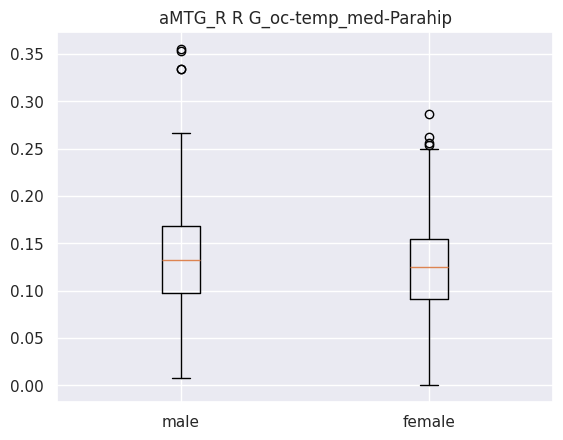

TtestResult(statistic=2.7035360113254954, pvalue=0.00706828235821115, df=562.0)
male mean : 0.13853981123193918
male std : 0.057904596395341776
female mean : 0.12625079083475085
female std : 0.0498514005437266


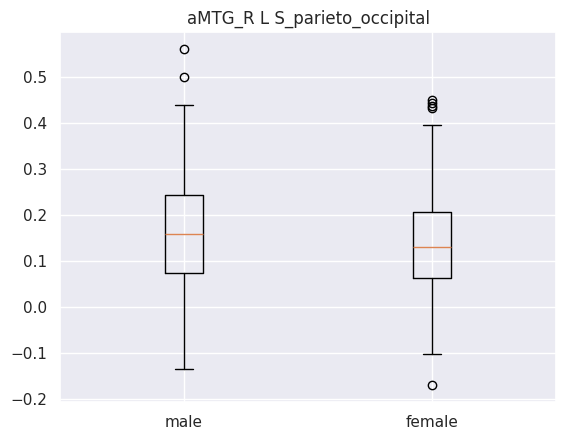

TtestResult(statistic=2.227185214461007, pvalue=0.026330207166639395, df=562.0)
male mean : 0.15845452172281368
male std : 0.11733507024146936
female mean : 0.13716209121049833
female std : 0.109192805980464


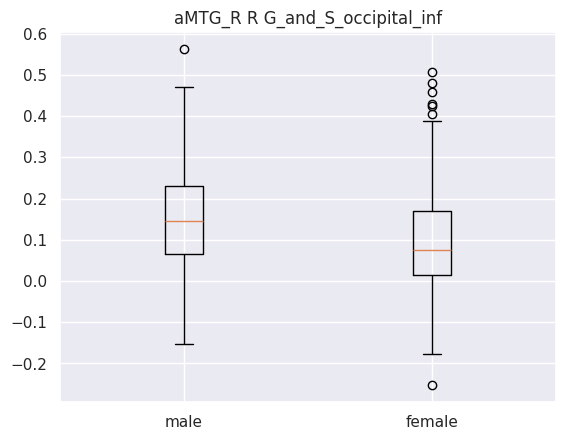

TtestResult(statistic=5.746838754084861, pvalue=1.4919371944492937e-08, df=562.0)
male mean : 0.1548778395163498
male std : 0.12383961806520402
female mean : 0.09606502119933555
female std : 0.11852064008245364


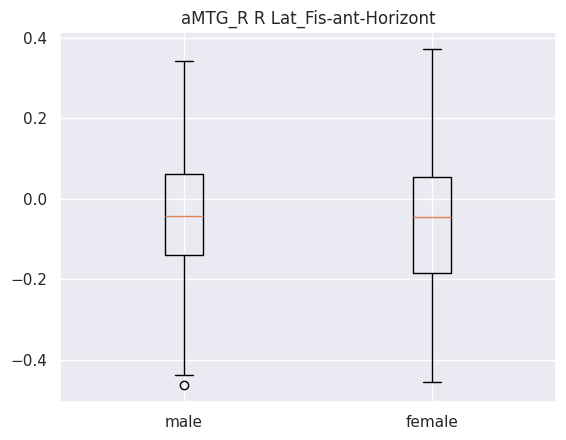

TtestResult(statistic=1.4449978779532366, pvalue=0.14901580803702616, df=562.0)
male mean : -0.0368282638551711
male std : 0.1549612567948559
female mean : -0.056400834690697677
female std : 0.1646196753549061


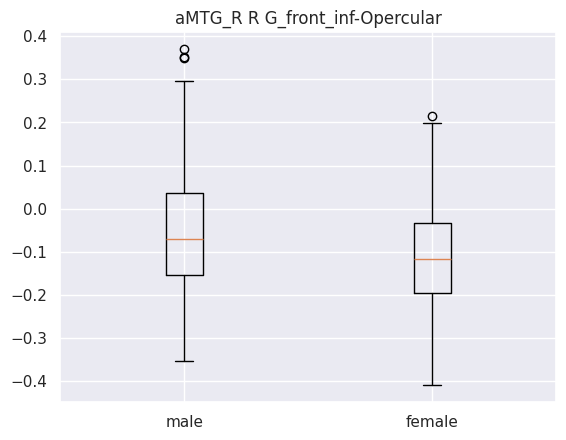

TtestResult(statistic=4.787448025936902, pvalue=2.1627924490973566e-06, df=562.0)
male mean : -0.057489325285171096
male std : 0.13961711883192487
female mean : -0.10877381936445182
female std : 0.1141970996046965
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [25]:
rois = ["aMTG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_R)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## opIFG_L validation accuracy

Validation accuracy
The mean accuracy : 0.7335598214285716
The standard deviation of the accuracy : 0.031071318644612607
The lower boundry of the confidance interval of the accuracy : 0.6726600368851309
The upper boundry of the confidance interval of the accuracy : 0.7944596059720123

Testing accuracy
     coefficient     seed                       labels
72      0.194536  opIFG_L             L S_temporal_sup
20      0.175971  opIFG_L      L G_oc-temp_lat-fusifor
91      0.157647  opIFG_L            R G_insular_short
40      0.155804  opIFG_L               L Lat_Fis-post
60      0.153663  opIFG_L  L S_oc-temp_med_and_Lingual
47      0.138516  opIFG_L      L S_circular_insula_inf
71      0.138130  opIFG_L             L S_temporal_inf
144     0.130402  opIFG_L              R S_subparietal
1       0.129342  opIFG_L      L G_and_S_occipital_inf
41      0.123180  opIFG_L             L Pole_occipital
The mean accuracy : 0.8388395604395605
The standard deviation of the accuracy : 0.0403465495

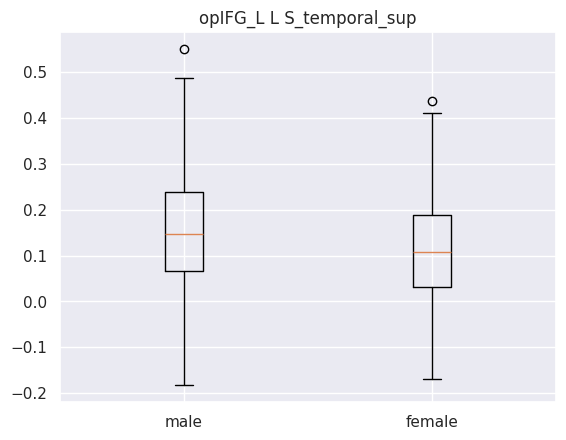

TtestResult(statistic=4.104919666823164, pvalue=4.644482275203613e-05, df=562.0)
male mean : 0.15756035950874525
male std : 0.12779665808907587
female mean : 0.11516167434405318
female std : 0.116995762417676


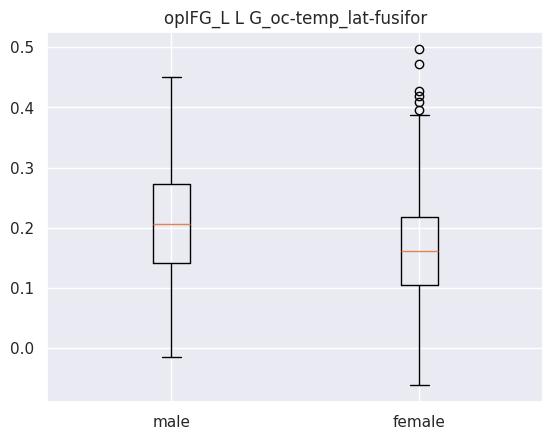

TtestResult(statistic=5.698927511987025, pvalue=1.9476660856975242e-08, df=562.0)
male mean : 0.21165041260456274
male std : 0.09558055806544623
female mean : 0.1668287685760797
female std : 0.09071059585266414


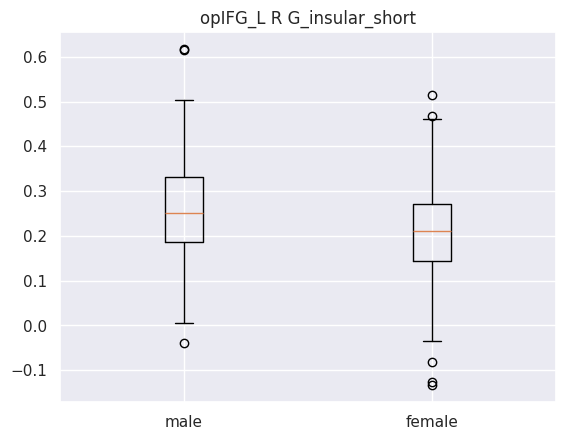

TtestResult(statistic=5.4808703280162065, pvalue=6.398857490240382e-08, df=562.0)
male mean : 0.25729847525475286
male std : 0.10255773714008104
female mean : 0.20946871466478406
female std : 0.10376640995486473


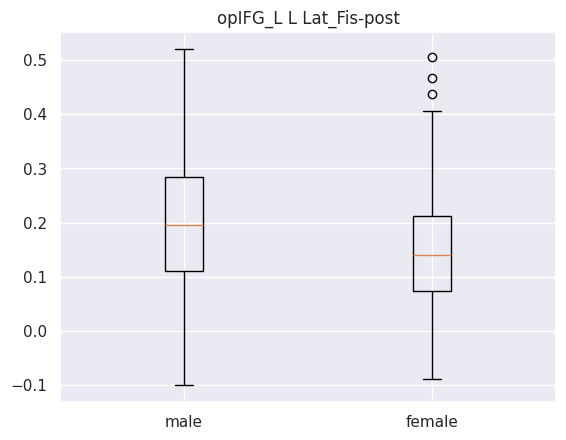

TtestResult(statistic=5.935387024296681, pvalue=5.1325420089517246e-09, df=562.0)
male mean : 0.2050836814703422
male std : 0.11767179108479932
female mean : 0.15007587232843853
female std : 0.10203339475287607


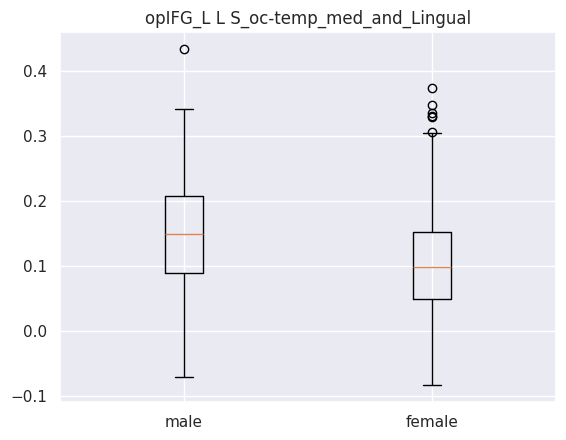

TtestResult(statistic=5.979839353972038, pvalue=3.974325533230207e-09, df=562.0)
male mean : 0.1488611000961977
male std : 0.08275130578679875
female mean : 0.10701805680602991
female std : 0.0827545429881859


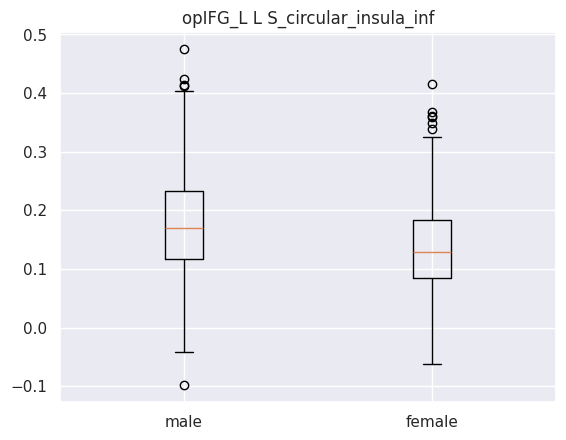

TtestResult(statistic=5.793990901906812, pvalue=1.1455922176287184e-08, df=562.0)
male mean : 0.17968730860456272
male std : 0.08982294121388894
female mean : 0.13831419359568106
female std : 0.07945500381706048


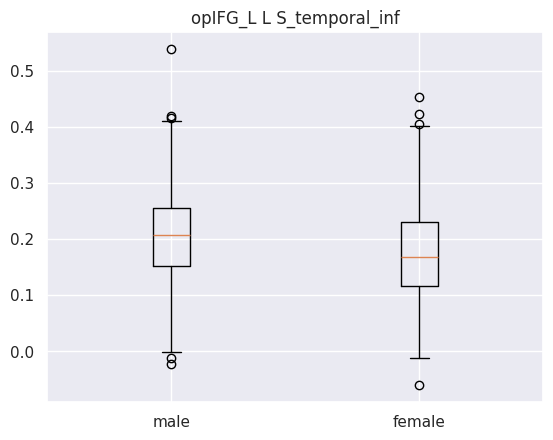

TtestResult(statistic=4.969224929521562, pvalue=8.936260638966738e-07, df=562.0)
male mean : 0.20876997986996199
male std : 0.08663159707917586
female mean : 0.17289818290913622
female std : 0.08425570908329043


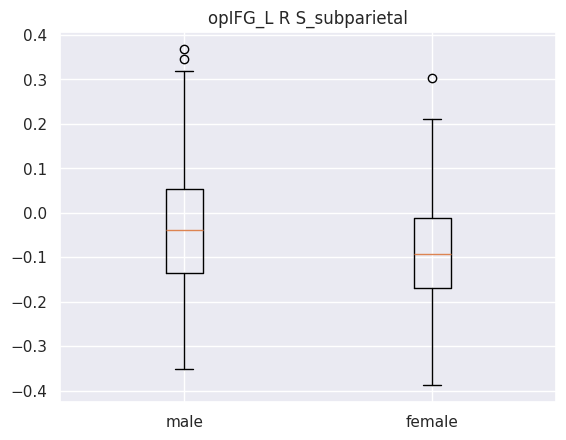

TtestResult(statistic=4.627538320714266, pvalue=4.59863706792552e-06, df=562.0)
male mean : -0.0332647789439924
male std : 0.13808114412316164
female mean : -0.08209271020398672
female std : 0.11188499200043661


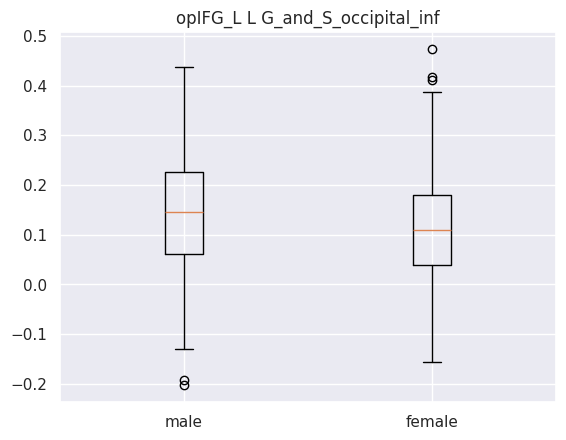

TtestResult(statistic=3.3566638640413826, pvalue=0.000842207438429869, df=562.0)
male mean : 0.14831989778022814
male std : 0.12463081174073931
female mean : 0.11545700281893687
female std : 0.10745927496138906


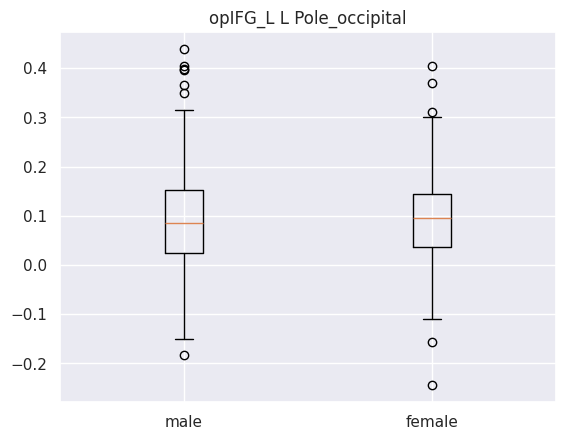

TtestResult(statistic=0.5548409872567964, pvalue=0.5792241764342783, df=562.0)
male mean : 0.09943078458722433
male std : 0.10251638089430502
female mean : 0.09496818549693023
female std : 0.08814978179794535
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [26]:
rois = ["opIFG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_L)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## opIFG_R validation accuracy

Validation accuracy
The mean accuracy : 0.7366723214285714
The standard deviation of the accuracy : 0.027880236978883886
The lower boundry of the confidance interval of the accuracy : 0.682027056949959
The upper boundry of the confidance interval of the accuracy : 0.7913175859071838

Testing accuracy
     coefficient     seed                       labels
71      0.195201  opIFG_R             L S_temporal_inf
91      0.186791  opIFG_R            R G_insular_short
47      0.180896  opIFG_R      L S_circular_insula_inf
80      0.177060  opIFG_R     R G_and_S_cingul-Mid-Ant
51      0.159989  opIFG_R                L S_front_inf
60      0.158013  opIFG_R  L S_oc-temp_med_and_Lingual
63      0.147933  opIFG_R         L S_orbital-H_Shaped
20      0.146336  opIFG_R      L G_oc-temp_lat-fusifor
72      0.142422  opIFG_R             L S_temporal_sup
108     0.138781  opIFG_R      R G_temp_sup-Plan_polar
The mean accuracy : 0.822158241758242
The standard deviation of the accuracy : 0.041619043647

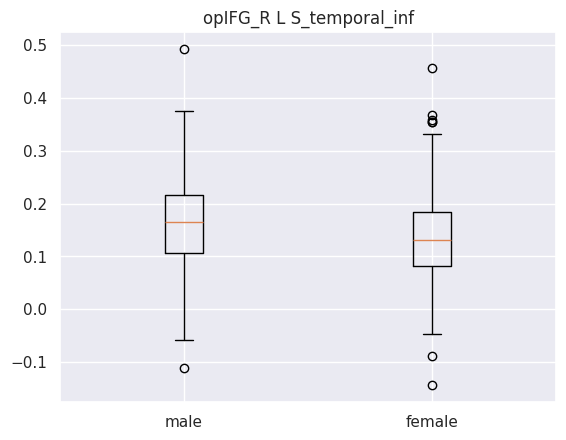

TtestResult(statistic=3.999304532057945, pvalue=7.201816739594884e-05, df=562.0)
male mean : 0.16359765884543725
male std : 0.08562013938577182
female mean : 0.13553582025435218
female std : 0.08060550060216903


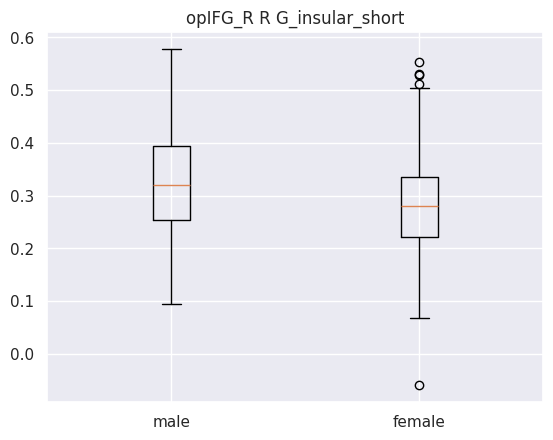

TtestResult(statistic=4.755239251404364, pvalue=2.5221004207170377e-06, df=562.0)
male mean : 0.3230140808745247
male std : 0.09676265794418758
female mean : 0.28459807252159475
female std : 0.09446074604336126


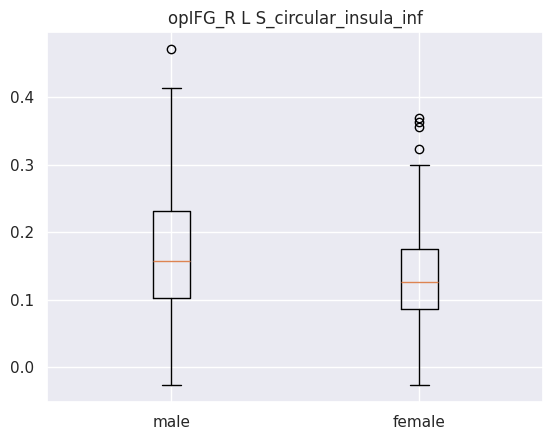

TtestResult(statistic=4.729506412940881, pvalue=2.84980032551188e-06, df=562.0)
male mean : 0.16831194070988592
male std : 0.08857256780970121
female mean : 0.13581089123421927
female std : 0.07430472106915549


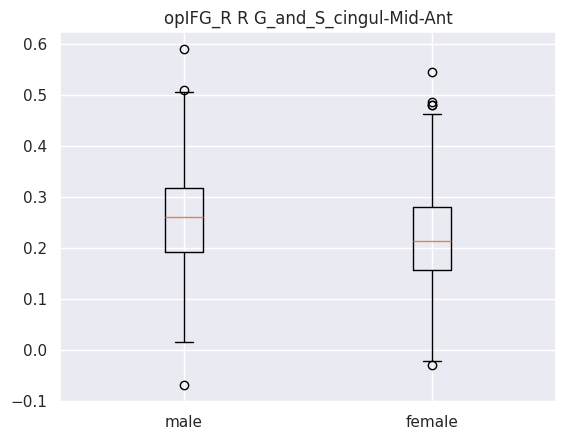

TtestResult(statistic=4.315955845337449, pvalue=1.878004856996765e-05, df=562.0)
male mean : 0.2591957626121673
male std : 0.10347717348701288
female mean : 0.22244813224916943
female std : 0.09819716159475382


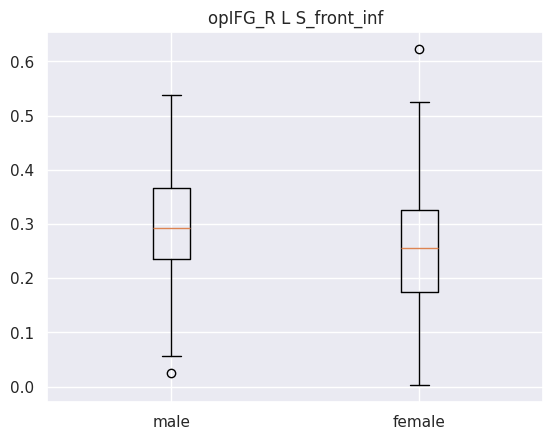

TtestResult(statistic=4.552274802708165, pvalue=6.50948302187859e-06, df=562.0)
male mean : 0.29556017243726235
male std : 0.10059916181337628
female mean : 0.2551695035348837
female std : 0.1085741115925798


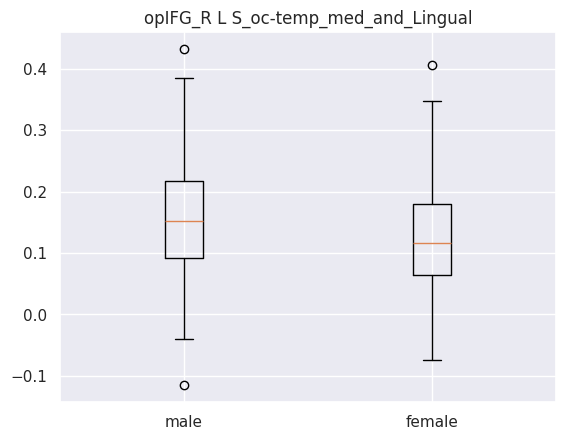

TtestResult(statistic=4.683575774370304, pvalue=3.539150807108733e-06, df=562.0)
male mean : 0.15626952140722436
male std : 0.09076863914735202
female mean : 0.12206103295259137
female std : 0.08235156931391527


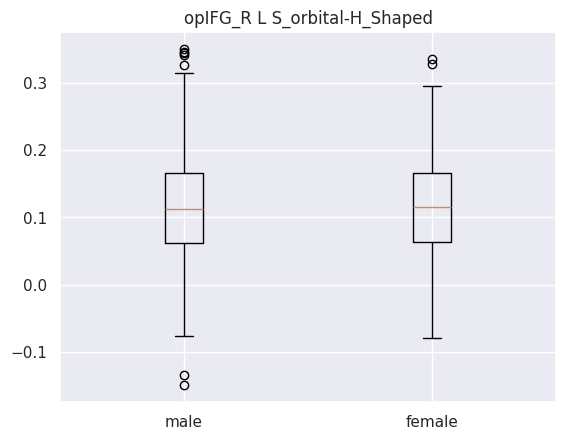

TtestResult(statistic=0.08018520363953263, pvalue=0.9361185029164663, df=562.0)
male mean : 0.11674467021026617
male std : 0.08427527214237461
female mean : 0.11619735501554818
female std : 0.07748459590176046


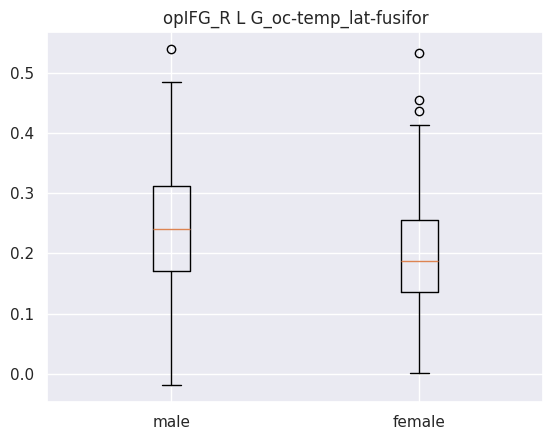

TtestResult(statistic=5.116446900273248, pvalue=4.279565875230344e-07, df=562.0)
male mean : 0.23781104919391638
male std : 0.10129659013704502
female mean : 0.19701569446046513
female std : 0.08772269101356905


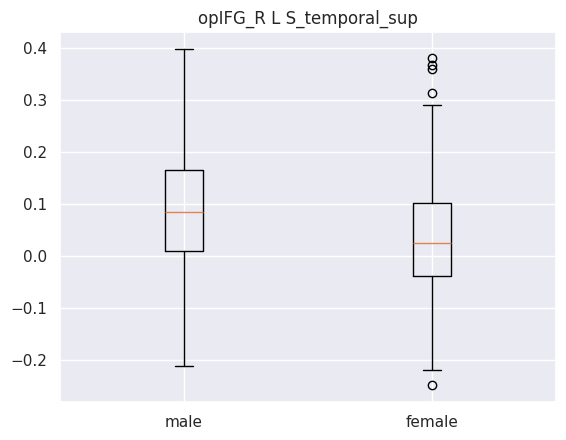

TtestResult(statistic=5.524326061138028, pvalue=5.064125107319705e-08, df=562.0)
male mean : 0.08624977302965779
male std : 0.11597051512705804
female mean : 0.0339136269820598
female std : 0.10848894491895586


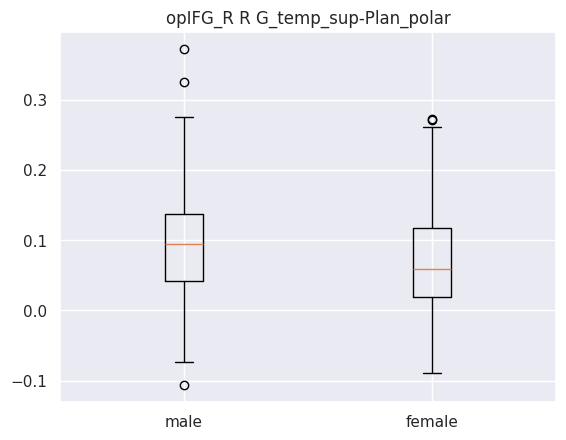

TtestResult(statistic=3.998178487567644, pvalue=7.235199191609884e-05, df=562.0)
male mean : 0.09452694148326996
male std : 0.07617182305141224
female mean : 0.07004874881162791
female std : 0.06894506297581188
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [27]:
rois = ["opIFG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_R)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## pITG_L validation accuracy

Validation accuracy
The mean accuracy : 0.7203955357142857
The standard deviation of the accuracy : 0.03333387828928471
The lower boundry of the confidance interval of the accuracy : 0.6550611342672876
The upper boundry of the confidance interval of the accuracy : 0.7857299371612838

Testing accuracy
    coefficient    seed                       labels
20     0.216484  pITG_L      L G_oc-temp_lat-fusifor
55     0.196815  pITG_L  L S_intrapariet_and_P_trans
47     0.183273  pITG_L      L S_circular_insula_inf
75     0.177509  pITG_L      R G_and_S_occipital_inf
9      0.175085  pITG_L      L G_cingul-Post-ventral
26     0.168961  pITG_L             L G_parietal_sup
72     0.162081  pITG_L             L S_temporal_sup
83     0.156043  pITG_L      R G_cingul-Post-ventral
86     0.142242  pITG_L        R G_front_inf-Orbital
89     0.140574  pITG_L                R G_front_sup
The mean accuracy : 0.8138461538461541
The standard deviation of the accuracy : 0.04262404912795487
The lower bound

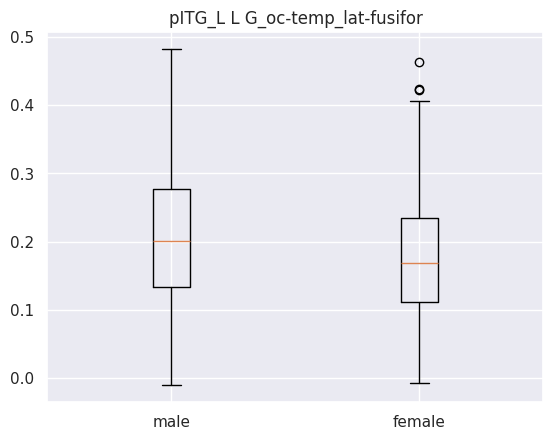

TtestResult(statistic=3.2436073154022718, pvalue=0.001250320411852697, df=562.0)
male mean : 0.2056987803380228
male std : 0.0949520263388171
female mean : 0.18023744266279068
female std : 0.09094138289806177


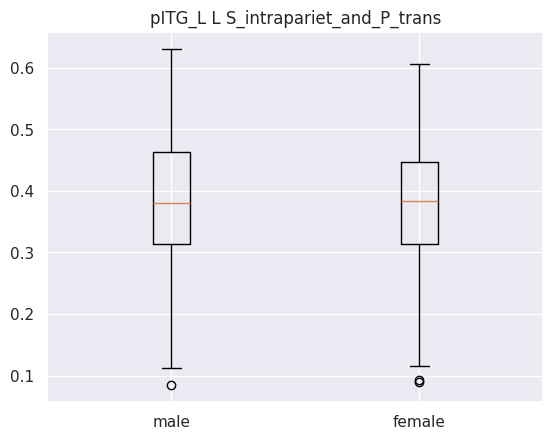

TtestResult(statistic=0.27040597084376106, pvalue=0.7869472193855935, df=562.0)
male mean : 0.38125740577946765
male std : 0.107535777846271
female mean : 0.37889768367441856
female std : 0.0992636491621393


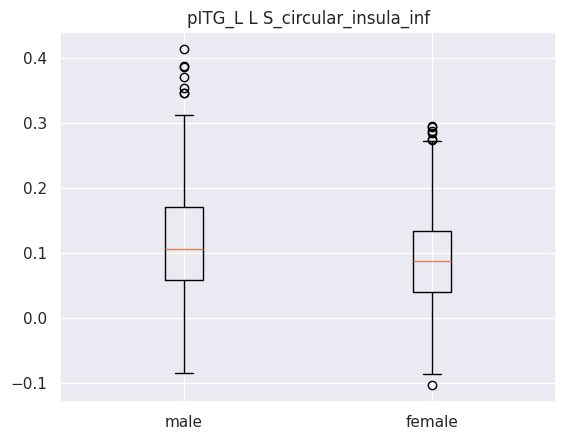

TtestResult(statistic=3.7195183926587134, pvalue=0.00021963865781551026, df=562.0)
male mean : 0.1174053472373384
male std : 0.08606189513888665
female mean : 0.09239644204584717
female std : 0.07332099633027676


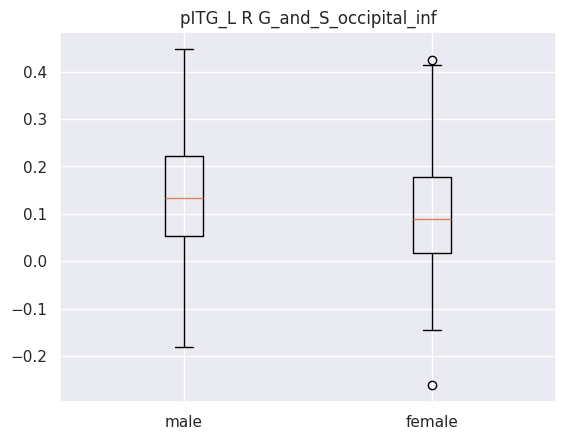

TtestResult(statistic=3.1426765548050595, pvalue=0.0017623399666327859, df=562.0)
male mean : 0.13541462136387833
male std : 0.12025345869257073
female mean : 0.10348527198348836
female std : 0.12006823679231758


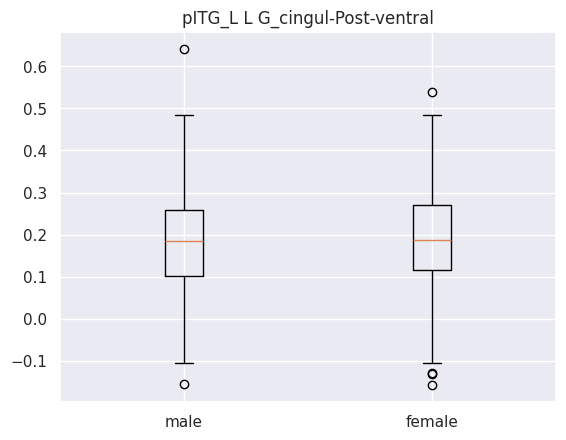

TtestResult(statistic=-0.6639053665916427, pvalue=0.5070231460745944, df=562.0)
male mean : 0.18444210613802278
male std : 0.11264807940923946
female mean : 0.19087066787209303
female std : 0.11611943916831628


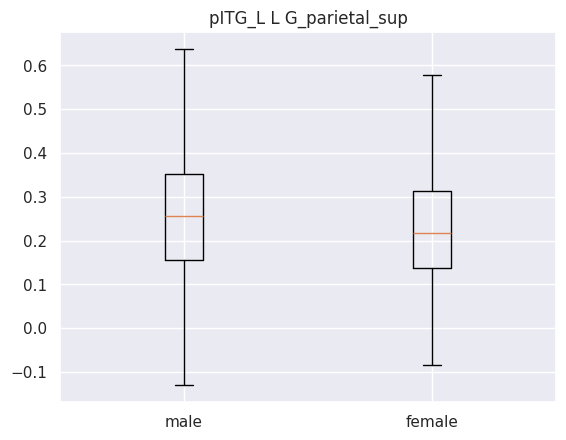

TtestResult(statistic=2.0348237485458296, pvalue=0.04233743219572547, df=562.0)
male mean : 0.25056911626197714
male std : 0.14008685738222976
female mean : 0.22777261343820598
female std : 0.1254813999066985


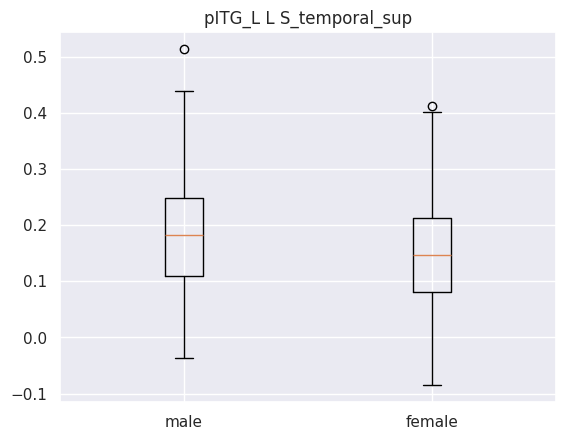

TtestResult(statistic=4.088541314494515, pvalue=4.974571895058776e-05, df=562.0)
male mean : 0.18421520673802283
male std : 0.09953793105497917
female mean : 0.1500996249284053
female std : 0.09792655458301218


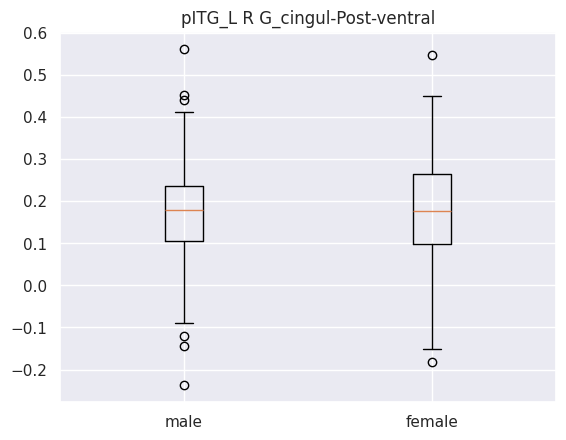

TtestResult(statistic=-0.7087886870276421, pvalue=0.47874952082168243, df=562.0)
male mean : 0.17141985658456652
male std : 0.11182081650600385
female mean : 0.17828767616757477
female std : 0.11695861702316826


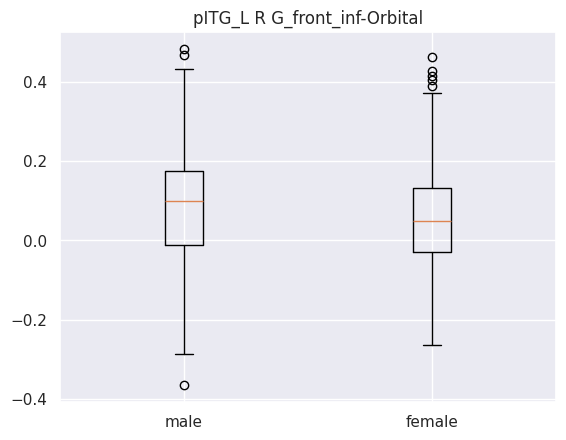

TtestResult(statistic=2.4606260312415023, pvalue=0.014169135796902566, df=562.0)
male mean : 0.08827093163688214
male std : 0.14230262222275855
female mean : 0.05931472846877077
female std : 0.13637430223397143


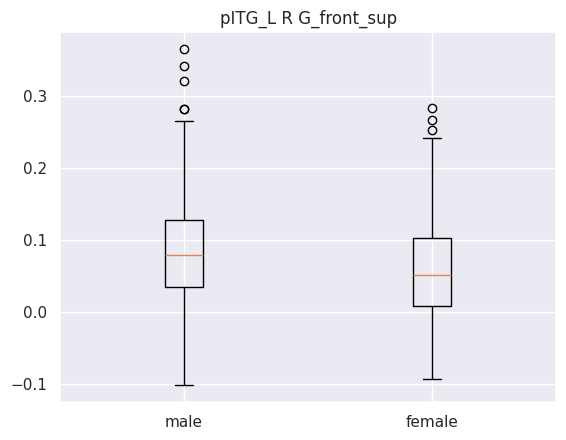

TtestResult(statistic=4.517242898316856, pvalue=7.639659654387745e-06, df=562.0)
male mean : 0.08677324134414449
male std : 0.07544822450822067
female mean : 0.059595708499700986
female std : 0.06717348737175934
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [28]:
rois = ["pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_L)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## pITG_R validation accuracy

Validation accuracy
The mean accuracy : 0.7226866071428573
The standard deviation of the accuracy : 0.031028047494898278
The lower boundry of the confidance interval of the accuracy : 0.6618716340528566
The upper boundry of the confidance interval of the accuracy : 0.7835015802328579

Testing accuracy
     coefficient    seed                     labels
72      0.245017  pITG_R           L S_temporal_sup
20      0.234211  pITG_R    L G_oc-temp_lat-fusifor
84      0.178488  pITG_R                 R G_cuneus
83      0.174114  pITG_R    R G_cingul-Post-ventral
91      0.158866  pITG_R          R G_insular_short
108     0.151957  pITG_R    R G_temp_sup-Plan_polar
47      0.148003  pITG_R    L S_circular_insula_inf
125     0.146670  pITG_R              R S_front_inf
90      0.142652  pITG_R  R G_Ins_lg_and_S_cent_ins
106     0.128266  pITG_R    R G_temp_sup-G_T_transv
The mean accuracy : 0.8058142857142858
The standard deviation of the accuracy : 0.04319393335315837
The lower boundry of the 

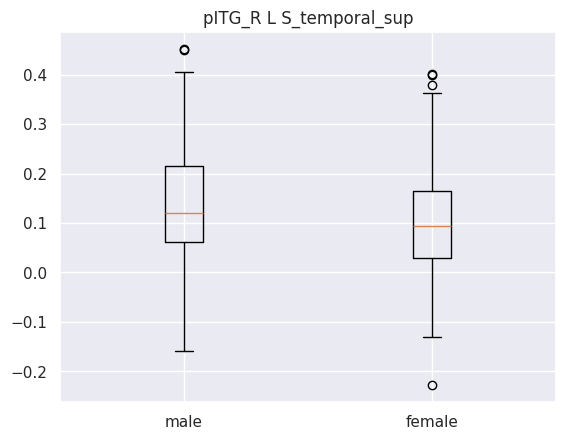

TtestResult(statistic=4.196741356631083, pvalue=3.1469933747888905e-05, df=562.0)
male mean : 0.13739067075551334
male std : 0.11150382462376025
female mean : 0.09954083086165548
female std : 0.10224021375654369


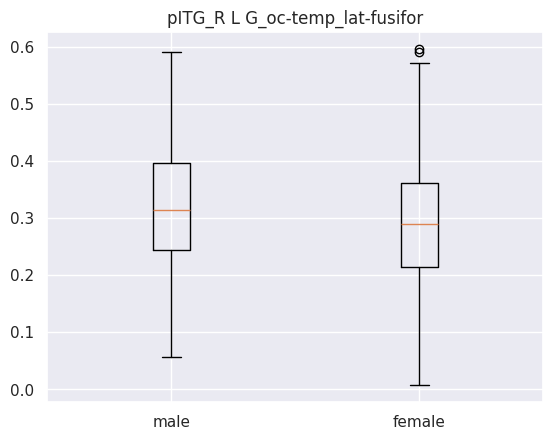

TtestResult(statistic=2.810268986820924, pvalue=0.0051225200608808474, df=562.0)
male mean : 0.31478116888212926
male std : 0.11000102327816882
female mean : 0.2893303569966777
female std : 0.10450615876501394


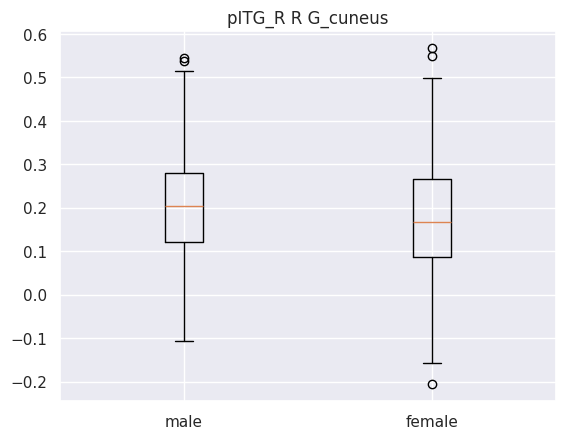

TtestResult(statistic=2.741944633725931, pvalue=0.006302259674511262, df=562.0)
male mean : 0.20491106910646387
male std : 0.1253061895987554
female mean : 0.17536686928538206
female std : 0.12925281281347495


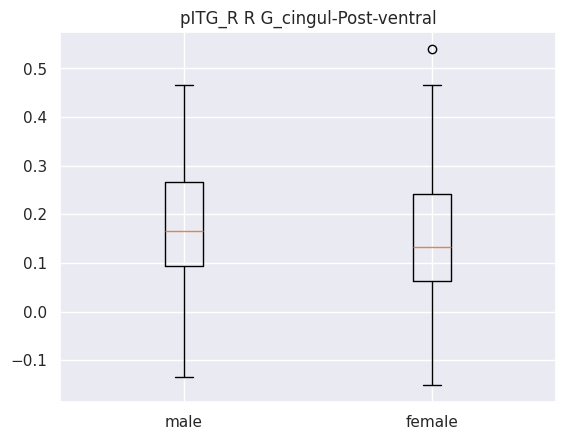

TtestResult(statistic=2.256297345157703, pvalue=0.024435481782569664, df=562.0)
male mean : 0.1744766429752852
male std : 0.12132968449125979
female mean : 0.15124980597607973
female std : 0.12210294696125819


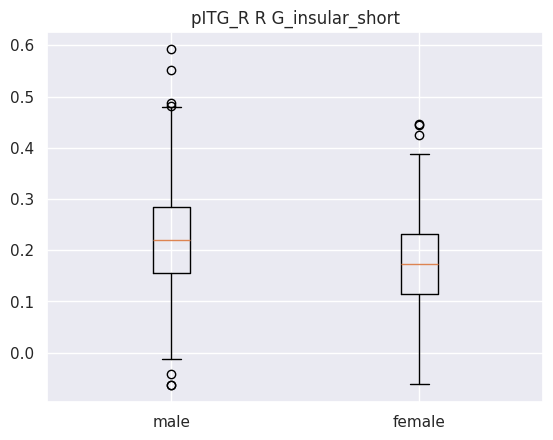

TtestResult(statistic=5.697103263903745, pvalue=1.9674615344309902e-08, df=562.0)
male mean : 0.2223536750768061
male std : 0.10572708474473759
female mean : 0.1753717551358804
female std : 0.08975183305485177


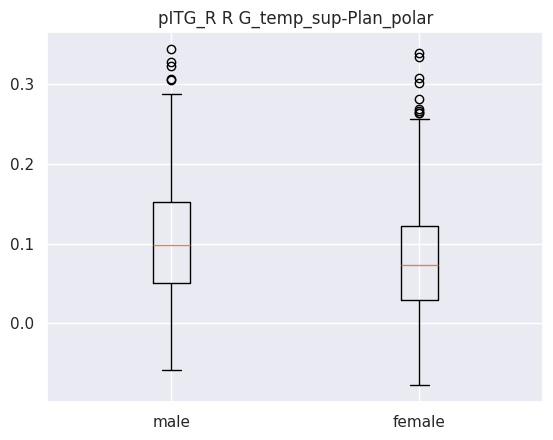

TtestResult(statistic=3.829041740563084, pvalue=0.00014311201699602173, df=562.0)
male mean : 0.10721168719125476
male std : 0.07701199955956235
female mean : 0.08294021107918272
female std : 0.07312878001906238


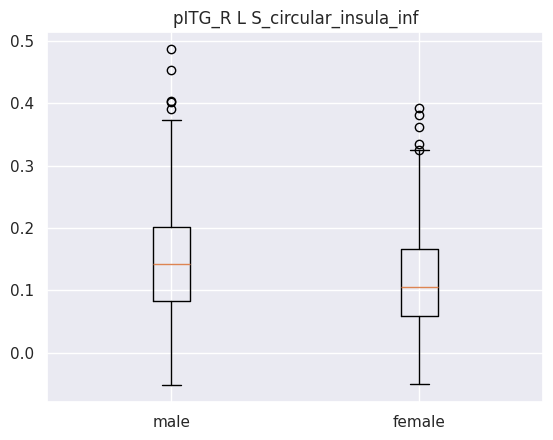

TtestResult(statistic=4.781913144179267, pvalue=2.220814202786064e-06, df=562.0)
male mean : 0.15037180967528518
male std : 0.09196590825401321
female mean : 0.1155669789617608
female std : 0.08058036286207322


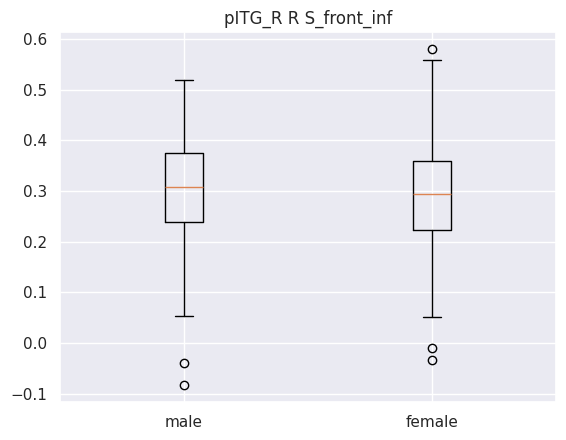

TtestResult(statistic=1.6379189328233394, pvalue=0.10199833222671245, df=562.0)
male mean : 0.3043051077718631
male std : 0.0983610871491745
female mean : 0.29073446122923585
female std : 0.09765466159601431


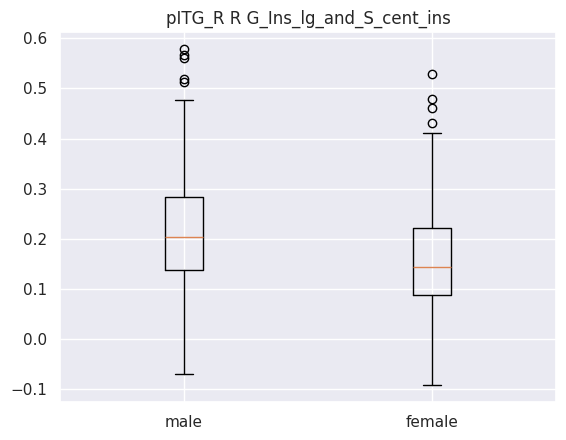

TtestResult(statistic=5.486391849912401, pvalue=6.211989721615117e-08, df=562.0)
male mean : 0.21126798055245247
male std : 0.11577453686272864
female mean : 0.15978842567976745
female std : 0.10659117860011406


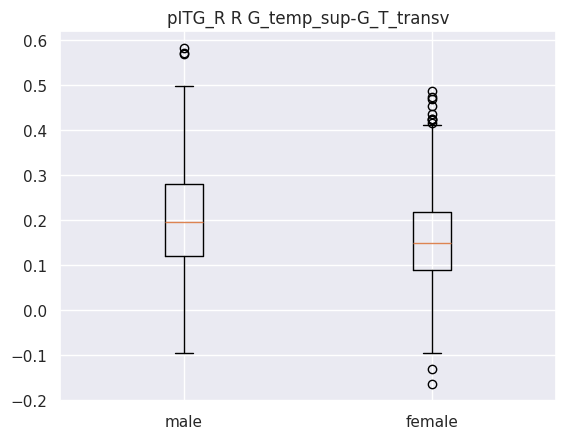

TtestResult(statistic=4.858246945744738, pvalue=1.5379842834630926e-06, df=562.0)
male mean : 0.20724551101216732
male std : 0.12132483078283902
female mean : 0.16001330873255815
female std : 0.10912756866493428
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [29]:
rois = ["pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_R)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## planumtemp_L validation accuracy

Validation accuracy
The mean accuracy : 0.6787017857142857
The standard deviation of the accuracy : 0.03101105952942845
The lower boundry of the confidance interval of the accuracy : 0.617920109036606
The upper boundry of the confidance interval of the accuracy : 0.7394834623919655

Testing accuracy
     coefficient          seed                       labels
60      0.272791  planumtemp_L  L S_oc-temp_med_and_Lingual
20      0.197290  planumtemp_L      L G_oc-temp_lat-fusifor
108     0.184403  planumtemp_L      R G_temp_sup-Plan_polar
89      0.174926  planumtemp_L                R G_front_sup
88      0.166236  planumtemp_L             R G_front_middle
30      0.164738  planumtemp_L                   L G_rectus
15      0.155595  planumtemp_L                L G_front_sup
46      0.153759  planumtemp_L      L S_circular_insula_ant
84      0.149002  planumtemp_L                   R G_cuneus
43      0.144700  planumtemp_L                L S_calcarine
The mean accuracy : 0.8112472527472528


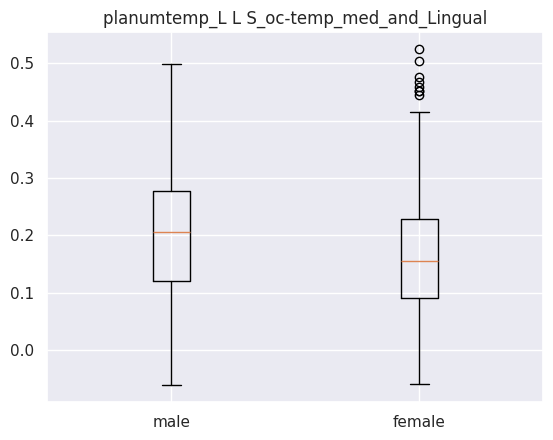

TtestResult(statistic=3.5535200840172108, pvalue=0.0004120710964530877, df=562.0)
male mean : 0.20138468446653993
male std : 0.10697193315909369
female mean : 0.1691071645282392
female std : 0.10781293661679399


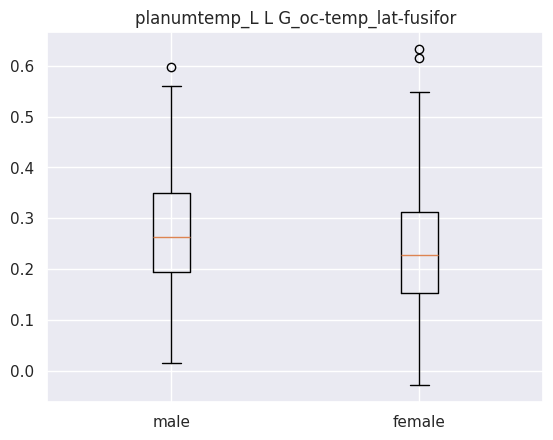

TtestResult(statistic=3.8640363181268467, pvalue=0.00012453051309743143, df=562.0)
male mean : 0.273934721608365
male std : 0.11618899538515358
female mean : 0.23664216192325582
female std : 0.11231573519663951


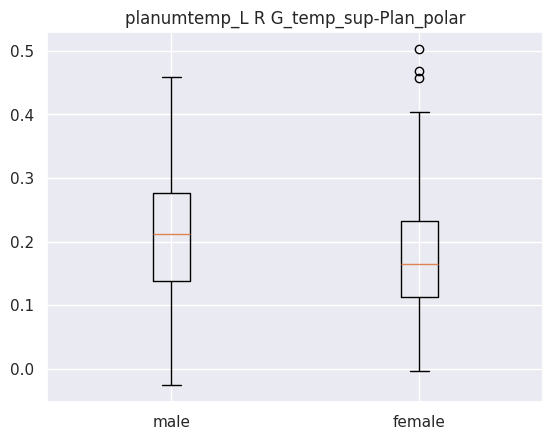

TtestResult(statistic=4.754095906522838, pvalue=2.535856882720888e-06, df=562.0)
male mean : 0.2124789285969582
male std : 0.09186190010679225
female mean : 0.1759663873843854
female std : 0.08991669369361606


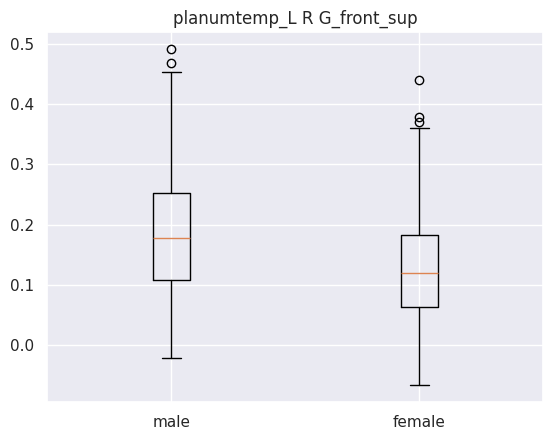

TtestResult(statistic=7.005723286524496, pvalue=7.053092520728604e-12, df=562.0)
male mean : 0.1842207737676046
male std : 0.09752786905164766
female mean : 0.12974268123255814
female std : 0.08681164436850244


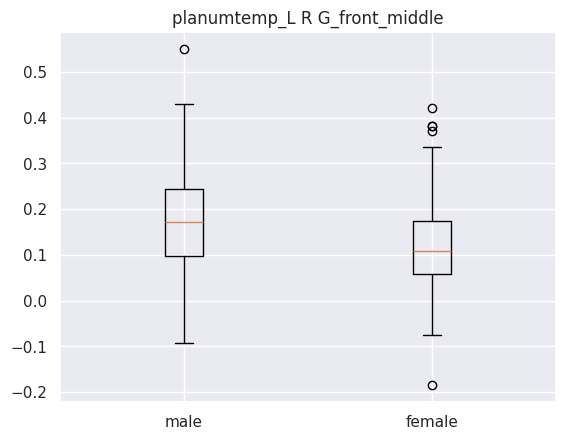

TtestResult(statistic=7.083051952003173, pvalue=4.234418336006045e-12, df=562.0)
male mean : 0.17561467015703422
male std : 0.10099648809567767
female mean : 0.11818345196269103
female std : 0.09119635254658147


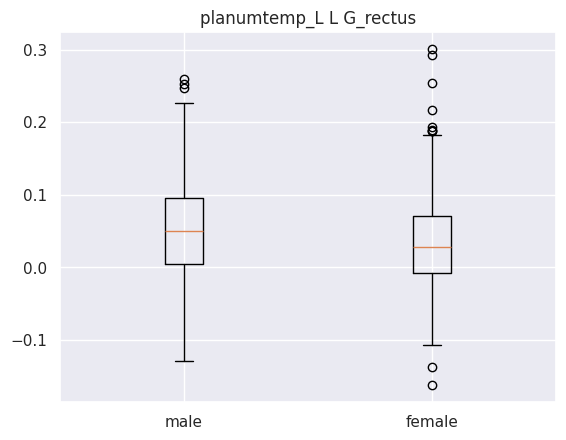

TtestResult(statistic=2.7512545363189393, pvalue=0.006128244861950536, df=562.0)
male mean : 0.05109769466604562
male std : 0.07154061416307267
female mean : 0.035068776211362125
female std : 0.06650833816517755


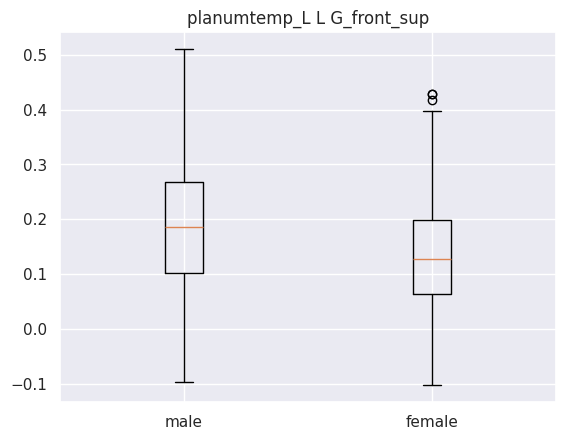

TtestResult(statistic=5.407175582759948, pvalue=9.480994088922564e-08, df=562.0)
male mean : 0.1847222246946768
male std : 0.10853704509636099
female mean : 0.1378197862071096
female std : 0.0970820399251973


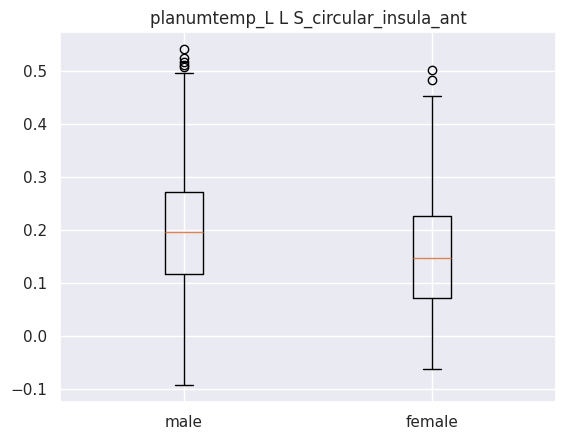

TtestResult(statistic=5.295878089071948, pvalue=1.7022944020464566e-07, df=562.0)
male mean : 0.19804154381558936
male std : 0.11582912808678585
female mean : 0.1486483528654485
female std : 0.10523323363768806


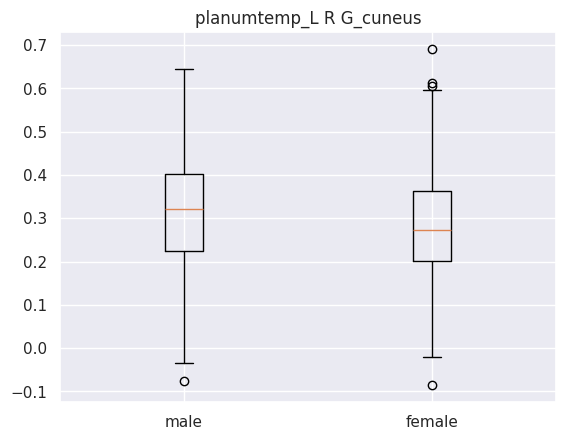

TtestResult(statistic=2.6332203846527364, pvalue=0.008690739418219037, df=562.0)
male mean : 0.3126405191102661
male std : 0.13014578879944402
female mean : 0.28439145074983385
female std : 0.12394148026000948


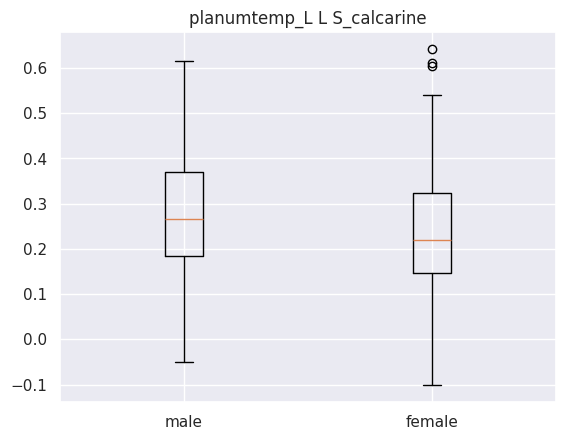

TtestResult(statistic=3.141316233107298, pvalue=0.001770403211946406, df=562.0)
male mean : 0.274296150904943
male std : 0.1280515167012644
female mean : 0.2400809567398671
female std : 0.12947348397677685
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [30]:
rois = ["planumtemp_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_L)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## planumtemp_R validation accuracy

Validation accuracy
The mean accuracy : 0.7161901785714286
The standard deviation of the accuracy : 0.02972316347408007
The lower boundry of the confidance interval of the accuracy : 0.6579327781622317
The upper boundry of the confidance interval of the accuracy : 0.7744475789806256

Testing accuracy
     coefficient          seed                       labels
47      0.247497  planumtemp_R      L S_circular_insula_inf
60      0.220485  planumtemp_R  L S_oc-temp_med_and_Lingual
72      0.198438  planumtemp_R             L S_temporal_sup
15      0.184691  planumtemp_R                L G_front_sup
108     0.176657  planumtemp_R      R G_temp_sup-Plan_polar
139     0.156045  planumtemp_R             R S_pericallosal
71      0.151812  planumtemp_R             L S_temporal_inf
43      0.145704  planumtemp_R                L S_calcarine
121     0.139154  planumtemp_R      R S_circular_insula_inf
20      0.139115  planumtemp_R      L G_oc-temp_lat-fusifor
The mean accuracy : 0.7981670329670331

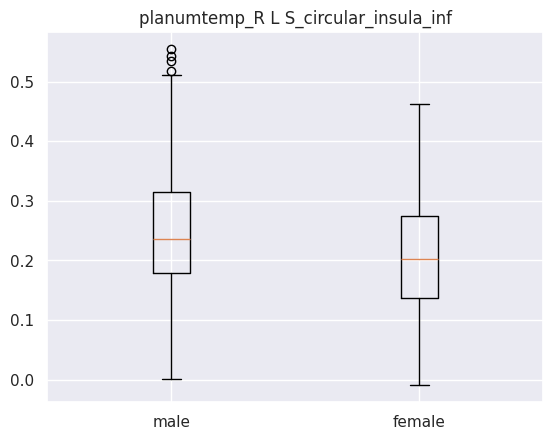

TtestResult(statistic=4.754592848867569, pvalue=2.5298689374709147e-06, df=562.0)
male mean : 0.24664524678136882
male std : 0.09996404948497183
female mean : 0.20796517266445183
female std : 0.09280734872241128


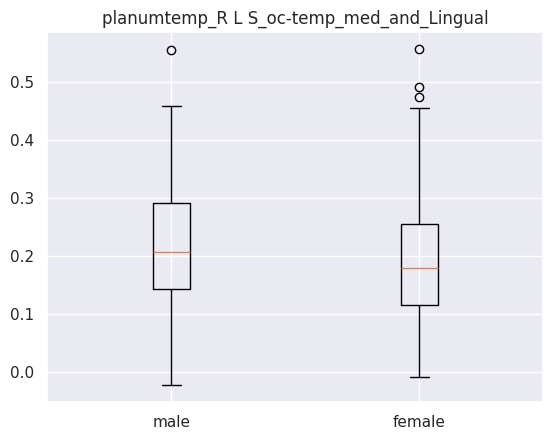

TtestResult(statistic=2.8830998134021852, pvalue=0.004088548964724054, df=562.0)
male mean : 0.21623359568707226
male std : 0.10598136025556922
female mean : 0.1909124683142857
female std : 0.10198184189373703


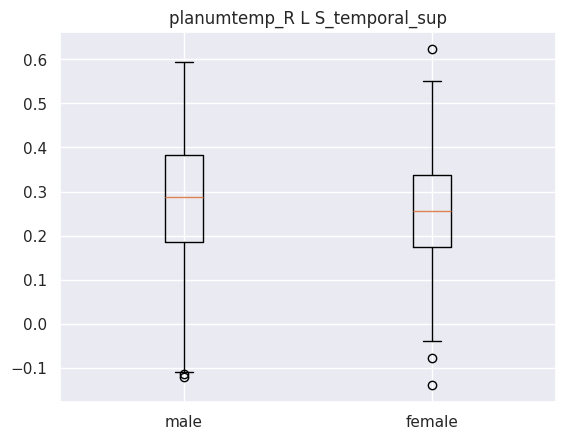

TtestResult(statistic=1.9939713075469714, pvalue=0.04663794806816013, df=562.0)
male mean : 0.27949129047262355
male std : 0.13856078867444266
female mean : 0.2574814225966777
female std : 0.1231077975974857


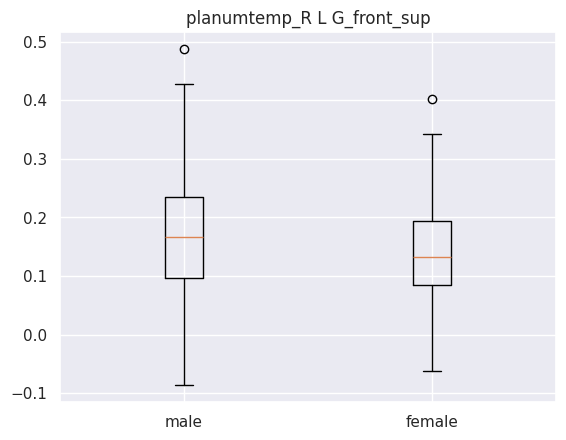

TtestResult(statistic=3.245882136071958, pvalue=0.0012405568276112682, df=562.0)
male mean : 0.16498520389163499
male std : 0.09957579450944844
female mean : 0.1399915779053156
female std : 0.08291453993537845


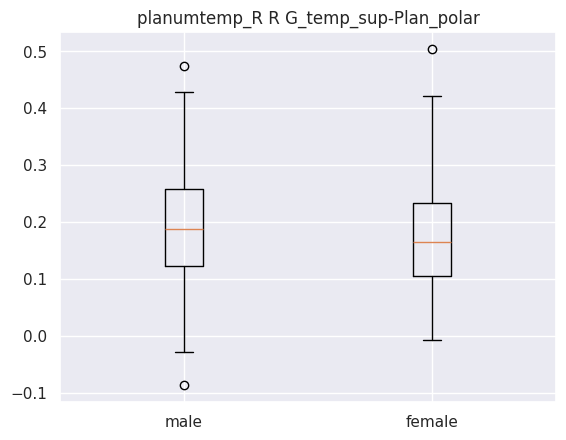

TtestResult(statistic=2.321906417293724, pvalue=0.02059447944633167, df=562.0)
male mean : 0.19231692340304182
male std : 0.09008408764482337
female mean : 0.17497604091495014
female std : 0.08675608750582152


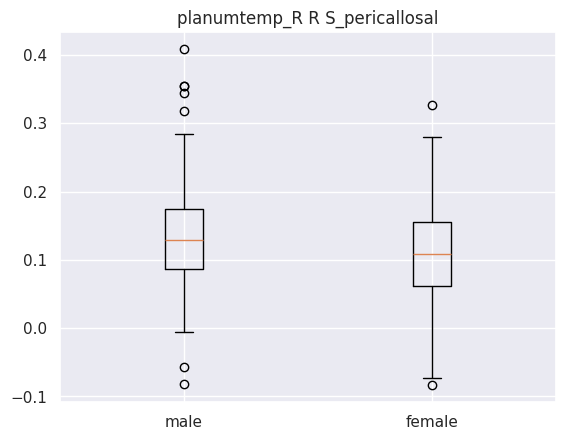

TtestResult(statistic=4.21027853272709, pvalue=2.969654392292594e-05, df=562.0)
male mean : 0.13301439208163496
male std : 0.07336478835843015
female mean : 0.1079359846166113
female std : 0.06778752300317713


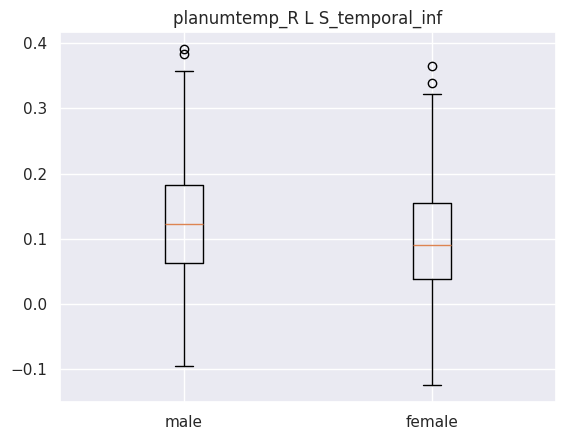

TtestResult(statistic=4.049222830336931, pvalue=5.8603819974747696e-05, df=562.0)
male mean : 0.1273490176038023
male std : 0.08907206784454609
female mean : 0.09867424826245848
female std : 0.07880369672469549


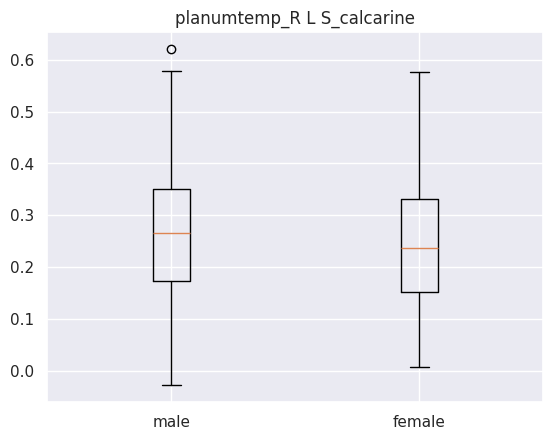

TtestResult(statistic=2.002991768199032, pvalue=0.045657919237324006, df=562.0)
male mean : 0.26823541858505706
male std : 0.12784499132396293
female mean : 0.24731367291561462
female std : 0.11963048968200794


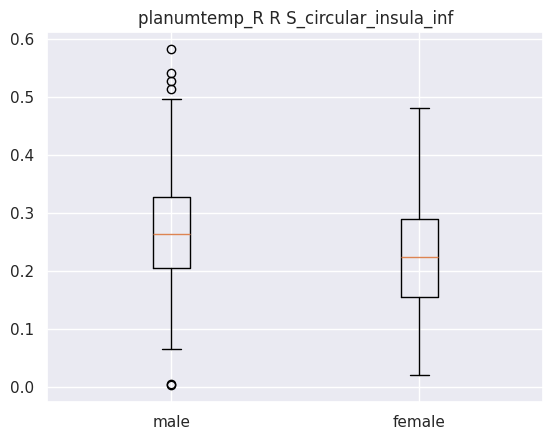

TtestResult(statistic=4.926397277096471, pvalue=1.103284155465702e-06, df=562.0)
male mean : 0.2661869187410647
male std : 0.09527302507599171
female mean : 0.22700655812956813
female std : 0.09298067524697533


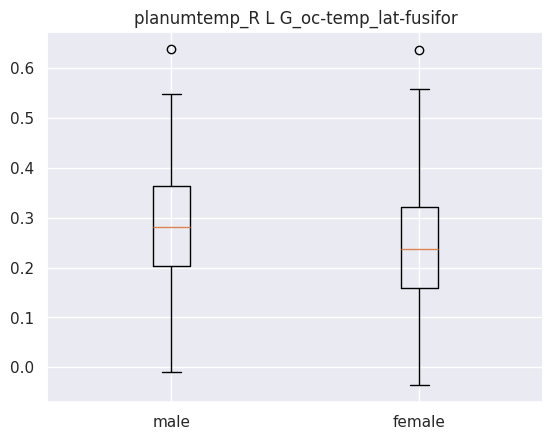

TtestResult(statistic=4.153958282783595, pvalue=3.77618536555217e-05, df=562.0)
male mean : 0.28594790805589354
male std : 0.11929345196444417
female mean : 0.24477274405647842
female std : 0.11538894637809151
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [31]:
rois = ["planumtemp_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_R)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## all left validation accuracy

Validation accuracy
The mean accuracy : 0.7664080357142857
The standard deviation of the accuracy : 0.03038674857563284
The lower boundry of the confidance interval of the accuracy : 0.7068500085060454
The upper boundry of the confidance interval of the accuracy : 0.8259660629225261

Testing accuracy
     coefficient          seed                       labels
55      0.092611       opIFG_L  L S_intrapariet_and_P_trans
351     0.091558        aMTG_L  L S_intrapariet_and_P_trans
98      0.090037       opIFG_L       R G_pariet_inf-Angular
322     0.083811        aMTG_L             L G_parietal_sup
504     0.082999        pITG_L  L S_oc-temp_med_and_Lingual
53      0.082910       opIFG_L                L S_front_sup
112     0.080484       opIFG_L       R Lat_Fis-ant-Horizont
189     0.077590  planumtemp_L             L Pole_occipital
64      0.073008       opIFG_L        L S_parieto_occipital
289     0.071791  planumtemp_L      R S_precentral-inf-part
The mean accuracy : 0.9083032967032968

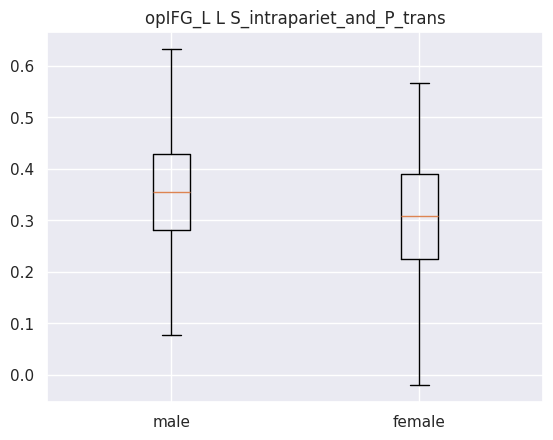

TtestResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07, df=562.0)
male mean : 0.35213074777946773
male std : 0.10658887449917556
female mean : 0.3031099729109635
female std : 0.12130464463020163


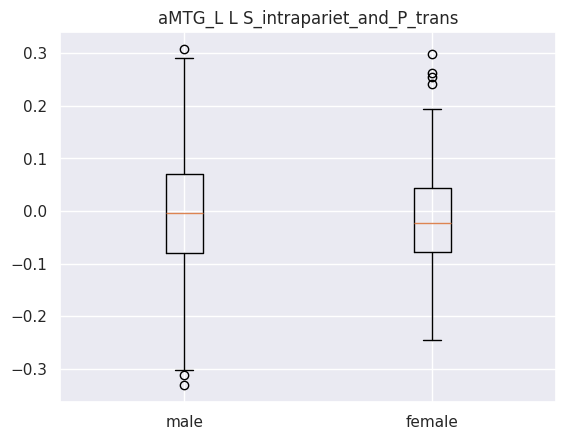

TtestResult(statistic=0.9647641183387371, pvalue=0.3350779189775276, df=562.0)
male mean : -0.004121455086692014
male std : 0.11166920373773248
female mean : -0.012516677279534883
female std : 0.09459673974350062


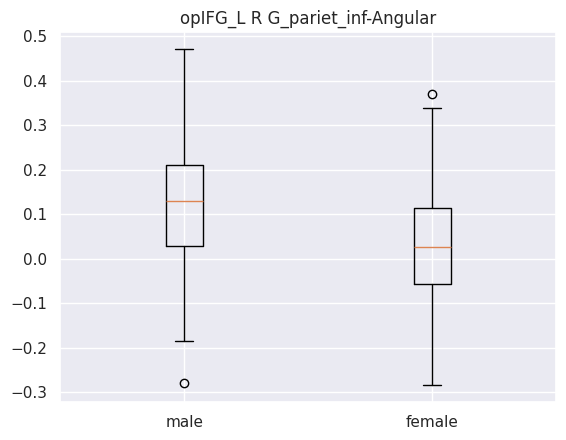

TtestResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14, df=562.0)
male mean : 0.11766997985152092
male std : 0.13076288558639354
female mean : 0.03601953544850498
female std : 0.12000095132461792


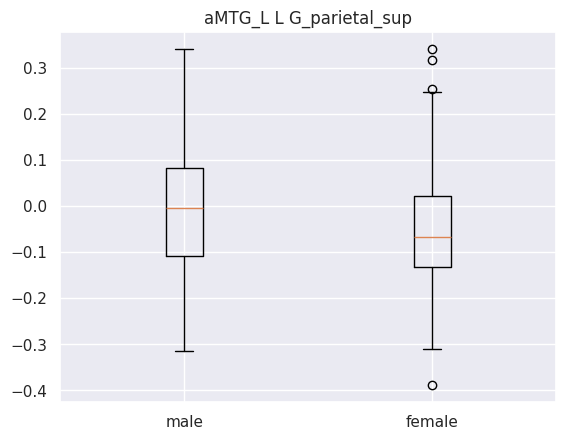

TtestResult(statistic=4.059890719730225, pvalue=5.606265792321045e-05, df=562.0)
male mean : -0.006850357185019011
male std : 0.13629850229203536
female mean : -0.05038483464086378
female std : 0.11790512188118459


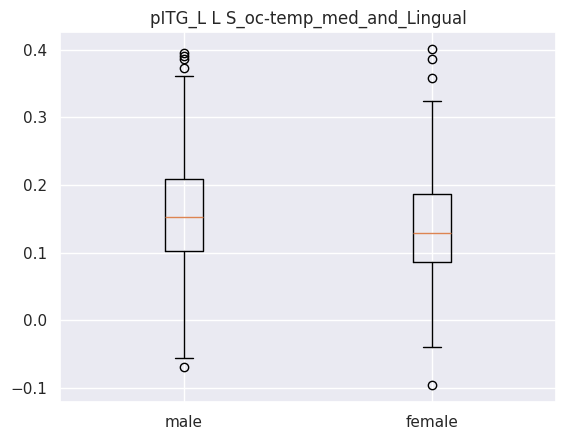

TtestResult(statistic=3.01993636806222, pvalue=0.002643129220462383, df=562.0)
male mean : 0.1601642877536882
male std : 0.08334523805349907
female mean : 0.13959590949933556
female std : 0.07802101521527612


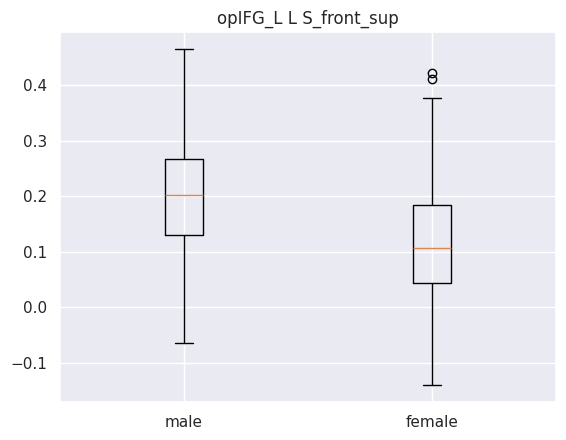

TtestResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22, df=562.0)
male mean : 0.1996858131581749
male std : 0.10098467263884126
female mean : 0.11606861896099667
female std : 0.09690605329034335


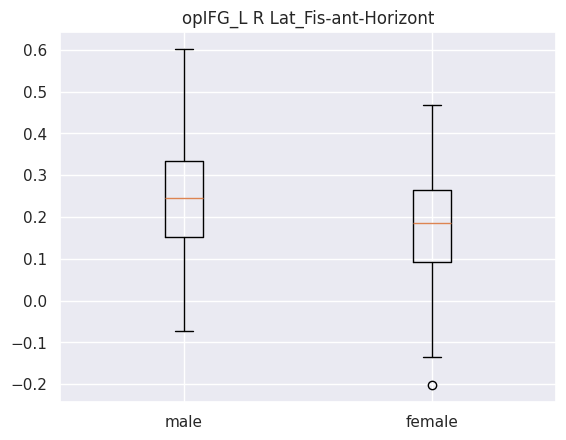

TtestResult(statistic=5.523000631402005, pvalue=5.100505325642233e-08, df=562.0)
male mean : 0.24211566314486693
male std : 0.1271295065963186
female mean : 0.1834664979807309
female std : 0.1242192947210725


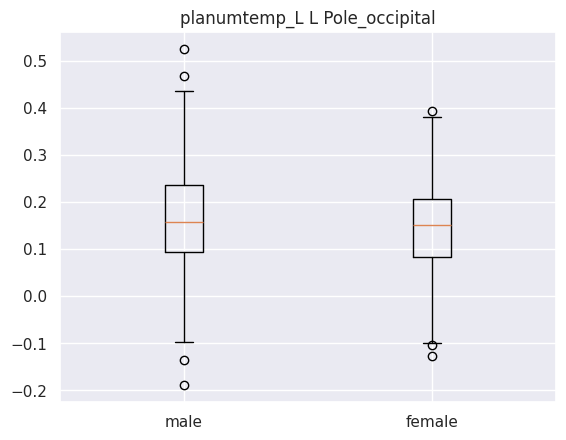

TtestResult(statistic=2.486200541931443, pvalue=0.013200894125973316, df=562.0)
male mean : 0.16626784924790874
male std : 0.11264322709736568
female mean : 0.14439602449857145
female std : 0.09589248593995307


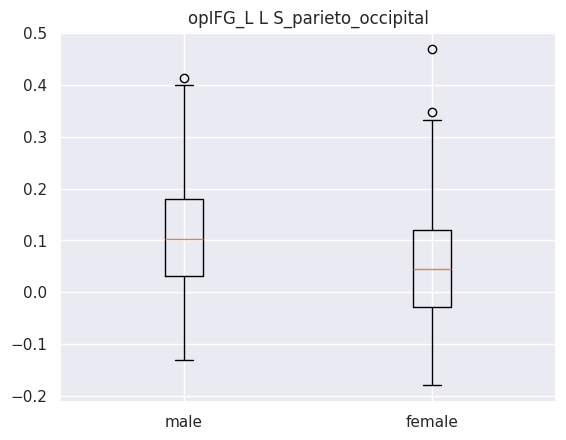

TtestResult(statistic=6.503523668812626, pvalue=1.7355351061785972e-10, df=562.0)
male mean : 0.10978782784771862
male std : 0.10910224511601631
female mean : 0.05152286066817276
female std : 0.10312061557532284


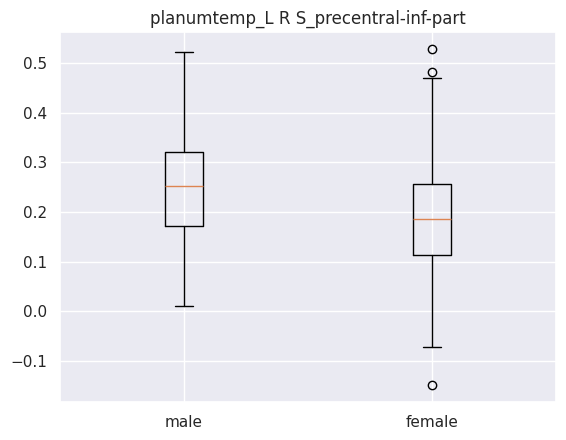

TtestResult(statistic=6.661596434253874, pvalue=6.466066049307999e-11, df=562.0)
male mean : 0.24825770865209126
male std : 0.10581376490956317
female mean : 0.18842824199003325
female std : 0.10656486241157793
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [32]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_left)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## all right validation accuracy

Validation accuracy
The mean accuracy : 0.7780455357142857
The standard deviation of the accuracy : 0.026458403153196752
The lower boundry of the confidance interval of the accuracy : 0.72618706553402
The upper boundry of the confidance interval of the accuracy : 0.8299040058945514

Testing accuracy
     coefficient          seed                       labels
504     0.099310        pITG_R  L S_oc-temp_med_and_Lingual
55      0.089950       opIFG_R  L S_intrapariet_and_P_trans
64      0.087628       opIFG_R        L S_parieto_occipital
66      0.087567       opIFG_R              L S_postcentral
421     0.086206        aMTG_R                R S_front_inf
22      0.083899       opIFG_R      L G_oc-temp_med-Parahip
219     0.081906  planumtemp_R             L S_temporal_inf
487     0.078703        pITG_R                L S_calcarine
53      0.077693       opIFG_R                L S_front_sup
90      0.075714       opIFG_R    R G_Ins_lg_and_S_cent_ins
The mean accuracy : 0.8953670329670331


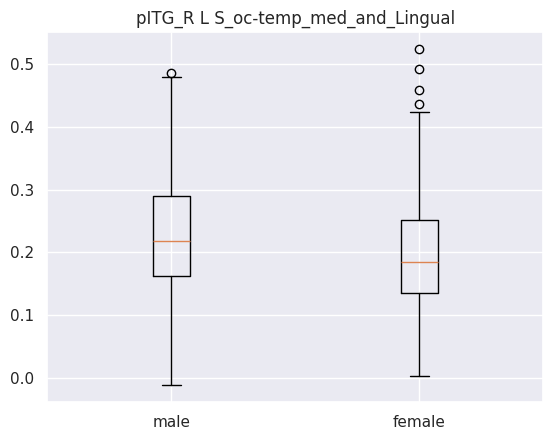

TtestResult(statistic=3.658497216134596, pvalue=0.00027757468582203013, df=562.0)
male mean : 0.2244769810418251
male std : 0.09519528685578532
female mean : 0.19555248922657806
female std : 0.09199381053279175


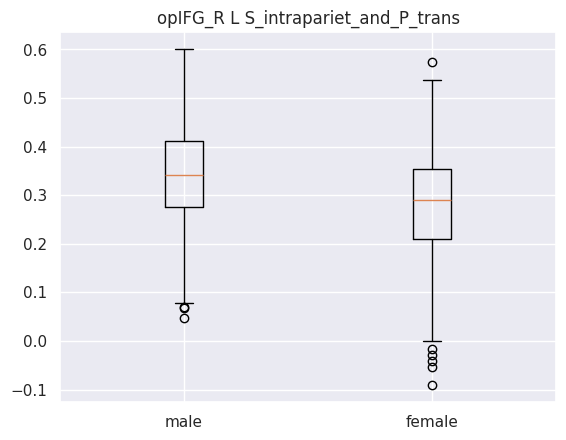

TtestResult(statistic=6.549265565385064, pvalue=1.3068216656533926e-10, df=562.0)
male mean : 0.33881895684790875
male std : 0.1057801295230776
female mean : 0.2786800312584718
female std : 0.11099764729269487


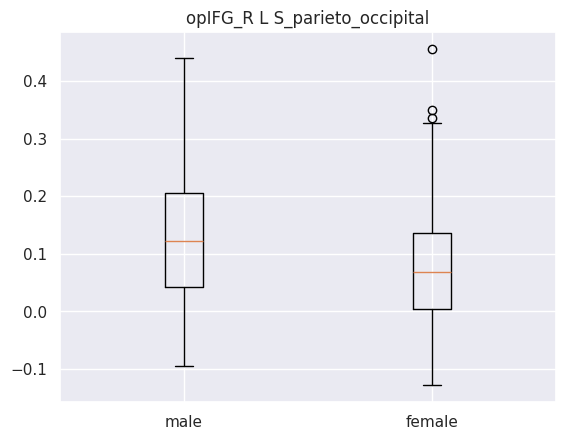

TtestResult(statistic=6.286996654261317, pvalue=6.50249277681862e-10, df=562.0)
male mean : 0.13124042186996196
male std : 0.11092566474938649
female mean : 0.07599817451156146
female std : 0.09737712149945338


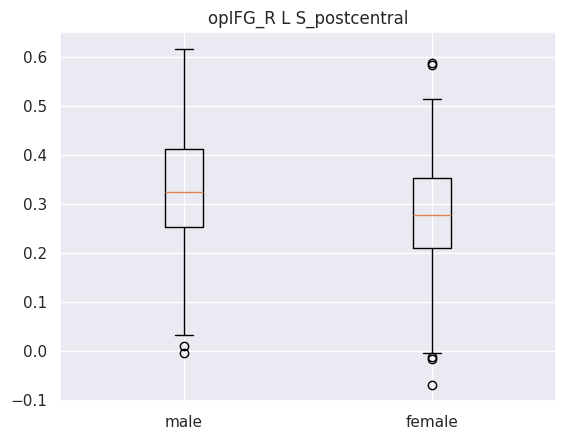

TtestResult(statistic=5.271054566169988, pvalue=1.9369475536514105e-07, df=562.0)
male mean : 0.32780815557186316
male std : 0.11020463879720373
female mean : 0.27874649102691035
female std : 0.10996457294736237


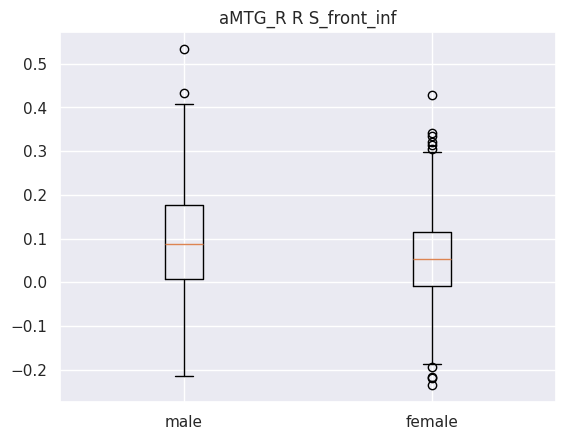

TtestResult(statistic=4.148252422200393, pvalue=3.868639529214971e-05, df=562.0)
male mean : 0.09520096379193917
male std : 0.11824387845447384
female mean : 0.055367278695980064
female std : 0.10930840275035555


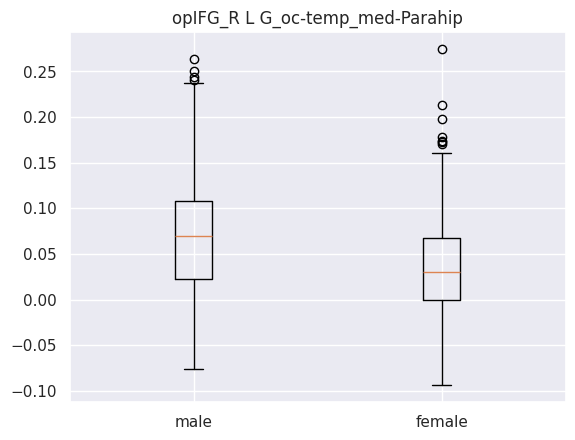

TtestResult(statistic=6.251330329526955, pvalue=8.05447977290333e-10, df=562.0)
male mean : 0.06960421543711026
male std : 0.06330536688799167
female mean : 0.0386048876523588
female std : 0.054245949420823225


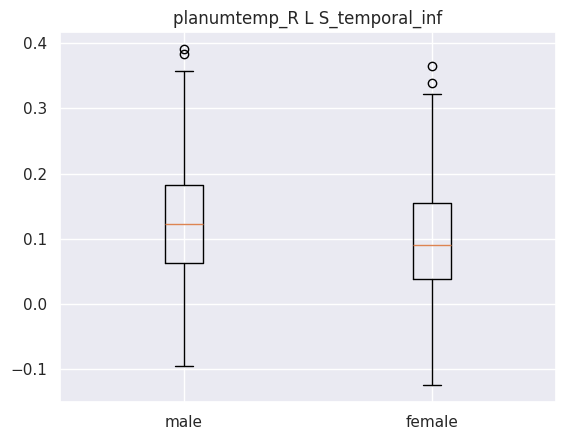

TtestResult(statistic=4.049222830336931, pvalue=5.8603819974747696e-05, df=562.0)
male mean : 0.1273490176038023
male std : 0.08907206784454609
female mean : 0.09867424826245848
female std : 0.07880369672469549


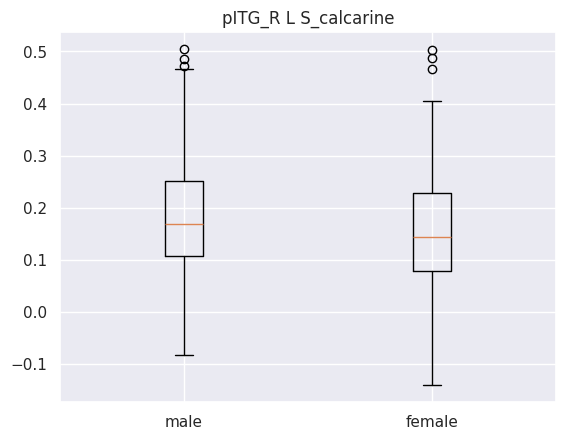

TtestResult(statistic=3.2351347094550422, pvalue=0.0012873143650390924, df=562.0)
male mean : 0.18480961091102663
male std : 0.10817911899491708
female mean : 0.1554359898385382
female std : 0.10667308658653767


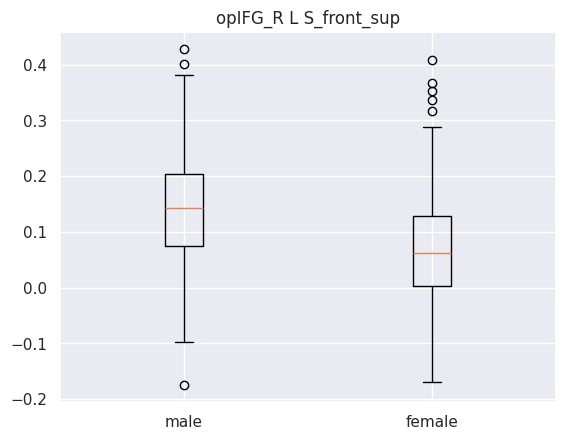

TtestResult(statistic=8.712491197032197, pvalue=3.331022559866575e-17, df=562.0)
male mean : 0.14132478689695815
male std : 0.10025857372653
female mean : 0.06850368978538206
female std : 0.097597589175656


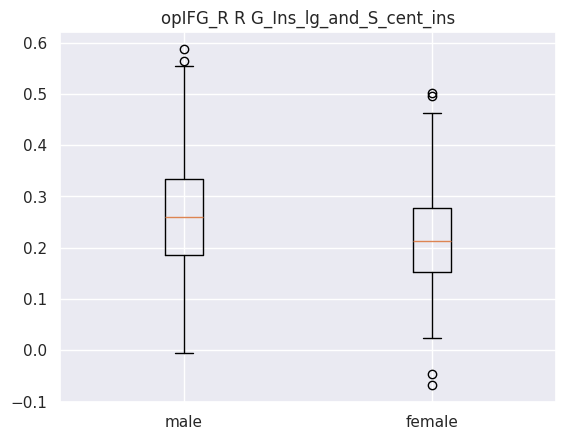

TtestResult(statistic=5.071136490485997, pvalue=5.378396910376465e-07, df=562.0)
male mean : 0.26213691595703426
male std : 0.10720353737692727
female mean : 0.21789970354485053
female std : 0.0995023351316182
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [33]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_right)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Test classification feature by feature on an independent set

In [37]:
# 189      0.059589  planumtemp_L             L Pole_occipital
# 98       0.055317       opIFG_L       R G_pariet_inf-Angular
# 351      0.049720        aMTG_L  L S_intrapariet_and_P_trans
# 55       0.048553       opIFG_L  L S_intrapariet_and_P_trans
# 1096     0.047908        pITG_R  L S_oc-temp_med_and_Lingual
# 504      0.047085        pITG_L  L S_oc-temp_med_and_Lingual
# 64       0.045608       opIFG_L        L S_parieto_occipital
# 53       0.043577       opIFG_L                L S_front_sup
# 1112     0.042649        pITG_R        R G_and_S_paracentral
# 1013     0.042049        aMTG_R                R S_front_inf

# the best feature (seed and their region)
seeds = ["planumtemp_L", "opIFG_L", "aMTG_L", "opIFG_L", "pITG_R", "pITG_L" , "opIFG_L", "opIFG_L", "pITG_R", "aMTG_R"]
regions = ["L_Pole_occipital", 
          "R_G_pariet_inf-Angular", 
          "L_S_intrapariet_and_P_trans", 
          "L_S_intrapariet_and_P_trans", 
          "L_S_oc-temp_med_and_Lingual", 
          "L_S_oc-temp_med_and_Lingual",
           "L_S_parieto_occipital",
         "L_S_front_sup",
         "R_G_and_S_paracentral",
         "R_S_front_inf"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_voxelcorrelations/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__voxelcorrelations.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/validation_set.csv")

x = []
y = []
for i in range(0, len(seeds)):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    signal = loaded[seeds[i]+"__"+regions[i]]
    for subject in Final_df["subject_label"]:
        sub_sex = Final_df.loc[Final_df["subject_label"] == subject]["Gender"].values[0]
        value = loaded.loc[loaded["Unnamed: 0"] == "sub-"+str(subject)][seeds[i]+"__"+regions[i]].values[0]
        x.append(value)
        y.append(sub_sex)
    x = np.asarray(x)
    x = x.reshape(-1,1)
    print("Testing : "+seeds[i]+" "+regions[i])
    machine_learning(x,y)
    print("\n")
    x = []
    y = []
        

Testing : planumtemp_L L_Pole_occipital
train: 89 test: 23


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.4 , 0.2 , 0.8 , 0.4 , 0.8 , 0.4 , 0.8 , 0.4 , 0.4 , 0.5 , 0.25,
       0.5 , 0.5 , 0.25, 1.  , 0.5 , 0.5 , 0.5 , 0.75, 0.75])]
predicted class  Femme  Homme
actual class                 
Femme                6      5
Homme                7      5
accuracy test (r2) = 0.4782608695652174
accuracy train (r2) = 0.5280898876404494


Testing : opIFG_L R_G_pariet_inf-Angular
train: 89 test: 23


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.4 , 0.6 , 1.  , 0.4 , 0.6 , 0.4 , 0.6 , 0.8 , 0.8 , 0.5 , 0.5 ,
       0.5 , 1.  , 0.5 , 0.75, 0.25, 0.5 , 0.5 , 0.5 , 0.75])]
predicted class  Femme  Homme
actual class                 
Femme                8      3
Homme                1     11
accuracy test (r2) = 0.8260869565217391
accuracy train (r2) = 0.6067415730337079


Testing : aMTG_L L_S_intrapariet_and_P_trans
train: 89 test: 23


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.4 , 0.8 , 0.4 , 0.4 , 0.8 , 0.2 , 0.6 , 0.8 , 0.8 , 0.25, 0.75,
       0.25, 0.5 , 0.25, 0.5 , 0.5 , 0.75, 0.25, 0.75, 0.75])]
predicted class  Femme  Homme
actual class                 
Femme                7      4
Homme                8      4
accuracy test (r2) = 0.4782608695652174
accuracy train (r2) = 0.5617977528089888


Testing : opIFG_L L_S_intrapariet_and_P_trans
train: 89 test: 23


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.4 , 0.6 , 0.6 , 0.6 , 0.6 , 0.4 , 0.4 , 0.4 , 0.6 , 0.25, 0.75,
       0.5 , 0.75, 0.25, 0.5 , 0.75, 0.25, 0.  , 0.5 , 0.5 ])]
predicted class  Femme  Homme
actual class                 
Femme                6      5
Homme                1     11
accuracy test (r2) = 0.7391304347826086
accuracy train (r2) = 0.5393258426966292


Testing : pITG_R L_S_oc-temp_med_and_Lingual
train: 89 test: 23


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.6 , 0.4 , 0.8 , 0.8 , 0.6 , 0.4 , 0.4 , 0.4 , 0.8 , 0.75, 0.5 ,
       0.25, 0.  , 0.75, 0.75, 0.25, 0.5 , 0.5 , 0.5 , 0.5 ])]
predicted class  Femme  Homme
actual class                 
Femme               10      1
Homme                6      6
accuracy test (r2) = 0.6956521739130435
accuracy train (r2) = 0.5393258426966292


Testing : pITG_L L_S_oc-temp_med_and_Lingual
train: 89 test: 23


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.8 , 0.  , 0.6 , 0.4 , 0.4 , 0.6 , 0.8 , 0.4 , 0.6 , 0.5 , 0.25,
       0.25, 0.5 , 0.75, 0.5 , 0.25, 0.25, 0.5 , 0.75, 0.5 ])]
predicted class  Femme  Homme
actual class                 
Femme                6      5
Homme                7      5
accuracy test (r2) = 0.4782608695652174
accuracy train (r2) = 0.5056179775280899


Testing : opIFG_L L_S_parieto_occipital
train: 89 test: 23


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.4 , 0.4 , 0.8 , 0.4 , 0.4 , 0.6 , 0.6 , 0.4 , 0.6 , 0.75, 0.25,
       0.25, 0.75, 0.5 , 0.75, 0.75, 0.5 , 0.5 , 0.  , 0.5 ])]
predicted class  Femme  Homme
actual class                 
Femme                7      4
Homme                1     11
accuracy test (r2) = 0.782608695652174
accuracy train (r2) = 0.5280898876404494


Testing : opIFG_L L_S_front_sup
train: 89 test: 23


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.8 , 0.6 , 1.  , 0.2 , 0.6 , 0.6 , 0.8 , 0.4 , 0.4 , 0.5 , 0.5 ,
       0.25, 0.75, 0.25, 0.75, 1.  , 0.25, 0.75, 0.75, 1.  ])]
predicted class  Femme  Homme
actual class                 
Femme                8      3
Homme                3      9
accuracy test (r2) = 0.7391304347826086
accuracy train (r2) = 0.5955056179775281


Testing : pITG_R R_G_and_S_paracentral
train: 89 test: 23


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.8 , 0.6 , 1.  , 0.6 , 0.6 , 0.4 , 1.  , 0.2 , 0.6 , 0.75, 0.  ,
       0.5 , 0.5 , 0.75, 1.  , 0.5 , 0.5 , 0.5 , 0.5 , 0.75])]
predicted class  Femme  Homme
actual class                 
Femme                7      4
Homme                5      7
accuracy test (r2) = 0.6086956521739131
accuracy train (r2) = 0.6179775280898876


Testing : aMTG_R R_S_front_inf
train: 89 test: 23
[array([0.8 , 0.2 , 0.8 , 0.4 , 0.4 , 0.6 , 0.4 , 0.4 , 0.6 , 0.5 , 0.25,
       0.25, 0.5 , 0.5 , 1.  , 0.5 , 0.75, 0.5 , 0.5 , 0.5 ])]
predicted class  Femme  Homme
actual class                 
Femme                5      6
Homme                4      8
accuracy test (r2) = 0.5652173913043478
accuracy train (r2) = 0.5280898876404494




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3